# Dependencies

In [1]:
pacman::p_load( ggpubr,lsmeans,
    igraph, graphlayouts, 
    dplyr, ggplot2, 
    GUniFrac, ggsignif,
    iNEXT, ggrepel, tidyr
)

# Functions

In [57]:
colpal <- c("Vincristine" = "#E41A1C", 
           "Methotrexate" = "#377EB8",
           "Cyclophosphamide" = "#4DAF4A",
           "Vincristine/Methotrexate" = "#984EA3",
           "Vincristine/Cyclophosphamide" = "#fa9734",
           "Vincristine/Methotrexate/Cyclophosphamide" = "#f781bf",
           "Others" = "grey")

In [2]:
source("/Users/anabbi/git/ped_CapTCRseq/R/ggplot2_theme.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/color_schemes.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/Misc_functions.R")

In [3]:
baseraincloud_plot.fx <- function(mydf, yvar, xvar, fillvar, colpal, binw, pointsize) {
    p0 <- ggplot(data = mydf, aes(x = eval(parse(text = xvar)), y = eval(parse(text = yvar)), fill = eval(parse(text = fillvar)))) +
        ggdist::stat_dist_halfeye(adjust = 0.5, .width = 0, justification = -0.1, point_color = NA, width = 0.7) +
        geom_boxplot(width = 0.1, outlier.shape = NA, alpha = 0.5) +
        ggdist::stat_dots(side = "left", justification = 1.1) +
        scale_fill_manual(values = colpal) +
        myaxis +
        myplot +
        theme(legend.position = "none") +
        #scale_y_continuous(limits = c(0, 110), breaks = c(0, 25, 50, 75, 100)) +
        labs(x = "", y = gsub("`", "", yvar))
    return(p0)
}


In [4]:
set.seed(111)
baseplot.fx <- function(mydf, x, y, fill, clr, colpal) {
    p1 <- ggplot(mydf, aes(x = factor(eval(parse(text = x))), y = eval(parse(text = y)), color = eval(parse(text = clr)), fill = eval(parse(text = fill)))) +
        geom_jitter(width = 0.1, height = 0.1, alpha = 0.2) +
        geom_boxplot(outlier.shape = NA, alpha = 0.1) +
        # geom_smooth(method = "loess", se = TRUE, aes(group = 1), color = "black", fill = "grey") +
        myplot +
        myaxis +
        scale_color_manual(values = colpal) +
        scale_fill_manual(values = colpal) +
        theme(legend.position = "none") +
        labs(x = x, y = gsub("`", "", y))
    return(p1)
}


# Paths

In [2]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

In [6]:
h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/analysis/GLIPH/run_gliph/"

# Main

# Create summary tables

In [3]:
meta_div <- readr::read_rds(paste0(datapath, "capTCRseq/meta_div_goodsamples.rds"))

In [6]:
table(meta_div$Disease_type[!duplicated(meta_div$Patient)])


  ALCL    ALL    AML   ARMS     BL    BLL    CML  DLBCL   ERMS    EWS     HB 
     2     23     10      1      4      2      3      2      4      6      3 
    HD HR ALL  MS NB     NB     OS  PMBCL    RMS SR ALL  T-ALL  WILMS 
     7     14      1      4     10      2      3      3      4      3 

In [136]:
soc_good <- readr::read_rds(paste0(datapath,"soc_good_with_baseregimen.rds"))
soc_good_long <- soc_good %>%
  pivot_longer(
    cols = starts_with("base_regimen_"),
    names_to = "cycle",
    values_to = "regimen",
    names_prefix = "base_regimen_"
  ) %>%
  select(Patient, cycle, regimen)

head(soc_good_long)
# Join soc_good_long to meta_div
# First, create a mapping between cycle formats (X05 -> cycle5)
meta_div$cycle_mapped <- paste0("cycle", gsub("X0?", "", meta_div$cycle))

# Join the datasets
meta_div <- meta_div %>%
  left_join(soc_good_long, by = c("Patient" = "Patient", "cycle_mapped" = "cycle"))

# Clean up the temporary column
 meta_div$cycle_mapped <- NULL

# (meta_div[ meta_div$Patient == "CHP_407",])

Patient,cycle,regimen
<chr>,<chr>,<fct>
CHP_319,cycle1,Vincristine
CHP_319,cycle2,Vincristine/Cyclophosphamide
CHP_319,cycle3,Vincristine/Methotrexate
CHP_319,cycle4,Vincristine/Cyclophosphamide
CHP_319,cycle5,Vincristine/Methotrexate
CHP_323,cycle1,Vincristine


In [137]:
#remove those samples that we did not have the TCRseq data for
meta_div <- meta_div[!is.na(meta_div$TRB),]

In [10]:
gliph_out <- readr::read_csv(paste0(datapath, "GLIPH/TIGERdb_ddb9f842-a6e1-4b02-8b6b-43ea4409c746_cluster.csv"), col_names = T) #  gliph reference dataset  is MItechel

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 74904 Columns: 29
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (18): pattern, type, TcRb, V, J, TcRa, Sample, HLA-A, HLA-B, HLA-C, HLA-...
dbl (11): index, Fisher_score, number_subject, number_unique_cdr3, final_sco...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [11]:
# gliph_out <- readr::read_csv(paste0(datapath, "GLIPH/int_vdj_v5_cluster.csv"), col_names = T) #  gliph reference dataset  is MItechel

In [12]:
# remove columns starting with HLA
gliph_out <- gliph_out[,!grepl("HLA", colnames(gliph_out))]

In [13]:
# no single
tmp <- gliph_out[ gliph_out$pattern != "single",]

# only those patterns with CHP samples
importantgliphs <- tmp$pattern[  tmp$Sample %in% meta_div$basename]
tmp <- tmp[ tmp$pattern %in% importantgliphs,]

In [14]:
dim(tmp)

[1] 72061    18

In [15]:
tmp$subject <- gsub(":.*", "", tmp$Sample)

In [16]:
int <- tmp[ tmp$Sample %in% meta_div$basename,]

In [17]:
external <- tmp[ tmp$subject %in% c("CEF", "YFV","HTLV1", "MCPyV", "S-pneumoniae", "M.tuberculosis", "Influenza", "Human", "HPV", "HCV", "EBV", "CMV", "HSV"),]

In [18]:
int_external <- rbind(int, external)

In [56]:
readr::write_rds(int_external, file = paste0(datapath, "GLIPH/int_gliph_tigerdb_cleaned.rds"))

In [305]:
gliph_out <- readr::read_rds(file = paste0(datapath, "GLIPH/int_gliph_tigerdb_cleaned.rds"))

#### Table S6

In [306]:
gliph_out$hla_score <- NULL
gliph_out$TcRa <- NULL

In [59]:
openxlsx::write.xlsx(as.data.frame(gliph_out), file = "/Users/anabbi/OneDrive - UHN/Documents/Manuscripts/INTERCEPT/v2/TableS6.xlsx",
sheetName = "TableS6",
colNames = TRUE, rowNames = FALSE, append = FALSE)

In [60]:
rm(tmp)

Create a gliph dataframe

In [307]:
gliphdf <- data.frame(gliph = unique(gliph_out$pattern))
rownames(gliphdf) <- gliphdf$gliph

In [308]:
head(gliphdf)

,gliph
,<chr>
SCP,SCP
SERA,SERA
TVL,TVL
LFF,LFF
SSER,SSER
KEAV,KEAV


In [309]:
head(gliph_out[, c("subject", "Sample")])

subject,Sample
<chr>,<chr>
CHP_398-05_PBMC-DNA,CHP_398-05_PBMC-DNA
CHP_405-04-PBMC-DNA,CHP_405-04-PBMC-DNA
CHP_382-05_cfDNA,CHP_382-05_cfDNA
CHP_331-05-PBMC-DNA,CHP_331-05-PBMC-DNA
CHP_401-05-PBMC-DNA,CHP_401-05-PBMC-DNA
CHP_338-03-PBMC-DNA,CHP_338-03-PBMC-DNA


In [310]:
for(i in 1:nrow(gliphdf)){

mygliph <- gliph_out[gliph_out$pattern == gliphdf$gliph[i],]
# add gliphdf$CMV, if mygliph$subject ciontains CMV
gliphdf$CMV[i] <- ifelse(sum(grepl("CMV", mygliph$subject)) > 0, sum(grepl("CMV", mygliph$subject)), 0)
gliphdf$EBV[i] <- ifelse(sum(grepl("EBV", mygliph$subject)) > 0, sum(grepl("EBV", mygliph$subject)), 0)
gliphdf$HCV[i] <- ifelse(sum(grepl("HCV", mygliph$subject)) > 0, sum(grepl("HCV", mygliph$subject)), 0)
gliphdf$HSV[i] <- ifelse(sum(grepl("HSV", mygliph$subject)) > 0, sum(grepl("HSV", mygliph$subject)), 0)
gliphdf$Influenza[i] <- ifelse(sum(grepl("Influenza", mygliph$subject)) > 0, sum(grepl("Influenza", mygliph$subject)), 0)

gliphdf$Human[i] <- ifelse(sum(grepl("Human", mygliph$subject)) > 0, sum(grepl("Human", mygliph$subject)), 0)
# gliphdf$MDavis[i] <- ifelse(sum(grepl("MDavis", mygliph$subject)) > 0, sum(grepl("MDavis", mygliph$subject)), 0)

gliphdf$HPV[i] <- ifelse(sum(grepl("HPV", mygliph$subject)) > 0, sum(grepl("HPV", mygliph$subject)), 0)
gliphdf$CEF[i] <- ifelse(sum(grepl("CEF", mygliph$subject)) > 0, sum(grepl("CEF", mygliph$subject)), 0)
gliphdf$TB[i] <- ifelse(sum(grepl("M.tuberculosis", mygliph$subject)) > 0, sum(grepl("M.tuberculosis", mygliph$subject)), 0)
gliphdf$MCPyV[i] <- ifelse(sum(grepl("MCPyV", mygliph$subject)) > 0, sum(grepl("MCPyV", mygliph$subject)), 0)
gliphdf$SP[i] <- ifelse(sum(grepl("S-pneumoniae", mygliph$subject)) > 0, sum(grepl("S-pneumoniae", mygliph$subject)), 0)
gliphdf$HTLV1[i] <- ifelse(sum(grepl("HTLV-1", mygliph$subject)) > 0, sum(grepl("HTLV-1", mygliph$subject)), 0)
gliphdf$YFV[i] <- ifelse(sum(grepl("YFV", mygliph$subject)) > 0, sum(grepl("YFV", mygliph$subject)), 0)
}

In [311]:
head(gliphdf)

,gliph,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,SP,HTLV1,YFV
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SCP,SCP,0,0,0,0,0,0,0,0,0,0,0,0,0
SERA,SERA,0,0,0,0,0,0,0,0,0,0,0,0,0
TVL,TVL,0,0,0,0,0,3,1,0,0,0,0,0,0
LFF,LFF,0,0,0,0,0,1,0,0,0,0,0,0,0
SSER,SSER,0,0,0,0,0,0,0,0,0,0,0,0,0
KEAV,KEAV,0,0,0,0,0,0,0,0,0,0,0,0,0


In [312]:
# Spot check one gliph that has YFV > 0
gliph_with_yfv <- gliphdf[gliphdf$YFV > 0, ]
if (nrow(gliph_with_yfv) > 0) {
    print("Gliphs with YFV > 0:")
    print(gliph_with_yfv[1, ])
    print("Subjects for this gliph in gliph_out:")
    print(gliph_out[gliph_out$pattern == gliph_with_yfv$gliph[1], c("subject", "Sample")])
} else {
    print("No gliph with YFV > 0 found.")
}


[1] "Gliphs with YFV > 0:"
      gliph CMV EBV HCV HSV Influenza Human HPV CEF TB MCPyV SP HTLV1 YFV
S%SYE S%SYE   0   0   0   0         0     8   0   0  0     0  0     0   1
[1] "Subjects for this gliph in gliph_out:"
# A tibble: 32 x 2
   subject             Sample             
   <chr>               <chr>              
 1 CHP_363-01_PBMC-DNA CHP_363-01_PBMC-DNA
 2 CHP_365-01_PBMC-DNA CHP_365-01_PBMC-DNA
 3 CHP_402-03-PBMC-DNA CHP_402-03-PBMC-DNA
 4 CHP_381-01_PBMC-DNA CHP_381-01_PBMC-DNA
 5 CHP_409-01_PBMC_DNA CHP_409-01_PBMC_DNA
 6 CHP-411-02-PBMC-DNA CHP-411-02-PBMC-DNA
 7 CHP_359-03_PBMC-DNA CHP_359-03_PBMC-DNA
 8 CHP-411-02-PBMC-DNA CHP-411-02-PBMC-DNA
 9 CHP_368-05-PBMC-DNA CHP_368-05-PBMC-DNA
10 CHP_414-03_PBMC-DNA CHP_414-03_PBMC-DNA
# i 22 more rows


In [313]:
gliph_out$Sample[ gliph_out$pattern == "S%SYE"]

[1] "CHP_363-01_PBMC-DNA"                        
 [2] "CHP_365-01_PBMC-DNA"                        
 [3] "CHP_402-03-PBMC-DNA"                        
 [4] "CHP_381-01_PBMC-DNA"                        
 [5] "CHP_409-01_PBMC_DNA"                        
 [6] "CHP-411-02-PBMC-DNA"                        
 [7] "CHP_359-03_PBMC-DNA"                        
 [8] "CHP-411-02-PBMC-DNA"                        
 [9] "CHP_368-05-PBMC-DNA"                        
[10] "CHP_414-03_PBMC-DNA"                        
[11] "CHP_331-04-PBMC-DNA"                        
[12] "CHP_370-03_cfDNA"                           
[13] "CHP_414-02-PBMC-DNA"                        
[14] "CHP_405-04-PBMC-DNA"                        
[15] "CHP_410-01_PBMC-DNA"                        
[16] "CHP_387-01-PBMC-DNA"                        
[17] "CHP_358-05-PBMC-DNA"                        
[18] "CHP_357-02-PBMC-DNA"                        
[19] "CHP_408-03-PBMC-DNA"                        
[20] "CHP_340-05-PBMC-DNA"                        
[21] "CHP_359-03_PBMC-DNA"                        
[22] "CHP_345-05-PBMC-DNA"                        
[23] "CHP-351-03-PBMC-DNA"                        
[24] "Human:A*02__MLANA__p.A27L__NA__ELAGIGILTV"  
[25] "YFV:A*02__NS4B214-222__WT__TRUE__LLWNGPMAV" 
[26] "Human:A*02__PIGN__p.P824H__FALSE__FLTVFSHFM"
[27] "Human:A*02:01__SLC5A10__WT__TRUE__ALAWVFVPI"
[28] "Human:A*02:01__SLC5A11__WT__TRUE__MLAWIFLPI"
[29] "Human:A*02:01__SLC5A4__WT__TRUE__ILGWIFVPI" 
[30] "Human:A*02:01__SLC5A9__WT__TRUE__ALGWVFVPV" 
[31] "Human:A*02:01__VPS8__WT__TRUE__LLAWHFVAV"   
[32] "Human:A*02__MLANA__p.A27L__NA__ELAGIGILTV"

In [314]:
# add number of unique cdr3s for each group
for (i in 1:nrow(gliphdf)) {
    mygliph <- gliph_out[gliph_out$pattern == gliphdf$gliph[i], ]
    gliphdf$n_unique_cdr3[i] <- mygliph$number_unique_cdr3[1]
}


In [315]:
head(gliphdf)

,gliph,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,SP,HTLV1,YFV,n_unique_cdr3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SCP,SCP,0,0,0,0,0,0,0,0,0,0,0,0,0,657
SERA,SERA,0,0,0,0,0,0,0,0,0,0,0,0,0,656
TVL,TVL,0,0,0,0,0,3,1,0,0,0,0,0,0,646
LFF,LFF,0,0,0,0,0,1,0,0,0,0,0,0,0,660
SSER,SSER,0,0,0,0,0,0,0,0,0,0,0,0,0,657
KEAV,KEAV,0,0,0,0,0,0,0,0,0,0,0,0,0,630


Create CHP samples x gliph dataframe

In [316]:
mysamples <- names(table(gliph_out$Sample[gliph_out$Sample %in% meta_div$basename]))

In [317]:
colnames(gliphdf)[2:14]

[1] "CMV"       "EBV"       "HCV"       "HSV"       "Influenza" "Human"    
 [7] "HPV"       "CEF"       "TB"        "MCPyV"     "SP"        "HTLV1"    
[13] "YFV"

In [318]:
samples_tcr <- as.data.frame(matrix(0, nrow = length(mysamples), ncol = 13, 
dimnames = list(mysamples, colnames(gliphdf)[2:14])) ) 

In [319]:
head(samples_tcr)

,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,SP,HTLV1,YFV
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CHP-328-04-PBMC-DNA,0,0,0,0,0,0,0,0,0,0,0,0,0
CHP-328-05-PBMC-DNA,0,0,0,0,0,0,0,0,0,0,0,0,0
CHP-351-03-PBMC-DNA,0,0,0,0,0,0,0,0,0,0,0,0,0
CHP-369-01-PBMC-DNA,0,0,0,0,0,0,0,0,0,0,0,0,0
CHP-377-02-PBMC-DNA,0,0,0,0,0,0,0,0,0,0,0,0,0
CHP-411-02-PBMC-DNA,0,0,0,0,0,0,0,0,0,0,0,0,0


In [320]:
# count number of TCRs with annotated gliph groups for each sample
# # eg if 3 TCRs are annotated to a one gliph group with HPV annotation, then count it as 3
for (i in 1:nrow(samples_tcr)) {
    samplegliphs <- gliph_out$pattern[gliph_out$Sample == rownames(samples_tcr)[i]]
    mytab <- as.data.frame(table(gliph_out$subject[gliph_out$pattern %in% samplegliphs]), stringsAsFactors = F)
    mycols <- intersect(colnames(samples_tcr), mytab$Var1)
    samples_tcr[i, mycols] <- mytab$Freq[match(mycols, mytab$Var1)]
}

In [321]:
# # count number of annotated gliph groups for each sample
# # eg if 3 TCRs are annotated to a one gliph group with HPV annotation, then count it as 1
# for (i in 1:nrow(gliphdf)) {
#     mygliph <- gliph_out[gliph_out$pattern == rownames(gliphdf)[i], ]
#     sample_subject_tab <- as.data.frame.matrix(table(mygliph$Sample, mygliph$subject))
#     if (sum(grepl("CHP", rownames(sample_subject_tab))) > 0) {
#         # subset to  samples
#         sample_subject_tab <- sample_subject_tab[grepl("CHP", rownames(sample_subject_tab)), ]
#         # select same samples in samples_tcr, then match colnames
#         samples_tcr[rownames(sample_subject_tab), which(colnames(samples_tcr) %in% colnames(sample_subject_tab))] <-
#             samples_tcr[rownames(sample_subject_tab), which(colnames(samples_tcr) %in% colnames(sample_subject_tab))] + 1
#     }
# }


In [322]:
head(samples_tcr)

,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,SP,HTLV1,YFV
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CHP-328-04-PBMC-DNA,12,8,0,1,0,73,11,0,0,5,0,0,2
CHP-328-05-PBMC-DNA,12,7,2,1,0,51,12,0,0,6,0,0,0
CHP-351-03-PBMC-DNA,14,12,6,1,5,113,21,1,0,8,0,0,3
CHP-369-01-PBMC-DNA,12,9,8,1,1,84,11,1,0,9,0,0,2
CHP-377-02-PBMC-DNA,11,9,0,1,0,62,11,0,0,7,0,0,1
CHP-411-02-PBMC-DNA,26,10,7,1,0,122,13,1,0,14,0,0,3


In [323]:
# # fill n_cdr3 for each sample
# # make a samplename to match subject:condition of gliph_out
# meta_div$samplename <- paste0(meta_div$cancergroup, ":", meta_div$Patient, "_", meta_div$cycle, "-", meta_div$sampletype)
# meta_div$samplename <- gsub(" ", "", meta_div$samplename)

In [324]:
samples_tcr$n_cdr3 <- meta_div$TRB[ match(rownames(samples_tcr), meta_div$basename) ]
samples_tcr$cdr3_reads <- meta_div$Reads[ match(rownames(samples_tcr), meta_div$basename) ]

In [330]:
meta_div[ grepl("CHP_405-01_PBMC", meta_div$basename),21:40]

,N+CM+SCM/TE+EM,PD-1,PDL1,LAG3,TIM3,CTLA4,PD1%,PDL1%,LAG3%,TIM3%,CTLA4%,Any NCR,PD1 + LAG3 + TIM3,cancergroup,agegroup,foldgroup,Remission,Relapse,Transplant,CART
,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>
163,1.247573,93,NA,46,93,NA,20.08639,NA,9.935205,20.08639,NA,NA,NA,Leukemia,< 2 yrs,Low,1,0,0,0


In [331]:
head(samples_tcr["CHP_405-01_PBMC",])

,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,SP,HTLV1,YFV,n_cdr3,cdr3_reads
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
CHP_405-01_PBMC_DNA,10,6,0,1,0,43,11,0,0,5,0,0,0,47,158


In [78]:
gliph_out_chp <- gliph_out[gliph_out$Sample %in% meta_div$basename,]

In [79]:
# get the matrix of GLIPH x samples
pat_type <- as.data.frame.matrix(table(gliph_out_chp %>% select(pattern, Sample)))

In [80]:
# pat_type <- pat_type[,  colnames(pat_type) %in% meta_div$basename]

In [81]:
head(pat_type)

,CHP-328-04-PBMC-DNA,CHP-328-05-PBMC-DNA,CHP-351-03-PBMC-DNA,CHP-369-01-PBMC-DNA,CHP-377-02-PBMC-DNA,CHP-411-02-PBMC-DNA,CHP_319-05-PBMC-DNA,CHP_323-03-PBMC-DNA,CHP_323-03_cfDNA,CHP_323-05-PBMC-DNA,...,CHP_417-02_cfDNA,CHP_418-01-PBMC-DNA,CHP_418-01_cfDNA,CHP_418-02_PBMC-DNA,CHP_418-02_cfDNA,CHP_419-02_PBMC-DNA,CHP_420-01_PBMC-DNA,CHP_420-01_cfDNA,CHP_421-01_cfDNA,CHP_422-01_cfDNA
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
%AAGNT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%AANTE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%AANTGE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%AGE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%AGGDT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%AGGGQPFYE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
pat_type[ pat_type > 0] <- 1 # sometimes for one sample there are two CDR3s grouped in one cluster, recode to 1 to count once

In [83]:
# fill n_gliph for each samples
n_gliph <- colSums(pat_type)

In [84]:
samples_tcr$n_gliph <- n_gliph[ match(rownames(samples_tcr), names(n_gliph)) ]

In [85]:
head(samples_tcr)

,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,SP,HTLV1,YFV,n_cdr3,cdr3_reads,n_gliph
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>
CHP-328-04-PBMC-DNA,12,8,0,1,0,73,11,0,0,5,0,0,2,454,228171,243
CHP-328-05-PBMC-DNA,12,7,2,1,0,51,12,0,0,6,0,0,0,153,18751,117
CHP-351-03-PBMC-DNA,14,12,6,1,5,113,21,1,0,8,0,0,3,1100,149387,390
CHP-369-01-PBMC-DNA,12,9,8,1,1,84,11,1,0,9,0,0,2,736,349868,340
CHP-377-02-PBMC-DNA,11,9,0,1,0,62,11,0,0,7,0,0,1,514,48793,182
CHP-411-02-PBMC-DNA,26,10,7,1,0,122,13,1,0,14,0,0,3,1246,128114,472


In [86]:
# get number of unique cdr3s used in gliph for each sample
samples_tcr$n_cdr3ingliph <- NA
samples_tcr$cdr3reads_ingliph <- NA
for (i in 1:nrow(samples_tcr)) {
    mysample <- gliph_out[gliph_out$Sample == rownames(samples_tcr)[i], ]
    samples_tcr$n_cdr3ingliph[i] <- length(unique(mysample$TcRb))
    samples_tcr$cdr3reads_ingliph[i] <- sum(mysample$Freq)
}

In [87]:
head(samples_tcr)

,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,SP,HTLV1,YFV,n_cdr3,cdr3_reads,n_gliph,n_cdr3ingliph,cdr3reads_ingliph
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>
CHP-328-04-PBMC-DNA,12,8,0,1,0,73,11,0,0,5,0,0,2,454,228171,243,125,98929
CHP-328-05-PBMC-DNA,12,7,2,1,0,51,12,0,0,6,0,0,0,153,18751,117,34,15470
CHP-351-03-PBMC-DNA,14,12,6,1,5,113,21,1,0,8,0,0,3,1100,149387,390,248,66508
CHP-369-01-PBMC-DNA,12,9,8,1,1,84,11,1,0,9,0,0,2,736,349868,340,183,160268
CHP-377-02-PBMC-DNA,11,9,0,1,0,62,11,0,0,7,0,0,1,514,48793,182,96,15269
CHP-411-02-PBMC-DNA,26,10,7,1,0,122,13,1,0,14,0,0,3,1246,128114,472,294,55414


In [120]:
# # add metadata to samples_tcr
# samples_tcr$cancergroup <- gsub(":.*", "", rownames(samples_tcr))
# samples_tcr$cycle <- gsub(".*_X", "X", rownames(samples_tcr))
# # samples_tcr$cycle <- gsub("-.*", "", samples_tcr$cycle)
# samples_tcr$sampletype <- gsub(".*-", "", rownames(samples_tcr))

# samples_tcr$cyclenum <- as.numeric(gsub("X0", "", samples_tcr$cycle)) 
# samples_tcr$Patient <- gsub(".*CHP", "CHP", rownames(samples_tcr))
# samples_tcr$Patient <- gsub("_X.*", "", samples_tcr$Patient)

In [88]:
samples_tcr$Patient <- meta_div$Patient[match(rownames(samples_tcr), meta_div$basename)]
samples_tcr$cycle <- meta_div$cycle[match(rownames(samples_tcr), meta_div$basename)]
samples_tcr$sampletype <- meta_div$sampletype[match(rownames(samples_tcr), meta_div$basename)]
samples_tcr$cancergroup <- meta_div$cancergroup[match(rownames(samples_tcr), meta_div$basename)]

In [89]:
samples_tcr$Age <- meta_div$Age[match(rownames(samples_tcr), meta_div$basename)]

In [90]:
dim(samples_tcr)

[1] 367  23

In [91]:
table(samples_tcr$cancergroup)


           Leukemia            Lymphoma        Solid tumors T-cell malignancies 
                183                  53                 112                  19 

In [92]:
head(gliphdf)

,gliph,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,SP,HTLV1,YFV,n_unique_cdr3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SCP,SCP,0,0,0,0,0,0,0,0,0,0,0,0,0,657
SERA,SERA,0,0,0,0,0,0,0,0,0,0,0,0,0,656
TVL,TVL,0,0,0,0,0,3,1,0,0,0,0,0,0,646
LFF,LFF,0,0,0,0,0,1,0,0,0,0,0,0,0,660
SSER,SSER,0,0,0,0,0,0,0,0,0,0,0,0,0,657
KEAV,KEAV,0,0,0,0,0,0,0,0,0,0,0,0,0,630


In [93]:
readr::write_rds(samples_tcr, file = paste0(datapath, "GLIPH/int_samples_gliph_tigerdb_annot_stat.rds"))
readr::write_rds(gliphdf, file = paste0(datapath, "GLIPH/gliph_tigerdb_annot_stat.rds"))

# Create summary tables for frequencies

In [365]:
gliphout <- readr::read_rds(file = paste0(datapath, "GLIPH/int_gliph_tigerdb_cleaned.rds"))

In [366]:
# use the previous dataframes
samples_tcr <- readr::read_rds(file = paste0(datapath, "GLIPH/int_samples_gliph_tigerdb_annot_stat.rds"))
gliphdf <- readr::read_rds(file = paste0(datapath, "GLIPH/gliph_tigerdb_annot_stat.rds"))

In [367]:
gliphdf_freq <- gliphdf %>% mutate_all(~NA)
gliphdf_freq$n_unique_cdr3 <- NULL
gliphdf_freq$gliph <- NULL

In [368]:
head(samples_tcr)

,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,...,n_cdr3,cdr3_reads,n_gliph,n_cdr3ingliph,cdr3reads_ingliph,Patient,cycle,sampletype,cancergroup,Age
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<int>,<int>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
CHP-328-04-PBMC-DNA,12,8,0,1,0,73,11,0,0,5,...,454,228171,243,125,98929,CHP_328,X04,PBMC,Leukemia,7.0
CHP-328-05-PBMC-DNA,12,7,2,1,0,51,12,0,0,6,...,153,18751,117,34,15470,CHP_328,X05,PBMC,Leukemia,7.0
CHP-351-03-PBMC-DNA,14,12,6,1,5,113,21,1,0,8,...,1100,149387,390,248,66508,CHP_351,X03,PBMC,Solid tumors,7.0
CHP-369-01-PBMC-DNA,12,9,8,1,1,84,11,1,0,9,...,736,349868,340,183,160268,CHP_369,X01,PBMC,Leukemia,0.1
CHP-377-02-PBMC-DNA,11,9,0,1,0,62,11,0,0,7,...,514,48793,182,96,15269,CHP_377,X02,PBMC,Leukemia,18.0
CHP-411-02-PBMC-DNA,26,10,7,1,0,122,13,1,0,14,...,1246,128114,472,294,55414,CHP_411,X02,PBMC,Leukemia,16.0


In [369]:
columns_to_na <- colnames(samples_tcr)[1:13]

samples_tcr_freq <- samples_tcr %>%
  mutate(across(all_of(columns_to_na), ~NA))

In [370]:
names(table(gliphout$subject[!grepl("CHP", gliphout$Sample)]))

[1] "CEF"            "CMV"            "EBV"            "HCV"           
 [5] "HPV"            "HSV"            "HTLV1"          "Human"         
 [9] "Influenza"      "M.tuberculosis" "MCPyV"          "S-pneumoniae"  
[13] "YFV"

In [371]:
for(i in 1:nrow(gliphdf_freq)){

mygliph <- gliphout[gliphout$pattern == rownames(gliphdf_freq)[i],]
# sum Freq of CHP samples if  if mygliph$Sample ciontains CMV
gliphdf_freq$CMV[i] <- ifelse(sum(grepl("CMV", mygliph$subject)) > 0, sum(mygliph$Freq[grepl("CHP", mygliph$Sample)]), 0)
gliphdf_freq$EBV[i] <- ifelse(sum(grepl("EBV", mygliph$subject)) > 0, sum(mygliph$Freq[grepl("CHP", mygliph$Sample)]), 0)
gliphdf_freq$HCV[i] <- ifelse(sum(grepl("HCV", mygliph$subject)) > 0, sum(mygliph$Freq[grepl("CHP", mygliph$Sample)]), 0)
gliphdf_freq$HSV[i] <- ifelse(sum(grepl("HSV", mygliph$subject)) > 0, sum(mygliph$Freq[grepl("CHP", mygliph$Sample)]), 0)
gliphdf_freq$Influenza[i] <- ifelse(sum(grepl("Influenza", mygliph$subject)) > 0, sum(mygliph$Freq[grepl("CHP", mygliph$Sample)]), 0)

gliphdf_freq$Human[i] <- ifelse(sum(grepl("Human", mygliph$subject)) > 0, sum(mygliph$Freq[grepl("CHP", mygliph$Sample)]), 0)
# gliphdf_freq$MDavis[i] <- ifelse(sum(grepl("MDavis", mygliph$subject)) > 0, sum(mygliph$Freq[grepl("CHP", mygliph$Sample)]), 0)

gliphdf_freq$HPV[i] <- ifelse(sum(grepl("HPV", mygliph$subject)) > 0, sum(mygliph$Freq[grepl("CHP", mygliph$Sample)]), 0)
gliphdf_freq$CEF[i] <- ifelse(sum(grepl("CEF", mygliph$subject)) > 0, sum(mygliph$Freq[grepl("CHP", mygliph$Sample)]), 0)
gliphdf_freq$TB[i] <- ifelse(sum(grepl("M.tuberculosis", mygliph$subject)) > 0, sum(mygliph$Freq[grepl("CHP", mygliph$Sample)]), 0)
gliphdf_freq$MCPyV[i] <- ifelse(sum(grepl("MCPyV", mygliph$subject)) > 0, sum(mygliph$Freq[grepl("CHP", mygliph$Sample)]), 0)
gliphdf_freq$SP[i] <- ifelse(sum(grepl("S-pneumoniae", mygliph$subject)) > 0, sum(mygliph$Freq[grepl("CHP", mygliph$Sample)]), 0)
gliphdf_freq$HTLV1[i] <- ifelse(sum(grepl("HTLV-1", mygliph$subject)) > 0, sum(mygliph$Freq[grepl("CHP", mygliph$Sample)]), 0)
gliphdf_freq$YFV[i] <- ifelse(sum(grepl("YFV", mygliph$subject)) > 0, sum(mygliph$Freq[grepl("CHP", mygliph$Sample)]), 0)
}

In [372]:
head(gliphdf)

,gliph,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,SP,HTLV1,YFV,n_unique_cdr3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SCP,SCP,0,0,0,0,0,0,0,0,0,0,0,0,0,657
SERA,SERA,0,0,0,0,0,0,0,0,0,0,0,0,0,656
TVL,TVL,0,0,0,0,0,3,1,0,0,0,0,0,0,646
LFF,LFF,0,0,0,0,0,1,0,0,0,0,0,0,0,660
SSER,SSER,0,0,0,0,0,0,0,0,0,0,0,0,0,657
KEAV,KEAV,0,0,0,0,0,0,0,0,0,0,0,0,0,630


In [373]:
head(gliphdf_freq)

,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,SP,HTLV1,YFV
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SCP,0,0,0,0,0,0,0,0,0,0,0,0,0
SERA,0,0,0,0,0,0,0,0,0,0,0,0,0
TVL,0,0,0,0,0,15393,15393,0,0,0,0,0,0
LFF,0,0,0,0,0,12420,0,0,0,0,0,0,0
SSER,0,0,0,0,0,0,0,0,0,0,0,0,0
KEAV,0,0,0,0,0,0,0,0,0,0,0,0,0


In [374]:
head(samples_tcr_freq)

,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,...,n_cdr3,cdr3_reads,n_gliph,n_cdr3ingliph,cdr3reads_ingliph,Patient,cycle,sampletype,cancergroup,Age
,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,...,<int>,<int>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
CHP-328-04-PBMC-DNA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,454,228171,243,125,98929,CHP_328,X04,PBMC,Leukemia,7.0
CHP-328-05-PBMC-DNA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,153,18751,117,34,15470,CHP_328,X05,PBMC,Leukemia,7.0
CHP-351-03-PBMC-DNA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,1100,149387,390,248,66508,CHP_351,X03,PBMC,Solid tumors,7.0
CHP-369-01-PBMC-DNA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,736,349868,340,183,160268,CHP_369,X01,PBMC,Leukemia,0.1
CHP-377-02-PBMC-DNA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,514,48793,182,96,15269,CHP_377,X02,PBMC,Leukemia,18.0
CHP-411-02-PBMC-DNA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,1246,128114,472,294,55414,CHP_411,X02,PBMC,Leukemia,16.0


In [375]:
colnames(gliphdf_freq)
colnames(samples_tcr_freq)

[1] "CMV"       "EBV"       "HCV"       "HSV"       "Influenza" "Human"    
 [7] "HPV"       "CEF"       "TB"        "MCPyV"     "SP"        "HTLV1"    
[13] "YFV"

[1] "CMV"               "EBV"               "HCV"              
 [4] "HSV"               "Influenza"         "Human"            
 [7] "HPV"               "CEF"               "TB"               
[10] "MCPyV"             "SP"                "HTLV1"            
[13] "YFV"               "n_cdr3"            "cdr3_reads"       
[16] "n_gliph"           "n_cdr3ingliph"     "cdr3reads_ingliph"
[19] "Patient"           "cycle"             "sampletype"       
[22] "cancergroup"       "Age"

In [376]:
myantigens <- c("CMV", "EBV", "HCV", "HSV", "Influenza", "Human", "HPV", "CEF", "TB", "MCPyV", "SP", "YFV")
# count number of annotated gliph groups for each sample
for (i in 1:nrow(samples_tcr_freq)) {
    mysample <- gliphout[gliphout$Sample == rownames(samples_tcr_freq)[i], ]
    for (a in myantigens) {
        tmp <- gliphout[gliphout$pattern %in% mysample$pattern, ] # subset to include patterns in my sample
        antigen_gliphs <- tmp$pattern[grepl(a, tmp$subject)] # get antigen gliphs
        mysample_antigen <- mysample[mysample$pattern %in% antigen_gliphs, ]
        mysample_antigen <- mysample_antigen[ !duplicated(mysample_antigen$TcRb),]
        samples_tcr_freq[i, a] <- sum(mysample_antigen$Freq)
    }
}


In [377]:
mysample <- gliphout[gliphout$Sample == "CHP_405-01_PBMC_DNA", ]

In [378]:
tmp <- gliphout[gliphout$pattern %in% mysample$pattern, ]

In [379]:
antigen_gliphs <- tmp$pattern[grepl("Human", tmp$subject)]

In [380]:
mysample_antigen <- mysample[mysample$pattern %in% antigen_gliphs, ]
mysample_antigen <- mysample_antigen[ !duplicated(mysample_antigen$TcRb),]

In [381]:
(mysample_antigen)

index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,TcRb,V,J,TcRa,Sample,Freq,subject
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
3,TVL,0.000,195,646,1.0e-05,1,1.000,1.0,1.000,0.00001,motif-TVL,CASSPAAGQGLRTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,TRBV13,TRBJ2-2P,NA,CHP_405-01_PBMC_DNA,2,CHP_405-01_PBMC_DNA
3,TVL,0.000,195,646,1.0e-05,1,1.000,1.0,1.000,0.00001,motif-TVL,CASSLKPQVSTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,TRBV5-1,TRBJ2-2P,NA,CHP_405-01_PBMC_DNA,2,CHP_405-01_PBMC_DNA
3,TVL,0.000,195,646,1.0e-05,1,1.000,1.0,1.000,0.00001,motif-TVL,CASSLRQGGTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,TRBV7-3,TRBJ2-2P,NA,CHP_405-01_PBMC_DNA,1,CHP_405-01_PBMC_DNA
3,TVL,0.000,195,646,1.0e-05,1,1.000,1.0,1.000,0.00001,motif-TVL,CASSVLAGGTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,TRBV9,TRBJ2-2P,NA,CHP_405-01_PBMC_DNA,4,CHP_405-01_PBMC_DNA
3,TVL,0.000,195,646,1.0e-05,1,1.000,1.0,1.000,0.00001,motif-TVL,CASSFCGVENGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,TRBV5-1,TRBJ2-2P,NA,CHP_405-01_PBMC_DNA,2,CHP_405-01_PBMC_DNA
3,TVL,0.000,195,646,1.0e-05,1,1.000,1.0,1.000,0.00001,motif-TVL,CASSLDRGTSGSRVRTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,TRBV28,TRBJ2-2P,NA,CHP_405-01_PBMC_DNA,6,CHP_405-01_PBMC_DNA
2900,SEPGT%E,0.027,2,2,1.7e-06,1,0.064,0.9,0.001,0.02900,global-SEPGT%E,CAISEPGTAEQYF,TRBV10-3,TRBJ2-7,NA,CHP_405-01_PBMC_DNA,11,CHP_405-01_PBMC_DNA


In [382]:
# sanity check
mysample <- gliphout[gliphout$Sample == "CHP-328-05-PBMC-DNA", ]
tmp <- gliphout[gliphout$pattern %in% mysample$pattern, ] 
antigen_gliphs <- tmp$pattern[grepl("CMV", tmp$subject)]
sum(mysample$Freq[mysample$pattern %in% antigen_gliphs])

[1] 1175

In [383]:
head(samples_tcr_freq["CHP_405-01_PBMC",])

,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,...,n_cdr3,cdr3_reads,n_gliph,n_cdr3ingliph,cdr3reads_ingliph,Patient,cycle,sampletype,cancergroup,Age
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<int>,<int>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
CHP_405-01_PBMC_DNA,17,17,0,17,0,28,17,0,0,17,...,47,158,76,13,1182,CHP_405,X01,PBMC,Leukemia,1


In [384]:
colnames(samples_tcr_freq)[1:14]

[1] "CMV"       "EBV"       "HCV"       "HSV"       "Influenza" "Human"    
 [7] "HPV"       "CEF"       "TB"        "MCPyV"     "SP"        "HTLV1"    
[13] "YFV"       "n_cdr3"

In [385]:
# Replace NA values with 0 in columns
columns_to_fill <- colnames(samples_tcr_freq)[1:13]
samples_tcr_freq[columns_to_fill] <- lapply(samples_tcr_freq[columns_to_fill], function(x) ifelse(is.na(x), 0, x))


In [386]:
head(samples_tcr_freq)

,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,...,n_cdr3,cdr3_reads,n_gliph,n_cdr3ingliph,cdr3reads_ingliph,Patient,cycle,sampletype,cancergroup,Age
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<int>,<int>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
CHP-328-04-PBMC-DNA,1727,2684,0,28,0,13527,1211,0,0,1114,...,454,228171,243,125,98929,CHP_328,X04,PBMC,Leukemia,7.0
CHP-328-05-PBMC-DNA,227,214,33,158,0,816,318,0,0,341,...,153,18751,117,34,15470,CHP_328,X05,PBMC,Leukemia,7.0
CHP-351-03-PBMC-DNA,895,722,1280,284,538,6260,993,207,0,648,...,1100,149387,390,248,66508,CHP_351,X03,PBMC,Solid tumors,7.0
CHP-369-01-PBMC-DNA,1741,826,4563,274,15,19150,401,367,0,1075,...,736,349868,340,183,160268,CHP_369,X01,PBMC,Leukemia,0.1
CHP-377-02-PBMC-DNA,508,1040,0,10,0,2021,181,0,0,736,...,514,48793,182,96,15269,CHP_377,X02,PBMC,Leukemia,18.0
CHP-411-02-PBMC-DNA,1857,378,592,170,0,5598,87,94,0,458,...,1246,128114,472,294,55414,CHP_411,X02,PBMC,Leukemia,16.0


In [387]:
table(samples_tcr_freq$cancergroup)


           Leukemia            Lymphoma        Solid tumors T-cell malignancies 
                183                  53                 112                  19 

In [388]:
# tmpppp <- readr::read_rds(file = paste0(datapath, "GLIPH/int_samples_gliphannot_freq_stat.rds"))

In [389]:
readr::write_rds(samples_tcr_freq, file = paste0(datapath, "GLIPH/int_samples_gliph_tigerdb_annot_freq_stat.rds"))
readr::write_rds(gliphdf_freq, file = paste0(datapath, "GLIPH/gliph_tigerdb_annot_freq_stat.rds"))

# 1- GLIPH groups diversity

to account for cloneCounts and number of groups

In [115]:
samples_tcr <- readr::read_rds(file = paste0(datapath, "GLIPH/int_samples_gliph_tigerdb_annot_stat.rds"))
gliphdf <- readr::read_rds(file = paste0(datapath, "GLIPH/gliph_tigerdb_annot_stat.rds"))

In [116]:
head(gliphdf)

,gliph,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,SP,HTLV1,YFV,n_unique_cdr3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SCP,SCP,0,0,0,0,0,0,0,0,0,0,0,0,0,657
SERA,SERA,0,0,0,0,0,0,0,0,0,0,0,0,0,656
TVL,TVL,0,0,0,0,0,3,1,0,0,0,0,0,0,646
LFF,LFF,0,0,0,0,0,1,0,0,0,0,0,0,0,660
SSER,SSER,0,0,0,0,0,0,0,0,0,0,0,0,0,657
KEAV,KEAV,0,0,0,0,0,0,0,0,0,0,0,0,0,630


In [117]:
dim(gliphdf)

[1] 8231   15

In [118]:
sum(colSums(gliphdf[,2:13] > 0)[c("CMV", "EBV", "HCV", "Influenza", "HPV", "MCPyV")] )
sum(colSums(gliphdf[,2:13] > 0)[c("SP", "TB")] )

[1] 467

[1] 35

In [119]:
gliph_out <- readr::read_rds(file = paste0(datapath, "GLIPH/int_gliph_tigerdb_cleaned.rds"))

In [120]:
samples_tcr$gliph_div <- NA
# add diversity of gliph groups
for (i in 1:nrow(samples_tcr)) {
  message(i)
  mypt <- gliph_out[gliph_out$Sample == rownames(samples_tcr)[i], ]

  # If there is more than one cdr3 in a pattern, sum the frequencies
  mypt_SumFreq <- mypt %>%
    group_by(pattern) %>%
    summarise(SumFreq = sum(Freq), .groups = "drop")
#message(rownames(samples_tcr)[i])
#print(mypt_SumFreq$SumFreq[order(mypt_SumFreq$SumFreq, decreasing = T)])
  out <- iNEXT::iNEXT(mypt_SumFreq$SumFreq[order(mypt_SumFreq$SumFreq, decreasing = T)], 0, 
  datatype = "abundance", knots = 10, se = F) # no need for se, as we report the AsymEst
  samples_tcr$gliph_div[i] <- out$AsyEst[3, 1] # Simpson
}


1



2

3

4

5

6

7

8

9

10

11

12

13

14

Warning message in EstiBootComm.Ind(x[[i]]):
"This site has only one species. Estimation is not robust."
15

Warning message in EstiBootComm.Ind(x[[i]]):
"This site has only one species. Estimation is not robust."
16

17

18

19

20

21

Warning message in EstiBootComm.Ind(x[[i]]):
"This site has only one species. Estimation is not robust."
22

23

24

25

26

27

28

29

30

31

32

Warning message in EstiBootComm.Ind(x[[i]]):
"This site has only one species. Estimation is not robust."
33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

Warning message in EstiBootComm.Ind(x[[i]]):
"This site has only one species. Estimation is not robust."
74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

Warning message in EstiBootComm.Ind(x[[i]]):
"This site has only one species. Estimation is not robust."
89

90

91

92

93

94

95

96

In [121]:
head(samples_tcr)

,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,...,cdr3_reads,n_gliph,n_cdr3ingliph,cdr3reads_ingliph,Patient,cycle,sampletype,cancergroup,Age,gliph_div
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<int>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
CHP-328-04-PBMC-DNA,12,8,0,1,0,73,11,0,0,5,...,228171,243,125,98929,CHP_328,X04,PBMC,Leukemia,7.0,91.22875
CHP-328-05-PBMC-DNA,12,7,2,1,0,51,12,0,0,6,...,18751,117,34,15470,CHP_328,X05,PBMC,Leukemia,7.0,82.72436
CHP-351-03-PBMC-DNA,14,12,6,1,5,113,21,1,0,8,...,149387,390,248,66508,CHP_351,X03,PBMC,Solid tumors,7.0,214.56354
CHP-369-01-PBMC-DNA,12,9,8,1,1,84,11,1,0,9,...,349868,340,183,160268,CHP_369,X01,PBMC,Leukemia,0.1,122.40195
CHP-377-02-PBMC-DNA,11,9,0,1,0,62,11,0,0,7,...,48793,182,96,15269,CHP_377,X02,PBMC,Leukemia,18.0,76.24481
CHP-411-02-PBMC-DNA,26,10,7,1,0,122,13,1,0,14,...,128114,472,294,55414,CHP_411,X02,PBMC,Leukemia,16.0,247.14003


In [122]:
sampletype <- samples_tcr[samples_tcr$sampletype == "PBMC" & samples_tcr$n_gliph > 2, ] # to avoid error in diversity calculation


In [123]:
sampletype$gliph_div_log <- log10(sampletype$gliph_div)

In [124]:
table(sampletype$cancergroup)


           Leukemia            Lymphoma        Solid tumors T-cell malignancies 
                 95                  27                  56                   9 

In [125]:
# sampletype$cancergroup[ sampletype$cancergroup == "Solidtumors" ] <- "Solid tumors"
# sampletype$cancergroup[ sampletype$cancergroup == "T-cellmalignancies" ] <- "T-cell malignancies"

at baseline

In [126]:
X01 <- sampletype[ sampletype$cycle == "X01",]

In [127]:
tapply(X01$gliph_div_log, X01$cancergroup, summary)

$Leukemia
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3253  0.9093  1.8612  1.5896  2.0822  2.2725 

$Lymphoma
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.165   1.608   1.905   1.727   1.945   2.011 

$`Solid tumors`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.7083  1.4814  1.7988  1.6507  1.9666  2.1146 

$`T-cell malignancies`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.634   1.006   1.377   1.377   1.748   2.120 


In [128]:
p1 <- baseraincloud_plot.fx(X01, "gliph_div_log", "cancergroup", "cancergroup", group_col, 0.5,0.4)

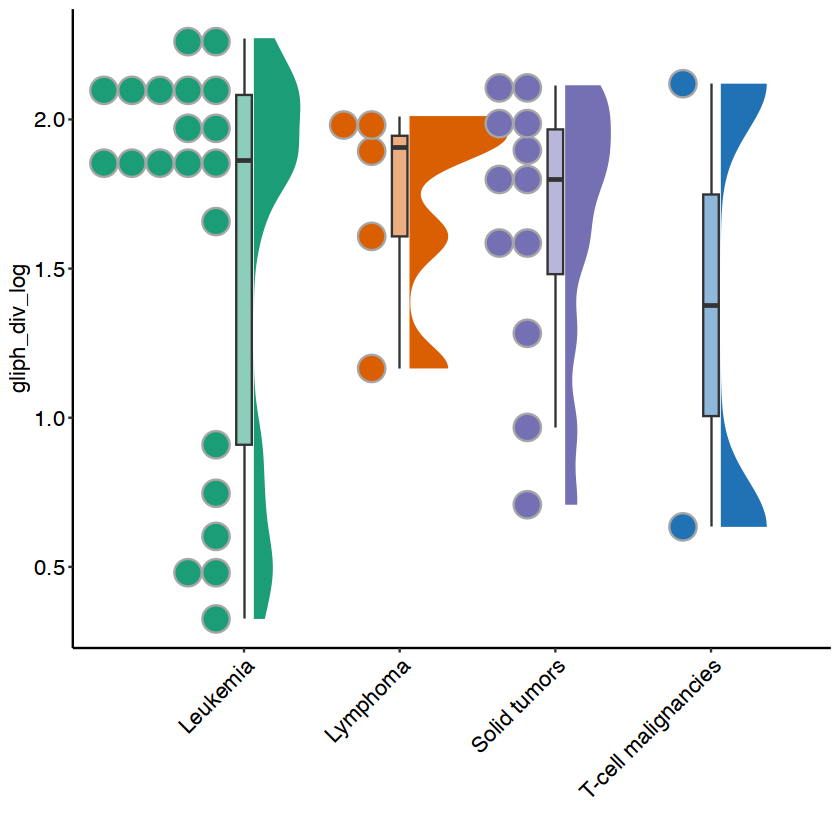

In [129]:
p1

In [130]:
mytest <- "gliph_div_log"
ks.test(X01[[mytest]][ which(X01$cancergroup == "Solid tumors")], X01[[mytest]][ which(X01$cancergroup == "Leukemia")])$p.value
ks.test(X01[[mytest]][ which(X01$cancergroup == "Solid tumors")], X01[[mytest]][ which(X01$cancergroup == "Lymphoma")])$p.value
ks.test(X01[[mytest]][ which(X01$cancergroup == "Lymphoma")], X01[[mytest]][ which(X01$cancergroup == "Leukemia")])$p.value

[1] 0.6423546

[1] 0.8909179

[1] 0.6442688

In [131]:
pdf(paste0(plotpath, "p_gliphdiv_pbmc_X01.pdf"), width = 6, height = 6)
p1
dev.off()

pdf 
  2

Spiderplot

In [132]:
head(sampletype)

,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,...,n_gliph,n_cdr3ingliph,cdr3reads_ingliph,Patient,cycle,sampletype,cancergroup,Age,gliph_div,gliph_div_log
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
CHP-328-04-PBMC-DNA,12,8,0,1,0,73,11,0,0,5,...,243,125,98929,CHP_328,X04,PBMC,Leukemia,7.0,91.22875,1.960132
CHP-328-05-PBMC-DNA,12,7,2,1,0,51,12,0,0,6,...,117,34,15470,CHP_328,X05,PBMC,Leukemia,7.0,82.72436,1.917633
CHP-351-03-PBMC-DNA,14,12,6,1,5,113,21,1,0,8,...,390,248,66508,CHP_351,X03,PBMC,Solid tumors,7.0,214.56354,2.331556
CHP-369-01-PBMC-DNA,12,9,8,1,1,84,11,1,0,9,...,340,183,160268,CHP_369,X01,PBMC,Leukemia,0.1,122.40195,2.087788
CHP-377-02-PBMC-DNA,11,9,0,1,0,62,11,0,0,7,...,182,96,15269,CHP_377,X02,PBMC,Leukemia,18.0,76.24481,1.882210
CHP-411-02-PBMC-DNA,26,10,7,1,0,122,13,1,0,14,...,472,294,55414,CHP_411,X02,PBMC,Leukemia,16.0,247.14003,2.392943


In [133]:
sampletype$Sample <- rownames(sampletype)

In [134]:
sampletype$gliph_div_log_scaled <- scale(sampletype$gliph_div_log)

In [135]:
diff_log10div <- calculate_delta.fx(sampletype, "cycle", "gliph_div_log_scaled")

In [ ]:
# marker <- "gliph_div_log"
# cancergrp <- "Leukemia"

# grp_df <- diff_log10div[diff_log10div$cancergroup == cancergrp, ]
# myformula <- as.formula(paste0("Difference", " ~ cycle + Age + (1 | Patient)"))
# myfit <- lme4::lmer(myformula, data = grp_df) # keep cycle as categorical
# lsm <- lsmeans(myfit, "cycle")
# mylsm_grp <- summary(lsm)
# mylsm_grp$cancergroup <- cancergrp # has to be same as original df
# mylsm_grp$marker <- marker

# myctrt_grp <- as.data.frame(lsmeans::contrast(lsm, "trt.vs.ctrl", ref = "X01"))
# myctrt_grp$cancergroup <- cancergrp
# myctrt_grp$marker <- marker

# leu_div <- list(mylsm_grp, myctrt_grp)

In [216]:
# leu_div[[2]]

Plots

In [ ]:
# diff_log10div$sample_id <- paste0(diff_log10div$Patient, "_", diff_log10div$cycle)
# diff_log10div$sample_id <- gsub("X", "", diff_log10div$sample_id) 

In [136]:
diff_log10div$Relapse <- meta_div$Relapse[ match(diff_log10div$Sample, meta_div$basename) ]
diff_log10div$Disease_type <- meta_div$Disease_type[ match(diff_log10div$Sample, meta_div$basename) ]
diff_log10div$Regimen <- meta_div$regimen[ match(diff_log10div$Sample, meta_div$basename) ]

In [137]:
head(diff_log10div)

CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,...,cancergroup,Age,gliph_div,gliph_div_log,Sample,gliph_div_log_scaled,Difference,Relapse,Disease_type,Regimen
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<chr>,<dbl>,<dbl>,<dbl>,<chr>,"<dbl[,1]>","<dbl[,1]>",<int>,<chr>,<fct>
12,9,8,1,1,84,11,1,0,9,...,Leukemia,0.1,122.40195,2.087788,CHP-369-01-PBMC-DNA,0.7760302,0.00000000,0,AML,Others
11,6,0,1,1,48,11,0,0,5,...,Leukemia,13.0,64.86163,1.811988,CHP_347-01-PBMC-DNA,0.2175937,0.00000000,0,ALL,Vincristine
11,7,2,1,0,79,11,0,0,5,...,Leukemia,13.0,156.03289,2.193216,CHP_347-02-PBMC-DNA,0.9894988,0.77190505,0,ALL,Vincristine/Cyclophosphamide
0,2,3,0,0,6,0,0,0,0,...,Leukemia,13.0,22.52768,1.352716,CHP_347-03-PBMC-DNA,-0.7123318,-0.92992551,0,ALL,Vincristine/Methotrexate
11,6,0,1,0,42,11,0,0,8,...,Leukemia,13.0,71.84699,1.856409,CHP_347-04-PBMC-DNA,0.3075361,0.08994238,0,ALL,Vincristine/Cyclophosphamide
0,0,0,0,0,1,10,0,0,1,...,Leukemia,13.0,23.85382,1.377558,CHP_347-05-PBMC-DNA,-0.6620330,-0.87962677,0,ALL,Vincristine/Methotrexate


In [138]:
tmppp <- diff_log10div[ which(diff_log10div$Patient == "CHP_373"),]

tmppp[ , c("Patient", "Difference", "Disease_type")]

Patient,Difference,Disease_type
<chr>,"<dbl[,1]>",<chr>
CHP_373,0.000000,ALL
CHP_373,-1.496894,ALL


In [139]:
# leupt <- unique(diff_log10div$Patient[diff_log10div$cancergroup == "Solid tumors"])
# mylst <- list()
# for( ii in leupt){
#   tmppp <- diff_log10div[ which(diff_log10div$Patient == ii),]
#   tmppp <- ungroup(tmppp)
#   mylst <- c(mylst, list(tmppp[ tmppp$cyclenum == max(tmppp$cyclenum), c("Patient", "Difference", "cyclenum", "Disease_type")]))
  
# }

In [140]:
# mylst

In [141]:
delta_basespiderplot.fx <- function(df_diff, var1, clrby, colpal) {
    # Create segments data for coloring lines by regimen
    segments_data <- df_diff %>%
        arrange(Patient, eval(parse(text = var1))) %>%
        group_by(Patient) %>%
        mutate(
            x_start = eval(parse(text = var1)),
            y_start = Difference,
            x_end = lead(eval(parse(text = var1))),
            y_end = lead(Difference),
            segment_regimen = Regimen
        ) %>%
        filter(!is.na(x_end)) %>%
        ungroup()
    
    p0 <- ggplot(df_diff, aes(x = eval(parse(text = var1)), y = Difference)) + 
        geom_segment(data = segments_data, 
                    aes(x = x_start, y = y_start, xend = x_end, yend = y_end, 
                        color = segment_regimen), 
                    linewidth = 1) +
        geom_point(cex = 2) + 
        scale_color_manual(values = colpal) + myplot + myaxis + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1), 
            axis.title.x = element_blank(), plot.margin = unit(c(0, 
                0, 0, 0), "cm"))
    return(p0)
}

In [143]:
p_simp <- delta_basespiderplot.fx(
    diff_log10div,  "cycle", "Regimen", colpal
)

In [144]:
table(diff_log10div$Disease_type )


  ALCL    ALL    AML   ARMS    BLL    CML   ERMS    EWS     HB     HD HR ALL 
     4     19     12      2      3      7      3      7      8     10      8 
    NB     OS  T-ALL 
     2      9      2 

In [145]:
diff_log10div$Disease_type <- factor(diff_log10div$Disease_type , levels = c("ALL", "AML", "CML", "HR ALL", # Leukemia
                                       "BLL", "HD",   # Lymphoma  
                                        "ARMS", "ERMS", "EWS", "HB", "NB", "OS",  # Solid tumors
                                        "ALCL", "T-ALL"))

In [146]:
design <- "
 ABCDEF
 GHIJKL
 MN####
"

In [147]:
p_simp <- p_simp + theme(legend.position = "none") +
  # facet_wrap(~cancergroup, nrow = 1, scales = "free_x", strip.position = "top") +
  ggh4x::facet_manual(~ Disease_type, design, scales = "free") +
  theme(
    axis.title.x = element_blank(),
    legend.position = "none",
    strip.background.x = element_blank(),
    strip.placement = "outside",
    strip.text = element_text(size = 13)
  ) +
  ylab("Change in abundant TCR specificities") 
  # scale_x_discrete(get_breaks("cycle"),
  #   labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
  # )


In [148]:
p_simp <- p_simp + geom_hline(yintercept = 0, linetype = "dashed", color = "red")

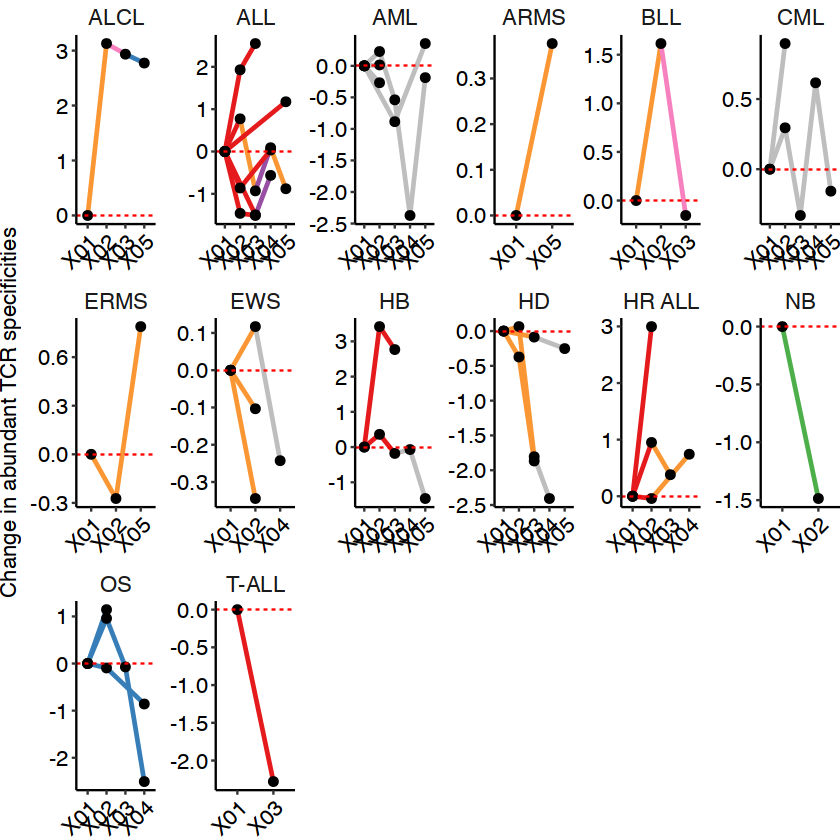

In [149]:
p_simp

In [150]:
pdf(paste0(plotpath, "p_spider_gliphdiv_pbmc_regimen_disease_type.pdf"), width = 10, height = 10)
cowplot::plot_grid(p_simp, labels = "A")
dev.off()

pdf 
  2

# 2 - Fisher scores vs difference

In [151]:
samples_tcr <- readr::read_rds(file = paste0(datapath, "GLIPH/int_samples_gliph_tigerdb_annot_stat.rds"))
gliphdf <- readr::read_rds( file = paste0(datapath, "GLIPH/gliph_tigerdb_annot_stat.rds"))

In [152]:
dim(gliphdf)

[1] 8231   15

In [153]:
gliph_out <- readr::read_rds(file = paste0(datapath, "GLIPH/int_gliph_tigerdb_cleaned.rds"))

In [154]:
chp_gliph <- gliph_out[ grepl("CHP", gliph_out$Sample), ]
# chp_gliph <- chp_gliph[!grepl("Normal", chp_gliph$subject),]

In [155]:
length(unique(gliph_out$Sample))

[1] 666

In [156]:
meta_div[ meta_div$Patient == "CHP_422",]

,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,estimated_Simpson,SE_Simpson,basename,file,sampletype,Group,log10shann,sample_id_sampletype,assay,regimen
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>
451,CHP_422_01,CHP_422,X01,0.6,2136.39,12,ALL,0.6,NA,NA,...,4.797901,0.04693025,CHP_422-01_cfDNA,priority_pool2/mixcr/clones/CLONES_TRBCHP_422-01_cfDNA.txt,cfDNA,CHP,0.7669209,CHP_422_01_cfDNA,capTCR-seq,Vincristine


In [157]:
length(unique(meta_div$Patient))

[1] 99

In [158]:
chp_gliph_pbmc <- chp_gliph[grepl("PBMC", chp_gliph$Sample),]

In [159]:
chp_gliph_pbmc$Patient <- meta_div$Patient[match(chp_gliph_pbmc$Sample, meta_div$basename)]
chp_gliph_pbmc$cycle <- meta_div$cycle[match(chp_gliph_pbmc$Sample, meta_div$basename)]
chp_gliph_pbmc$sampletype <- meta_div$sampletype[match(chp_gliph_pbmc$Sample, meta_div$basename)]
chp_gliph_pbmc$cancergroup <- meta_div$cancergroup[match(chp_gliph_pbmc$Sample, meta_div$basename)]

In [160]:
head(chp_gliph_pbmc)

index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,...,V,J,TcRa,Sample,Freq,subject,Patient,cycle,sampletype,cancergroup
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SCP,0,197,657,1e-05,1,1,1,1,...,TRBV27,TRBJ2-2P,NA,CHP_398-05_PBMC-DNA,1,CHP_398-05_PBMC-DNA,CHP_398,X05,PBMC,Leukemia
1,SCP,0,197,657,1e-05,1,1,1,1,...,TRBV27,TRBJ2-2P,NA,CHP_405-04-PBMC-DNA,9,CHP_405-04-PBMC-DNA,CHP_405,X04,PBMC,Leukemia
1,SCP,0,197,657,1e-05,1,1,1,1,...,TRBV27,TRBJ2-2P,NA,CHP_331-05-PBMC-DNA,3,CHP_331-05-PBMC-DNA,CHP_331,X05,PBMC,Leukemia
1,SCP,0,197,657,1e-05,1,1,1,1,...,TRBV9,TRBJ2-2P,NA,CHP_401-05-PBMC-DNA,29,CHP_401-05-PBMC-DNA,CHP_401,X05,PBMC,Solid tumors
1,SCP,0,197,657,1e-05,1,1,1,1,...,TRBV9,TRBJ2-2P,NA,CHP_338-03-PBMC-DNA,28,CHP_338-03-PBMC-DNA,CHP_338,X03,PBMC,Leukemia
1,SCP,0,197,657,1e-05,1,1,1,1,...,TRBV4-1,TRBJ2-2P,NA,CHP_396-02-PBMC-DNA,1,CHP_396-02-PBMC-DNA,CHP_396,X02,PBMC,Leukemia


In [161]:
# get patients with more than one timepoiint and a baseline
mytab <- table(chp_gliph_pbmc$Patient, chp_gliph_pbmc$cycle)
mytab <- mytab[rowSums(mytab != 0) > 1, ]
baseline_patients <- rownames(mytab)[mytab[, 1] > 0]

In [162]:
head(mytab)

         
          X01 X02 X03 X04 X05
  CHP_323   0   0  82   0  65
  CHP_328   0   0   0 336 189
  CHP_331   0   0   0  15 128
  CHP_338   0   0 667  57 201
  CHP_339   0   0  13   0 294
  CHP_340   0   0 237 131 396

In [163]:
length(baseline_patients)

[1] 33

In [164]:
df1 <- chp_gliph_pbmc[chp_gliph_pbmc$Patient %in% baseline_patients, ]

In [165]:
head(df1)

index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,...,V,J,TcRa,Sample,Freq,subject,Patient,cycle,sampletype,cancergroup
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SCP,0,197,657,1e-05,1,1,1,1,...,TRBV27,TRBJ2-2P,NA,CHP_405-04-PBMC-DNA,9,CHP_405-04-PBMC-DNA,CHP_405,X04,PBMC,Leukemia
1,SCP,0,197,657,1e-05,1,1,1,1,...,TRBV4-1,TRBJ2-2P,NA,CHP_396-02-PBMC-DNA,1,CHP_396-02-PBMC-DNA,CHP_396,X02,PBMC,Leukemia
1,SCP,0,197,657,1e-05,1,1,1,1,...,TRBV4-1,TRBJ2-2P,NA,CHP_381-02-PBMC-DNA,1,CHP_381-02-PBMC-DNA,CHP_381,X02,PBMC,Solid tumors
1,SCP,0,197,657,1e-05,1,1,1,1,...,TRBV13,TRBJ2-2P,NA,CHP_405-01_PBMC_DNA,2,CHP_405-01_PBMC_DNA,CHP_405,X01,PBMC,Leukemia
1,SCP,0,197,657,1e-05,1,1,1,1,...,TRBV6-4,TRBJ2-2P,NA,CHP_361-02-PBMC-DNA,28,CHP_361-02-PBMC-DNA,CHP_361,X02,PBMC,Lymphoma
1,SCP,0,197,657,1e-05,1,1,1,1,...,TRBV6-5,TRBJ2-2P,NA,CHP_414-02-PBMC-DNA,11,CHP_414-02-PBMC-DNA,CHP_414,X02,PBMC,Solid tumors


In [166]:
# separate pre and post
df1_pre <- df1[ df1$cycle == "X01",]
df1_post <- df1[ df1$cycle != "X01",]

In [167]:
dim(df1_pre)

[1] 7067   23

In [168]:
# group by patient and pattern, average frequencyes across samples postchemo
df1_post_mean <- df1_post %>%
  group_by(Patient, pattern) %>%
  summarise(MeanFreq = mean(Freq), .groups = 'drop') %>%
  ungroup()

In [169]:
# group by samples and patterns, avergae the frequencies, if there is > 1 CDR3s in a pattern
df1_pre_mean <- df1_pre %>%
  group_by(Sample, pattern) %>%
  summarise(MeanFreq = mean(Freq), .groups = 'drop') %>%
  ungroup()

In [170]:
head(df1_post_mean)

Patient,pattern,MeanFreq
<chr>,<chr>,<dbl>
CHP_347,%AGTGGQET,26
CHP_347,%ATGNTGE,7
CHP_347,%FFSGNT,6
CHP_347,%FGAYNE,34
CHP_347,%GGYE,8
CHP_347,%GQGNTE,8


In [171]:
head(df1_pre_mean)

Sample,pattern,MeanFreq
<chr>,<chr>,<dbl>
CHP-369-01-PBMC-DNA,%AGTENTE,130
CHP-369-01-PBMC-DNA,%AGTGGYE,482
CHP-369-01-PBMC-DNA,%ESKGNQP,201
CHP-369-01-PBMC-DNA,%ETGENTE,23
CHP-369-01-PBMC-DNA,%FRDRGVRE,1212
CHP-369-01-PBMC-DNA,%FVTGE,584


In [172]:
df1_pre_mean$Patient <- meta_div$Patient[match(df1_pre_mean$Sample, meta_div$basename)]
df1_pre_mean$cycle <- meta_div$cycle[match(df1_pre_mean$Sample, meta_div$basename)]
df1_pre_mean$sampletype <- meta_div$sampletype[match(df1_pre_mean$Sample, meta_div$basename)]
df1_pre_mean$cancergroup <- meta_div$cancergroup[match(df1_pre_mean$Sample, meta_div$basename)]
head(df1_pre_mean)

Sample,pattern,MeanFreq,Patient,cycle,sampletype,cancergroup
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
CHP-369-01-PBMC-DNA,%AGTENTE,130,CHP_369,X01,PBMC,Leukemia
CHP-369-01-PBMC-DNA,%AGTGGYE,482,CHP_369,X01,PBMC,Leukemia
CHP-369-01-PBMC-DNA,%ESKGNQP,201,CHP_369,X01,PBMC,Leukemia
CHP-369-01-PBMC-DNA,%ETGENTE,23,CHP_369,X01,PBMC,Leukemia
CHP-369-01-PBMC-DNA,%FRDRGVRE,1212,CHP_369,X01,PBMC,Leukemia
CHP-369-01-PBMC-DNA,%FVTGE,584,CHP_369,X01,PBMC,Leukemia


In [173]:
# matrix gliph x patient
gliph_pat_mat <- matrix(NA,
    nrow = length(unique(df1$pattern)), ncol = length(unique(df1$Patient)),
    dimnames = list(unique(df1$pattern), unique(df1$Patient))
)

In [174]:
head(gliph_pat_mat)

,CHP_405,CHP_396,CHP_381,CHP_361,CHP_414,CHP_365,CHP_378,CHP_347,CHP_364,CHP_408,...,CHP_418,CHP_357,CHP_362,CHP_366,CHP_368,CHP_387,CHP_367,CHP_412,CHP_409,CHP_349
SCP,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SERA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
TVL,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
LFF,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SSER,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
KEAV,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [175]:
dim(gliph_pat_mat)

[1] 5569   33

In [176]:
for (i in 1:nrow(gliph_pat_mat)) { # pattern loop
    for (j in 1:ncol(gliph_pat_mat)) { # patient loop
        mypattern <- rownames(gliph_pat_mat)[i]
        mypt <- colnames(gliph_pat_mat)[j]
        pt_pre <- df1_pre_mean[df1_pre_mean$Patient == mypt, ]
        pt_post <- df1_post_mean[df1_post_mean$Patient == mypt, ]
        if (length(pt_pre$MeanFreq[pt_pre$pattern == mypattern]) != 0 && length(pt_post$MeanFreq[pt_post$pattern == mypattern]) != 0) { # if pattern is present in both pre and post
            gliph_pat_mat[i, j] <- pt_post$MeanFreq[pt_post$pattern == mypattern] - pt_pre$MeanFreq[pt_pre$pattern == mypattern] # post - pre
        } # end of if
    } # end of patient loop
} # end of pattern loop

In [177]:
gliph_pat_mat <- as.data.frame(gliph_pat_mat)

In [178]:
# Add Fisher score to gliph_pat_mat
gliph_pat_mat$fisher <- df1$Fisher_score[match(rownames(gliph_pat_mat), df1$pattern)]

In [179]:
gliph_pat_mat$gliph <- rownames(gliph_pat_mat)

In [180]:
head(gliph_pat_mat)

,CHP_405,CHP_396,CHP_381,CHP_361,CHP_414,CHP_365,CHP_378,CHP_347,CHP_364,CHP_408,...,CHP_362,CHP_366,CHP_368,CHP_387,CHP_367,CHP_412,CHP_409,CHP_349,fisher,gliph
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
SCP,10.500000,6.90000,NA,-2.666667,NA,-29.500000,-18.35714,1.000000,-19.5,NA,...,NA,209.5,-3.25,NA,NA,NA,NA,NA,0,SCP
SERA,10.500000,3.95000,NA,-2.666667,NA,-29.500000,-18.35714,1.666667,-19.5,NA,...,NA,209.5,-3.25,NA,NA,NA,NA,NA,0,SERA
TVL,10.500000,12.15000,-281.7778,-2.666667,NA,5.166667,-16.75000,1.000000,-19.5,NA,...,4.1,209.5,-3.25,NA,NA,NA,NA,NA,0,TVL
LFF,10.500000,6.90000,NA,-2.666667,NA,-29.500000,-18.35714,1.000000,-19.5,NA,...,NA,209.5,-3.25,NA,NA,NA,NA,NA,0,LFF
SSER,9.782051,11.65476,NA,-2.666667,NA,-29.500000,-18.35714,1.000000,-19.5,NA,...,NA,209.5,-3.25,NA,NA,NA,NA,NA,0,SSER
KEAV,10.500000,6.90000,NA,-2.666667,NA,-29.500000,-18.35714,1.000000,-19.5,NA,...,NA,209.5,-3.25,NA,NA,NA,NA,NA,0,KEAV


In [181]:
# check one sample
df1_pre_mean[df1_pre_mean$Patient == "CHP_381" & df1_pre_mean$pattern == "S%GGNTE",]
df1_post_mean[df1_post_mean$Patient == "CHP_381" & df1_post_mean$pattern == "S%GGNTE",]

temp <- gliph_out[ grepl("CHP_381", gliph_out$Sample), ]
temp[ temp$pattern == "S%GGNTE",]

Sample,pattern,MeanFreq,Patient,cycle,sampletype,cancergroup
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
CHP_381-01_PBMC-DNA,S%GGNTE,114,CHP_381,X01,PBMC,Solid tumors


Patient,pattern,MeanFreq
<chr>,<chr>,<dbl>
CHP_381,S%GGNTE,5


index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,TcRb,V,J,TcRa,Sample,Freq,subject
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
9458,S%GGNTE,0.73,4,3,6.5e-07,1,0.48,0.22,0.001,0.0062,global-S%GGNTE,CASSQGGNTEAFF,TRBV14,TRBJ1-1,NA,CHP_381-01_PBMC-DNA,134,CHP_381-01_PBMC-DNA
9458,S%GGNTE,0.73,4,3,6.5e-07,1,0.48,0.22,0.001,0.0062,global-S%GGNTE,CASSQGGNTEAFF,TRBV3-1,TRBJ1-1,NA,CHP_381-02-PBMC-DNA,5,CHP_381-02-PBMC-DNA
9458,S%GGNTE,0.73,4,3,6.5e-07,1,0.48,0.22,0.001,0.0062,global-S%GGNTE,CASSRGGNTEAFF,TRBV28,TRBJ1-1,NA,CHP_381-01_PBMC-DNA,94,CHP_381-01_PBMC-DNA


In [182]:
# long format keep fisher and gliph as columns
gliph_pat_mat_long <- tidyr::pivot_longer(gliph_pat_mat, -c("fisher", "gliph"), names_to = "Patient", values_to = "Delta")

In [183]:
# remove rows with NA
gliph_pat_mat_long <- gliph_pat_mat_long[ !is.na(gliph_pat_mat_long$Delta), ]

In [184]:
head(gliph_pat_mat_long)

fisher,gliph,Patient,Delta
<dbl>,<chr>,<chr>,<dbl>
0,SCP,CHP_405,10.500000
0,SCP,CHP_396,6.900000
0,SCP,CHP_361,-2.666667
0,SCP,CHP_365,-29.500000
0,SCP,CHP_378,-18.357143
0,SCP,CHP_347,1.000000


In [185]:
gliphdf_original <- gliphdf # save original gliphdf

In [186]:
# gliphdf[, 2:12][gliphdf[, 2:12] > 0] <- 1 # count each group only once

In [187]:
head(gliphdf)

,gliph,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,SP,HTLV1,YFV,n_unique_cdr3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SCP,SCP,0,0,0,0,0,0,0,0,0,0,0,0,0,657
SERA,SERA,0,0,0,0,0,0,0,0,0,0,0,0,0,656
TVL,TVL,0,0,0,0,0,3,1,0,0,0,0,0,0,646
LFF,LFF,0,0,0,0,0,1,0,0,0,0,0,0,0,660
SSER,SSER,0,0,0,0,0,0,0,0,0,0,0,0,0,657
KEAV,KEAV,0,0,0,0,0,0,0,0,0,0,0,0,0,630


In [188]:
# Add annotations to gliph_pat_mat_long
gliph_pat_mat_long$CMV <- gliphdf$CMV[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]
gliph_pat_mat_long$Flu <- gliphdf$Influenza[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]
gliph_pat_mat_long$HCV <- gliphdf$HCV[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]
gliph_pat_mat_long$EBV <- gliphdf$EBV[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]
gliph_pat_mat_long$HPV <- gliphdf$HPV[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]
gliph_pat_mat_long$HS <- gliphdf$Human[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]
gliph_pat_mat_long$CEF <- gliphdf$CEF[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]
gliph_pat_mat_long$HSV <- gliphdf$HSV[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]
gliph_pat_mat_long$TB <- gliphdf$TB[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]
gliph_pat_mat_long$SP <- gliphdf$SP[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]
gliph_pat_mat_long$MCPyV <- gliphdf$MCPyV[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]
gliph_pat_mat_long$YFV <- gliphdf$YFV[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]

In [189]:
gliph_pat_mat_long$n_unique_cdr3 <- gliphdf$n_unique_cdr3[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]

In [190]:
gliph_pat_mat_long$cancergroup <- meta_div$cancergroup[match(gliph_pat_mat_long$Patient, meta_div$Patient)]
gliph_pat_mat_long$Disease <- meta_div$Disease_type[match(gliph_pat_mat_long$Patient, meta_div$Patient)]
gliph_pat_mat_long$Relapse <- meta_div$Relapse[match(gliph_pat_mat_long$Patient, meta_div$Patient)]

In [191]:
head(gliph_pat_mat_long)

fisher,gliph,Patient,Delta,CMV,Flu,HCV,EBV,HPV,HS,CEF,HSV,TB,SP,MCPyV,YFV,n_unique_cdr3,cancergroup,Disease,Relapse
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
0,SCP,CHP_405,10.500000,0,0,0,0,0,0,0,0,0,0,0,0,657,Leukemia,CML,0
0,SCP,CHP_396,6.900000,0,0,0,0,0,0,0,0,0,0,0,0,657,Leukemia,HR ALL,0
0,SCP,CHP_361,-2.666667,0,0,0,0,0,0,0,0,0,0,0,0,657,Lymphoma,HD,0
0,SCP,CHP_365,-29.500000,0,0,0,0,0,0,0,0,0,0,0,0,657,Leukemia,ALL,0
0,SCP,CHP_378,-18.357143,0,0,0,0,0,0,0,0,0,0,0,0,657,Leukemia,ALL,0
0,SCP,CHP_347,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,657,Leukemia,ALL,0


In [192]:
temp <- gliph_out[ gliph_out$pattern == "S%GGNTE", ]
table(temp$subject)


CHP_345-02-PBMC-DNA CHP_347-02-PBMC-DNA CHP_357-05_PBMC-DNA CHP_370-02-PBMC-DNA 
                  1                   1                   1                   1 
CHP_381-01_PBMC-DNA CHP_381-02-PBMC-DNA CHP_382-05-PBMC-DNA CHP_391-02_PBMC_DNA 
                  2                   1                   1                   1 
CHP_391-03_PBMC_DNA CHP_393-05-PBMC-DNA CHP_403-03_PBMC-DNA               Human 
                  1                   1                   1                   1 

In [193]:
length(unique(gliph_pat_mat_long$Patient))

[1] 27

In [194]:
length(unique(gliph_pat_mat_long$gliph))

[1] 147

In [195]:
summary(gliph_pat_mat_long$Delta)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-465.000  -19.500    0.250    9.039    7.598  741.000 

In [196]:
quantile(gliph_pat_mat_long$Delta, c(0.1, 0.9))

10%       90% 
-29.50000  20.01111

In [197]:
head(gliph_pat_mat_long)

fisher,gliph,Patient,Delta,CMV,Flu,HCV,EBV,HPV,HS,CEF,HSV,TB,SP,MCPyV,YFV,n_unique_cdr3,cancergroup,Disease,Relapse
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
0,SCP,CHP_405,10.500000,0,0,0,0,0,0,0,0,0,0,0,0,657,Leukemia,CML,0
0,SCP,CHP_396,6.900000,0,0,0,0,0,0,0,0,0,0,0,0,657,Leukemia,HR ALL,0
0,SCP,CHP_361,-2.666667,0,0,0,0,0,0,0,0,0,0,0,0,657,Lymphoma,HD,0
0,SCP,CHP_365,-29.500000,0,0,0,0,0,0,0,0,0,0,0,0,657,Leukemia,ALL,0
0,SCP,CHP_378,-18.357143,0,0,0,0,0,0,0,0,0,0,0,0,657,Leukemia,ALL,0
0,SCP,CHP_347,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,657,Leukemia,ALL,0


In [198]:
dim(gliph_pat_mat_long[ gliph_pat_mat_long$Delta < 20 & gliph_pat_mat_long$Delta > -29.5 & gliph_pat_mat_long$fisher < 0.0001,])

[1] 951  20

In [199]:
# 3 groups common among more than 1 patient
gliph_pat_mat_long[ gliph_pat_mat_long$gliph %in% c("SLG%NTE", "SL%GE", "S%"),]

fisher,gliph,Patient,Delta,CMV,Flu,HCV,EBV,HPV,HS,CEF,HSV,TB,SP,MCPyV,YFV,n_unique_cdr3,cancergroup,Disease,Relapse
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
1.7e-07,SL%GE,CHP_381,-1,0,0,1,0,0,1,0,0,0,0,0,0,21,Solid tumors,EWS,0
2.2e-05,SLG%NTE,CHP_381,-44,0,0,0,0,0,0,0,0,0,0,0,0,14,Solid tumors,EWS,0


In [200]:
gliph_pat_mat_long[ gliph_pat_mat_long$SP != 0,]

fisher,gliph,Patient,Delta,CMV,Flu,HCV,EBV,HPV,HS,CEF,HSV,TB,SP,MCPyV,YFV,n_unique_cdr3,cancergroup,Disease,Relapse
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
0.0e+00,AVGA,CHP_405,10.893939,0,0,0,1,0,0,0,0,0,1,0,0,630,Leukemia,CML,0
0.0e+00,AVGA,CHP_396,6.900000,0,0,0,1,0,0,0,0,0,1,0,0,630,Leukemia,HR ALL,0
0.0e+00,AVGA,CHP_361,-2.666667,0,0,0,1,0,0,0,0,0,1,0,0,630,Lymphoma,HD,0
0.0e+00,AVGA,CHP_365,-22.500000,0,0,0,1,0,0,0,0,0,1,0,0,630,Leukemia,ALL,0
0.0e+00,AVGA,CHP_378,-18.357143,0,0,0,1,0,0,0,0,0,1,0,0,630,Leukemia,ALL,0
0.0e+00,AVGA,CHP_347,1.000000,0,0,0,1,0,0,0,0,0,1,0,0,630,Leukemia,ALL,0
0.0e+00,AVGA,CHP_364,-19.500000,0,0,0,1,0,0,0,0,0,1,0,0,630,Solid tumors,OS,1
0.0e+00,AVGA,CHP_399,-45.375000,0,0,0,1,0,0,0,0,0,1,0,0,630,Leukemia,HR ALL,0
0.0e+00,AVGA,CHP_410,6.166667,0,0,0,1,0,0,0,0,0,1,0,0,630,Leukemia,ALL,0


In [201]:
# Group antigens into categories
gliph_pat_mat_long$antigen <- NA
for (i in 1:nrow(gliph_pat_mat_long)) {

    if (rowSums(gliph_pat_mat_long[i, c("CMV", "Flu", "HCV", "EBV", "HPV", "MCPyV", "HSV", "YFV")]) > 0) {
        gliph_pat_mat_long$antigen[i] <- "Viral"
    }
    if (rowSums(gliph_pat_mat_long[i, "HS"]) > 0) {
        gliph_pat_mat_long$antigen[i] <- "HomoSapiens"
    }
    if (rowSums(gliph_pat_mat_long[i, c("TB", "SP")]) > 0) {
        gliph_pat_mat_long$antigen[i] <- "Bacterial"
    }    
    if (rowSums(gliph_pat_mat_long[i, "HS"]) > 0 && rowSums(gliph_pat_mat_long[i, c("TB", "SP", "CMV", "Flu", "HCV", "HSV", "YFV", "EBV", "HPV", "MCPyV")]) > 0) {
        gliph_pat_mat_long$antigen[i] <- "Cross-reactive"
    }
}

In [202]:
gliph_pat_mat_long$antigen[ is.na(gliph_pat_mat_long$antigen)] <- "Unknown"

In [203]:
table(gliph_pat_mat_long$antigen)


     Bacterial Cross-reactive    HomoSapiens        Unknown          Viral 
            18            144            252            725            171 

In [204]:
summary(gliph_pat_mat_long$fisher)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.00685 0.00000 0.58000 

In [205]:
min(gliph_pat_mat_long$fisher[ gliph_pat_mat_long$fisher > 0])

[1] 5.8e-24

In [206]:
gliph_pat_mat_long$log10fisher <- -log10(gliph_pat_mat_long$fisher + 1e-25)

In [207]:
gliph_pat_mat_long[ gliph_pat_mat_long$Delta > 430 & gliph_pat_mat_long$fisher < 0.0001,]

fisher,gliph,Patient,Delta,CMV,Flu,HCV,EBV,HPV,HS,...,TB,SP,MCPyV,YFV,n_unique_cdr3,cancergroup,Disease,Relapse,antigen,log10fisher
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<chr>,<dbl>
0,AGW,CHP_413,741,0,0,0,0,0,3,...,0,0,0,0,656,Leukemia,AML,1,HomoSapiens,25


In [208]:
# gliph_pat_mat_long[ gliph_pat_mat_long$cancergroup == "Lymphoma",]

In [209]:
# gliph_pat_mat_long$label <- NA
# gliph_pat_mat_long$label[ gliph_pat_mat_long$Delta > 367.6 & gliph_pat_mat_long$fisher < 0.0001] <- "X"
# gliph_pat_mat_long$label[ gliph_pat_mat_long$Delta < -280.8 & gliph_pat_mat_long$fisher < 0.0001] <- "X"
# gliph_pat_mat_long$label[ gliph_pat_mat_long$Patient == "CHP_413"] <- NA
# gliph_pat_mat_long$label[ gliph_pat_mat_long$Patient == "CHP_362"] <- NA
# gliph_pat_mat_long$label[ gliph_pat_mat_long$Patient == "CHP_404"] <- NA

In [210]:
# tbl <- data.frame( pt = gliph_pat_mat_long$Patient[ which(gliph_pat_mat_long$label == "X") ],
# xend = gliph_pat_mat_long$Delta[ which(gliph_pat_mat_long$label == "X") ] - 20, 
# yend = gliph_pat_mat_long$log10fisher[ which(gliph_pat_mat_long$label == "X") ] )

In [211]:
# tbl$x <- NA
# tbl$y <- NA

In [212]:
# tbl$x[ tbl$pt == "CHP_369"] <- -1000
# tbl$y[ tbl$pt == "CHP_369"] <- 25
# tbl$x[ tbl$pt == "CHP_365"] <- -1000
# tbl$y[ tbl$pt == "CHP_365"] <- 20
# tbl$x[ tbl$pt == "CHP_381"] <- -900
# tbl$y[ tbl$pt == "CHP_381"] <- 10
# tbl$x[ tbl$pt == "CHP_396"] <- 1200
# tbl$y[ tbl$pt == "CHP_396"] <- 10
# tbl$x[ tbl$pt == "CHP_366"] <- 500
# tbl$y[ tbl$pt == "CHP_366"] <- 12

In [213]:
# tbl

In [214]:
p4 <- ggplot() +
    geom_point(data = gliph_pat_mat_long, aes(x = Delta, y = -log10(fisher + 1e-25), color = cancergroup, shape = antigen), alpha = 0.6, size = 5) +
    myplot +
    myaxis +
    geom_hline(yintercept = -log10(0.0001), linetype = 5) +
    geom_vline(xintercept = c(20, -29.5), linetype = 3) +
    theme(axis.text.x = element_text(angle = 0, hjust = 0.5), legend.title = element_text(size = 10)) +
    labs(y = "-log10(Fisher score)", x = "TCR specificity group clonal change \n[post-therapy - pre-therapy]") +
    guides(color = guide_legend(title = "Cancer groups"), shape = guide_legend(title = "Antigen"), size = guide_legend(title = "Unique CDR3s (count)")) +
    scale_color_manual(values = group_col)

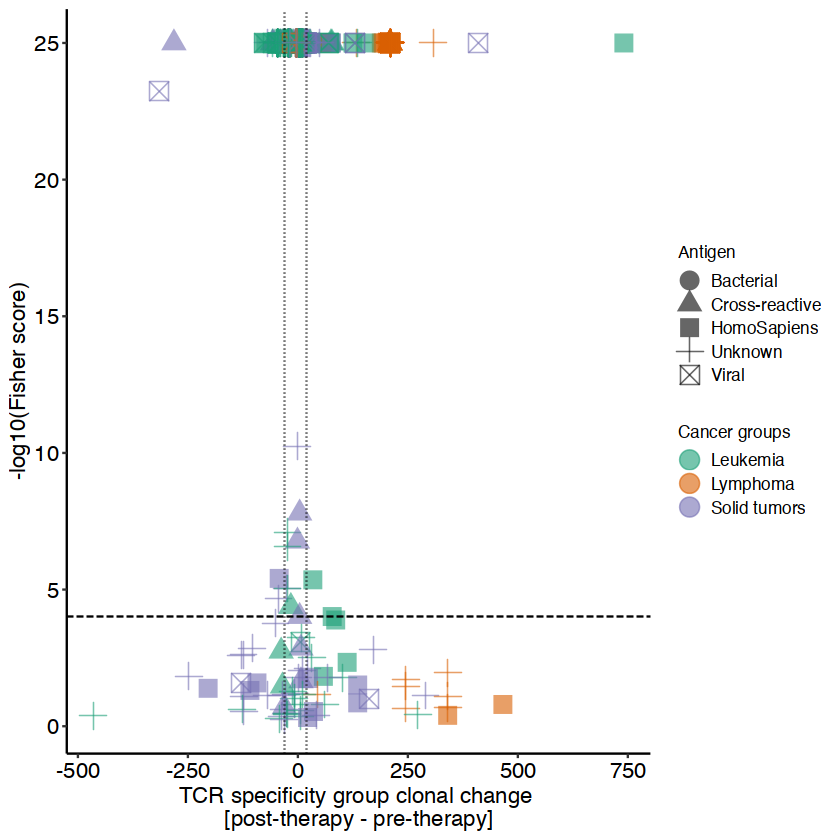

In [215]:
p4

In [ ]:
# p4 <- ggplot() +
#     geom_point(data = gliph_pat_mat_long, aes(size = n_unique_cdr3, x = Delta, y = -log10(fisher), color = cancergroup, shape = antigen), alpha = 0.6) +
#     myplot +
#     myaxis +
#     geom_hline(yintercept = c(-log10(0.0001), 42), linetype = c(5, 1)) +
#     geom_vline(xintercept = c(367.6, -280.9), linetype = 3) +
#     theme(axis.text.x = element_text(angle = 0, hjust = 0.5), legend.title = element_text(size = 10)) +
#     labs(y = "-log10(Fisher score)", x = "TCR specificity group clonal change \n[post-therapy - pre-therapy]") +
#     guides(color = guide_legend(title = "Cancer groups"), shape = guide_legend(title = "Antigen"), size = guide_legend(title = "Unique CDR3s (count)")) +
#     scale_color_manual(values = group_col)

In [ ]:
# p4_1 <- p4 + geom_segment( data = tbl, mapping = aes(x = x, y = y, xend = xend, yend = yend), linewidth = 0.5,
#          arrow = arrow(length = unit(0.02, "npc"))) + 
#          geom_text( data = tbl, mapping = aes(label = pt, x = x, y = y + 1))

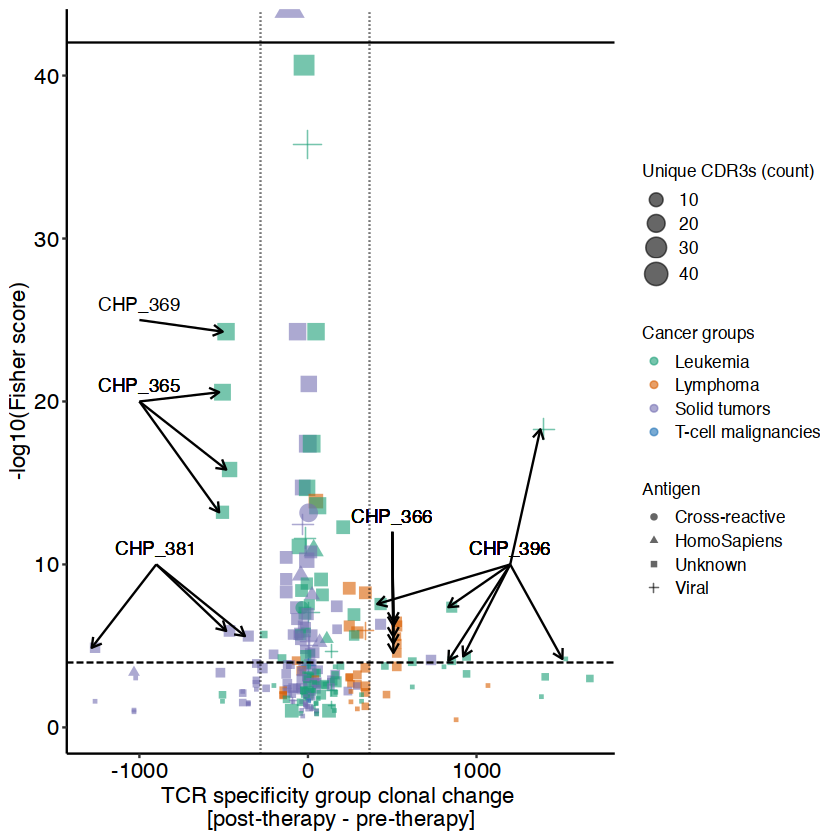

In [ ]:
# p4_1

In [216]:
pdf(paste0(plotpath, "p_tigerdb_gliph_fisher_delta.pdf"), width = 7, height = 6)
cowplot::plot_grid(p4, labels = "C")
dev.off()

pdf 
  2

# 4.1 Fisher score vs delta per regimen

In [19]:
samples_tcr <- readr::read_rds(file = paste0(datapath, "GLIPH/int_samples_gliph_tigerdb_annot_stat.rds"))
gliphdf <- readr::read_rds( file = paste0(datapath, "GLIPH/gliph_tigerdb_annot_stat.rds"))

In [20]:
gliph_out <- readr::read_rds(file = paste0(datapath, "GLIPH/int_gliph_tigerdb_cleaned.rds"))

In [21]:
chp_gliph <- gliph_out[ grepl("CHP", gliph_out$Sample), ]
# chp_gliph <- chp_gliph[!grepl("Normal", chp_gliph$subject),]

In [22]:
chp_gliph_pbmc <- chp_gliph[grepl("PBMC", chp_gliph$Sample),]

In [23]:
chp_gliph_pbmc$Patient <- meta_div$Patient[match(chp_gliph_pbmc$Sample, meta_div$basename)]
chp_gliph_pbmc$cycle <- meta_div$cycle[match(chp_gliph_pbmc$Sample, meta_div$basename)]
chp_gliph_pbmc$sampletype <- meta_div$sampletype[match(chp_gliph_pbmc$Sample, meta_div$basename)]
chp_gliph_pbmc$cancergroup <- meta_div$cancergroup[match(chp_gliph_pbmc$Sample, meta_div$basename)]
chp_gliph_pbmc$regimen <- meta_div$regimen[match(chp_gliph_pbmc$Sample, meta_div$basename)]

In [24]:
# get patients with more than one timepoiint and a baseline
mytab <- table(chp_gliph_pbmc$Patient, chp_gliph_pbmc$cycle)
mytab <- mytab[rowSums(mytab != 0) > 1, ]
baseline_patients <- rownames(mytab)[mytab[, 1] > 0]

In [25]:
head(mytab)

         
          X01 X02 X03 X04 X05
  CHP_323   0   0  82   0  65
  CHP_328   0   0   0 336 189
  CHP_331   0   0   0  15 128
  CHP_338   0   0 667  57 201
  CHP_339   0   0  13   0 294
  CHP_340   0   0 237 131 396

In [26]:
length(baseline_patients)

[1] 33

In [27]:
df1 <- chp_gliph_pbmc[chp_gliph_pbmc$Patient %in% baseline_patients, ]

In [28]:
table(df1$cycle)


 X01  X02  X03  X04  X05 
7067 7872 3727 3077 4097 

In [29]:
# separate pre and post
df1_pre <- df1[ df1$cycle == "X01",]
df1_x02 <- df1[ df1$cycle == "X02",]
df1_x03 <- df1[ df1$cycle == "X03",]
df1_x04 <- df1[ df1$cycle == "X04",]
df1_x05 <- df1[ df1$cycle == "X05",]

In [30]:
dim(df1_pre)

[1] 7067   24

In [31]:
# group by samples and patterns, avergae the frequencies, if there is > 1 CDR3s in a pattern. do it for all cycles
df1_pre <- df1_pre %>%
  group_by(Sample, pattern) %>%
  summarise(MeanFreq = mean(Freq), .groups = 'drop') %>%
  ungroup()
df1_x02 <- df1_x02 %>%  
  group_by(Sample, pattern) %>%
  summarise(MeanFreq = mean(Freq), .groups = 'drop') %>%
  ungroup()
df1_x03 <- df1_x03 %>%
  group_by(Sample, pattern) %>%
  summarise(MeanFreq = mean(Freq), .groups = 'drop') %>%
  ungroup()
df1_x04 <- df1_x04 %>%
  group_by(Sample, pattern) %>%
  summarise(MeanFreq = mean(Freq), .groups = 'drop') %>%
  ungroup()
df1_x05 <- df1_x05 %>%
  group_by(Sample, pattern) %>%
  summarise(MeanFreq = mean(Freq), .groups = 'drop') %>%  
  ungroup()

In [32]:
head(df1_pre)

Sample,pattern,MeanFreq
<chr>,<chr>,<dbl>
CHP-369-01-PBMC-DNA,%AGTENTE,130
CHP-369-01-PBMC-DNA,%AGTGGYE,482
CHP-369-01-PBMC-DNA,%ESKGNQP,201
CHP-369-01-PBMC-DNA,%ETGENTE,23
CHP-369-01-PBMC-DNA,%FRDRGVRE,1212
CHP-369-01-PBMC-DNA,%FVTGE,584


In [33]:
df1_pre$Regimen <- meta_div$regimen[match(df1_pre$Sample, meta_div$basename)]
df1_x02$Regimen <- meta_div$regimen[match(df1_x02$Sample, meta_div$basename)]
df1_x03$Regimen <- meta_div$regimen[match(df1_x03$Sample, meta_div$basename)]
df1_x04$Regimen <- meta_div$regimen[match(df1_x04$Sample, meta_div$basename)]
df1_x05$Regimen <- meta_div$regimen[match(df1_x05$Sample, meta_div$basename)]

df1_pre$cancergroup <- meta_div$cancergroup[match(df1_pre$Sample, meta_div$basename)]
df1_x02$cancergroup <- meta_div$cancergroup[match(df1_x02$Sample, meta_div$basename)]
df1_x03$cancergroup <- meta_div$cancergroup[match(df1_x03$Sample, meta_div$basename)]
df1_x04$cancergroup <- meta_div$cancergroup[match(df1_x04$Sample, meta_div$basename)]
df1_x05$cancergroup <- meta_div$cancergroup[match(df1_x05$Sample, meta_div$basename)]


In [34]:
df1_pre$Disease_type <- meta_div$Disease_type[match(df1_pre$Sample, meta_div$basename)]
df1_x02$Disease_type <- meta_div$Disease_type[match(df1_x02$Sample, meta_div$basename)]
df1_x03$Disease_type <- meta_div$Disease_type[match(df1_x03$Sample, meta_div$basename)]
df1_x04$Disease_type <- meta_div$Disease_type[match(df1_x04$Sample, meta_div$basename)]
df1_x05$Disease_type <- meta_div$Disease_type[match(df1_x05$Sample, meta_div$basename)]

df1_pre$Patient <- meta_div$Patient[match(df1_pre$Sample, meta_div$basename)]
df1_x02$Patient <- meta_div$Patient[match(df1_x02$Sample, meta_div$basename)]
df1_x03$Patient <- meta_div$Patient[match(df1_x03$Sample, meta_div$basename)]
df1_x04$Patient <- meta_div$Patient[match(df1_x04$Sample, meta_div$basename)]
df1_x05$Patient <- meta_div$Patient[match(df1_x05$Sample, meta_div$basename)]


In [35]:
# Requirements
library(dplyr)
library(tidyr)
library(tibble)

# 1) Standardize the five dfs (accept either Freq or MeanFreq) and bind with explicit cycle labels
standardize_cycle_df <- function(df, cycle_label) {
  has_meanfreq <- "MeanFreq" %in% colnames(df)
  out <- if (has_meanfreq) {
    df %>% select(Sample, pattern, Patient,MeanFreq, Regimen)
  } else {
    df %>% group_by(Sample, pattern) %>% summarise(MeanFreq = mean(Freq), .groups = "drop")
  }
  out$cycle <- cycle_label
  out
}

df_list <- list(
  X01 = df1_pre,
  X02 = df1_x02,
  X03 = df1_x03,
  X04 = df1_x04,
  X05 = df1_x05
)

df_all <- do.call(rbind, lapply(names(df_list), function(nm) standardize_cycle_df(df_list[[nm]], nm)))



Attaching package: 'tibble'


The following object is masked from 'package:igraph':

    as_data_frame




In [36]:
sample_pat_map <- df_all[, c("Sample", "Patient","cycle", "Regimen")]
sample_pat_map <- unique(sample_pat_map)

In [37]:
# # 2) Add Patient and Regimen for each Sample

# spm <- sample_pat_map[, c("Sample", "Patient", "regimen")]
# df_all <- df_all %>% left_join(spm, by = "Sample")

In [38]:
head(df_all)

Sample,pattern,Patient,MeanFreq,Regimen,cycle
<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>
CHP-369-01-PBMC-DNA,%AGTENTE,CHP_369,130,Others,X01
CHP-369-01-PBMC-DNA,%AGTGGYE,CHP_369,482,Others,X01
CHP-369-01-PBMC-DNA,%ESKGNQP,CHP_369,201,Others,X01
CHP-369-01-PBMC-DNA,%ETGENTE,CHP_369,23,Others,X01
CHP-369-01-PBMC-DNA,%FRDRGVRE,CHP_369,1212,Others,X01
CHP-369-01-PBMC-DNA,%FVTGE,CHP_369,584,Others,X01


In [39]:
to_num <- function(x) as.integer(gsub("\\D", "", x))
df_pc2 <- df_all %>% mutate(cycle_num = to_num(cycle))

In [40]:
head(df_pc2)

Sample,pattern,Patient,MeanFreq,Regimen,cycle,cycle_num
<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>,<int>
CHP-369-01-PBMC-DNA,%AGTENTE,CHP_369,130,Others,X01,1
CHP-369-01-PBMC-DNA,%AGTGGYE,CHP_369,482,Others,X01,1
CHP-369-01-PBMC-DNA,%ESKGNQP,CHP_369,201,Others,X01,1
CHP-369-01-PBMC-DNA,%ETGENTE,CHP_369,23,Others,X01,1
CHP-369-01-PBMC-DNA,%FRDRGVRE,CHP_369,1212,Others,X01,1
CHP-369-01-PBMC-DNA,%FVTGE,CHP_369,584,Others,X01,1


In [41]:
from <- df_pc2 %>%
  transmute(
    Patient, pattern,
    cycle_from = cycle,
    cycle_num_from = cycle_num,
    MeanFreq_from = MeanFreq,
    next_cycle_num = cycle_num + 1L
  )

to <- df_pc2 %>%
  transmute(
    Patient, pattern,
    cycle_to = cycle,
    cycle_num_to = cycle_num,
    MeanFreq_to = MeanFreq
  )

# Safe inner join: (Patient, pattern, next_cycle_num) -> (Patient, pattern, cycle_num_to)
delta_long <- from %>%
  inner_join(to, by = c("Patient", "pattern", "next_cycle_num" = "cycle_num_to")) %>%
  transmute(
    Patient, pattern,
    cycle_from, cycle_to, next_cycle_num,
    MeanFreq_from, MeanFreq_to,
    Delta = MeanFreq_to - MeanFreq_from
  )

In [42]:
delta_long[ delta_long$Patient == "CHP_405" & delta_long$pattern == "VLR",]

Patient,pattern,cycle_from,cycle_to,next_cycle_num,MeanFreq_from,MeanFreq_to,Delta
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
CHP_405,VLR,X01,X02,2,2.833333,9.0,6.166667
CHP_405,VLR,X02,X03,3,9.000000,10.0,1.000000
CHP_405,VLR,X03,X04,4,10.000000,9.2,-0.800000
CHP_405,VLR,X04,X05,5,9.200000,59.0,49.800000


In [43]:
library(dplyr)

# fisher per pattern (choose best/lowest fisher if duplicated)
pattern_fisher <- df1 %>%
    distinct(pattern, Fisher_score) %>%
    group_by(pattern) %>%
    summarise(fisher = suppressWarnings(min(Fisher_score, na.rm = TRUE)), .groups = "drop") %>%
    mutate(fisher = ifelse(is.infinite(fisher), NA_real_, fisher))

# regimen per Patient x cycle (for the "to" cycle)
regimen_pc <- sample_pat_map %>%
    select(Patient, cycle, Regimen) %>%
    group_by(Patient, cycle) %>%
    summarise(Regimen = dplyr::first(na.omit(Regimen)), .groups = "drop")

# antigen flags by pattern (gliphdf keyed by `gliph`)
ant_lookup <- gliphdf %>%
    select(gliph, CMV, Influenza, HCV, EBV, HPV, Human, CEF, HSV, TB, SP, MCPyV, YFV) %>%
    rename(Flu = Influenza, HS = Human)

# attach directly to delta_long
delta_long <- delta_long %>%
    left_join(pattern_fisher, by = "pattern") %>%
    left_join(regimen_pc, by = c("Patient", "cycle_to" = "cycle")) %>%
    left_join(ant_lookup, by = c("pattern" = "gliph"))

# (Optional) derive categorical antigen label for plotting shape
viral_cols     <- c("CMV", "Flu", "HCV", "EBV", "HPV", "MCPyV", "HSV", "YFV")
bacterial_cols <- c("TB", "SP")

delta_long$antigen <- "Unknown"
delta_long$antigen[rowSums(delta_long[, viral_cols],     na.rm = TRUE) > 0] <- "Viral"
delta_long$antigen[rowSums(delta_long[, bacterial_cols], na.rm = TRUE) > 0] <- "Bacterial"
delta_long$antigen[delta_long$HS > 0] <- "HomoSapiens"
delta_long$antigen[
    (delta_long$HS > 0) &
    (rowSums(delta_long[, c(viral_cols, bacterial_cols)], na.rm = TRUE) > 0)
] <- "Cross-reactive"

In [44]:
head(delta_long)

Patient,pattern,cycle_from,cycle_to,next_cycle_num,MeanFreq_from,MeanFreq_to,Delta,fisher,Regimen,...,EBV,HPV,HS,CEF,HSV,TB,SP,MCPyV,YFV,antigen
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CHP_369,AEV,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,1,0,Viral
CHP_369,AEVS,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,0,0,Unknown
CHP_369,AGW,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,3,0,0,0,0,0,0,HomoSapiens
CHP_369,AGWA,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,0,0,Unknown
CHP_369,APE,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,1,0,0,0,0,0,0,0,0,Viral
CHP_369,APES,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,0,0,Unknown


In [45]:
# gliph_pat_mat_long$n_unique_cdr3 <- gliphdf$n_unique_cdr3[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]

In [46]:
# gliph_pat_mat_long$cancergroup <- meta_div$cancergroup[match(gliph_pat_mat_long$Patient, meta_div$Patient)]
# gliph_pat_mat_long$Disease <- meta_div$Disease_type[match(gliph_pat_mat_long$Patient, meta_div$Patient)]
# gliph_pat_mat_long$Relapse <- meta_div$Relapse[match(gliph_pat_mat_long$Patient, meta_div$Patient)]

In [47]:
summary(delta_long$Delta)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-465.000  -12.333   -1.000   -1.183    6.167  772.300 

In [48]:
quantile(delta_long$Delta, c(0.1, 0.9))

10%     90% 
-35.385  16.900

In [49]:
min(delta_long$fisher[ delta_long$fisher > 0])

[1] 5.8e-24

In [50]:
delta_long$log10fisher <- -log10(delta_long$fisher + 1e-25)

In [51]:
head(meta_div[ meta_div$Patient == "CHP_369",])

,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,estimated_Simpson,SE_Simpson,basename,file,sampletype,Group,log10shann,sample_id_sampletype,assay,regimen
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>
94,CHP_369_01,CHP_369,X01,5.1,544.44,0.1,AML,5.1,1591,4,...,276.83723,0.6934305,CHP-369-01-PBMC-DNA,remaining_batch_4_28June2021/mixcr/clones/CLONES_TRBCHP-369-01-PBMC-DNA.txt,PBMC,CHP,2.588846,CHP_369_01_PBMC,Flow cytometry & capTCR-seq,Others
95,CHP_369_02,CHP_369,X02,0.0,0.00,0.1,AML,0.0,NA,NA,...,140.14112,3.6862007,CHP_369-02-PBMC-DNA,batch8_14Jan2020/mixcr/clones/CLONES_TRBCHP_369-02-PBMC-DNA.txt,PBMC,CHP,2.210669,CHP_369_02_PBMC,capTCR-seq,Others
308,CHP_369_02,CHP_369,X02,0.0,0.00,0.1,AML,0.0,NA,NA,...,19.17991,0.1092570,CHP_369-02_cfDNA,batch10_cfDNA_13Jul2020/mixcr/clones/CLONES_TRBCHP_369-02_cfDNA.txt,cfDNA,CHP,1.353341,CHP_369_02_cfDNA,capTCR-seq,Others


In [52]:
pattern_patient_count <- delta_long %>%
  dplyr::distinct(Patient, pattern) %>%
  dplyr::count(pattern, name = "n_patients_with_pattern")

# Attach to delta_long
delta_long <- delta_long %>%
  dplyr::left_join(pattern_patient_count, by = "pattern")


In [53]:
length(unique(delta_long[ delta_long$pattern == "AEVS",]$Patient))

[1] 17

In [54]:
head(delta_long)

Patient,pattern,cycle_from,cycle_to,next_cycle_num,MeanFreq_from,MeanFreq_to,Delta,fisher,Regimen,...,HS,CEF,HSV,TB,SP,MCPyV,YFV,antigen,log10fisher,n_patients_with_pattern
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>
CHP_369,AEV,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,1,0,Viral,25,17
CHP_369,AEVS,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Unknown,25,17
CHP_369,AGW,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,3,0,0,0,0,0,0,HomoSapiens,25,18
CHP_369,AGWA,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Unknown,25,17
CHP_369,APE,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Viral,25,17
CHP_369,APES,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Unknown,25,17


In [58]:
p4 <- ggplot() +
    geom_point(data = delta_long, aes(x = Delta, y = -log10(fisher + 1e-25), color = Regimen, shape = antigen, size = n_patients_with_pattern),
    alpha = 0.6) +
    myplot +
    myaxis +
    geom_hline(yintercept = -log10(0.0001), linetype = 5) +
    geom_vline(xintercept = c(20, -29.5), linetype = 3) +
    theme(axis.text.x = element_text(angle = 0, hjust = 0.5), legend.title = element_text(size = 10)) +
    labs(y = "-log10(Fisher score)", x = "TCR specificity group clonal change \n[post-therapy - pre-therapy]") +
    guides(color = guide_legend(title = "Regimen"), shape = guide_legend(title = "Antigen"), size = guide_legend(title = "Unique CDR3s (count)")) +
    scale_color_manual(values = colpal)

In [59]:
ggsave(paste0(plotpath, "delta_long_plot_regimen.pdf"), p4, width = 7, height = 7)
ggsave(paste0(plotpath, "delta_long_plot_regimen.png"), p4, width = 7, height = 7, dpi = 600)

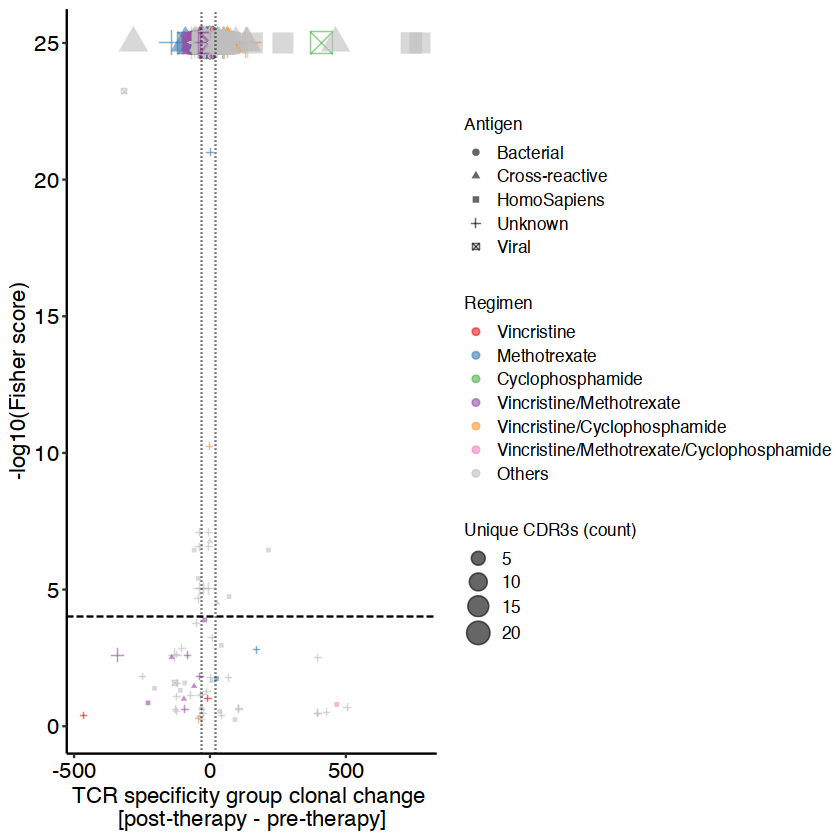

In [60]:
p4

In [61]:
top_patterns <- delta_long$pattern[ delta_long$fisher == 0]

In [62]:
# Build ordered rows from top_patterns and plot
top_df <- delta_long %>%
    dplyr::filter(pattern %in% top_patterns) %>%
    dplyr::arrange(dplyr::desc(Delta)) %>%
    dplyr::mutate(row = dplyr::row_number())

p_top <- ggplot(top_df, aes(x = row, y = Delta)) +
    geom_point(size = 3, aes(color = Regimen)) +
   # geom_text(aes(label = pattern), vjust = -0.6, size = 3) +
    scale_x_continuous(breaks = top_df$row) +
    theme_minimal() +
    myplot + myaxis + 
    theme(axis.text.x = element_blank(),
            axis.title.x = element_blank(), plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    facet_wrap(~Regimen) +
    scale_color_manual(values = colpal) +
    labs(x = "Row (ordered by Delta desc)", y = "Delta", color = "Regimen")

In [63]:
head(top_df)

Patient,pattern,cycle_from,cycle_to,next_cycle_num,MeanFreq_from,MeanFreq_to,Delta,fisher,Regimen,...,CEF,HSV,TB,SP,MCPyV,YFV,antigen,log10fisher,n_patients_with_pattern,row
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>
CHP_405,EVS,X04,X05,5,9.20000,781.50,772.3000,0,Others,...,0,0,0,0,0,0,HomoSapiens,25,17,1
CHP_413,AGW,X01,X02,2,18.00000,759.00,741.0000,0,Others,...,0,0,0,0,0,0,HomoSapiens,25,18,2
CHP_405,PTL,X04,X05,5,9.20000,471.00,461.8000,0,Others,...,0,0,0,0,0,0,Cross-reactive,25,19,3
CHP_418,LRGA,X01,X02,2,13.66667,424.00,410.3333,0,Cyclophosphamide,...,0,0,0,0,1,0,Viral,25,19,4
CHP_405,GWA,X04,X05,5,9.20000,277.50,268.3000,0,Others,...,0,0,0,0,0,0,HomoSapiens,25,17,5
CHP_413,EVS,X01,X02,2,18.00000,173.75,155.7500,0,Others,...,0,0,0,0,0,0,HomoSapiens,25,17,6


In [258]:
# Save the 'delta_long' dataframe as a PDF with a wide width
pdf(paste0(plotpath, "delta_long_wide.pdf"), width = 20, height = 20)
p_top
dev.off()



pdf 
  2

In [67]:
head(df_sub)

Patient,pattern,cycle_from,cycle_to,next_cycle_num,MeanFreq_from,MeanFreq_to,Delta,fisher,Regimen,...,HS,CEF,HSV,TB,SP,MCPyV,YFV,antigen,log10fisher,n_patients_with_pattern
<chr>,<fct>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>
CHP_369,AEV,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,1,0,Viral,25,17
CHP_369,AEVS,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Unknown,25,17
CHP_369,AGW,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,3,0,0,0,0,0,0,HomoSapiens,25,18
CHP_369,AGWA,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Unknown,25,17
CHP_369,APE,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Viral,25,17
CHP_369,APES,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Unknown,25,17


In [ ]:
# # Pairwise test (Wilcoxon) and boxplot of Delta across Regimen per pattern in top_patterns

# library(dplyr)
# library(tidyr)
# library(ggplot2)

# df_sub <- delta_long %>%
#   dplyr::filter(pattern %in% top_patterns, !is.na(Delta), !is.na(Regimen))

# # Order facets by descending median Delta
# pattern_order <- df_sub %>%
#   dplyr::group_by(pattern) %>%
#   dplyr::summarise(median_Delta = median(Delta, na.rm = TRUE), .groups = "drop") %>%
#   dplyr::arrange(dplyr::desc(median_Delta)) %>%
#   dplyr::pull(pattern)

# df_sub <- df_sub %>%
#   dplyr::mutate(pattern = factor(pattern, levels = pattern_order))

# # Safe per-antigen pairwise Wilcoxon tests (BH-adjusted), using only delta_long
# pairwise_results <- df_sub %>%
#   dplyr::group_by(antigen) %>%
#   dplyr::group_modify(~{
#     dat <- .x
#     if (dplyr::n_distinct(dat$Regimen) <= 2L || nrow(dat) <= 3L) {
#       return(tibble(group1 = NA_character_, group2 = NA_character_, p.adj = NA_real_))
#     }
#     res <- try(stats::pairwise.wilcox.test(dat$Delta, dat$Regimen, p.adjust.method = "BH", exact = FALSE), silent = TRUE)
#     if (inherits(res, "try-error") || is.null(res$p.value)) {
#       return(tibble(group1 = NA_character_, group2 = NA_character_, p.adj = NA_real_))
#     }
#     as.data.frame(as.table(res$p.value), stringsAsFactors = FALSE) %>%
#       tidyr::drop_na(Freq) %>%
#       dplyr::rename(group1 = Var1, group2 = Var2, p.adj = Freq)
#   }) %>%
#   dplyr::ungroup()

# # Print (optional): head(pairwise_results)

# # Boxplot + jitter, faceted by pattern
# p_box <- ggplot(df_sub, aes(x = Regimen, y = Delta, color = Regimen)) +
#   geom_boxplot(outlier.shape = NA, alpha = 0.35) +
#   geom_jitter(width = 0.15, alpha = 0.6) +
#   facet_wrap(~ antigen, scales = "free_y") +
#   theme_minimal() +
#   scale_color_manual(values = colpal) +
#   theme(legend.position = "top") +
#   #myplot + myaxis +
#   labs(x = "Regimen", y = "Delta", color = "Regimen")

# # Print plot
# # p_box

In [ ]:
# table(df_sub$Regimen[ df_sub$antigen == "HomoSapiens"])


                              Vincristine 
                                       13 
                             Methotrexate 
                                       53 
                         Cyclophosphamide 
                                        0 
                 Vincristine/Methotrexate 
                                       26 
             Vincristine/Cyclophosphamide 
                                       81 
Vincristine/Methotrexate/Cyclophosphamide 
                                        1 
                                   Others 
                                      127 

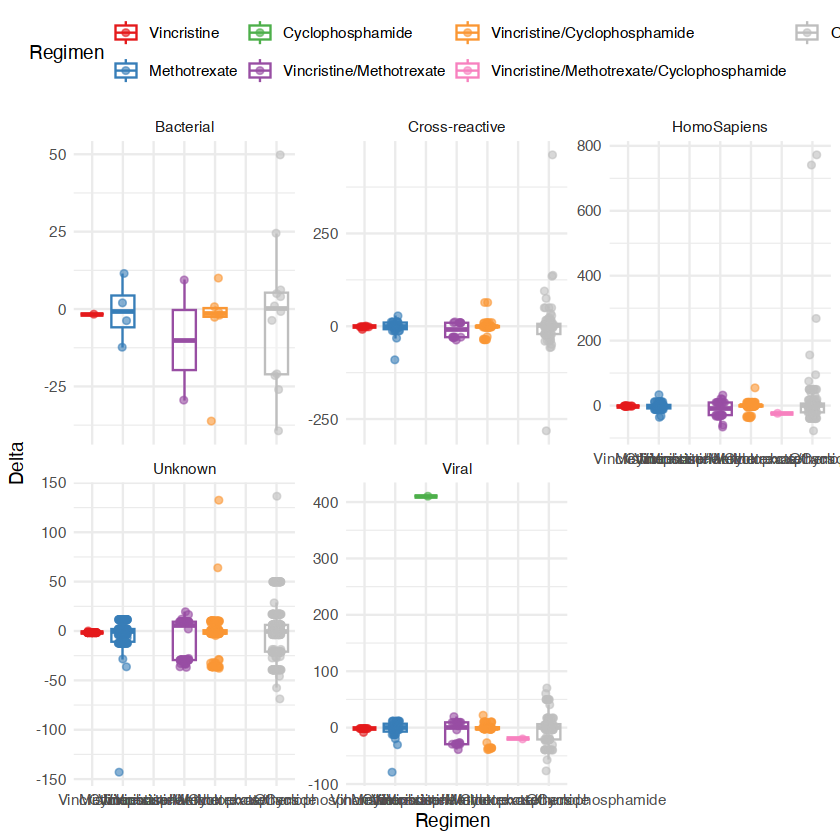

In [ ]:
# p_box

In [ ]:
# pairwise_results %>% dplyr::arrange(p.adj)

antigen,group1,group2,p.adj
<chr>,<chr>,<chr>,<dbl>
HomoSapiens,Vincristine/Methotrexate/Cyclophosphamide,Vincristine,0.01311131
Unknown,Vincristine/Methotrexate,Methotrexate,0.08035369
Unknown,Others,Vincristine/Cyclophosphamide,0.08035369
Unknown,Others,Vincristine,0.12844295
Viral,Cyclophosphamide,Vincristine,0.36437662
Viral,Vincristine/Methotrexate/Cyclophosphamide,Vincristine,0.36437662
Viral,Cyclophosphamide,Methotrexate,0.36437662
Viral,Vincristine/Methotrexate,Cyclophosphamide,0.36437662
Viral,Vincristine/Cyclophosphamide,Cyclophosphamide,0.36437662


In [ ]:
# tmp <- df_sub[ df_sub$pattern == "AEVS",]

In [ ]:
# pairwise.wilcox.test(tmp$Delta, tmp$Regimen, p.adjust.method = "none", exact = FALSE)


	Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

data:  tmp$Delta and tmp$Regimen 

                             Vincristine Methotrexate Vincristine/Methotrexate
Methotrexate                 1.00        -            -                       
Vincristine/Methotrexate     1.00        1.00         -                       
Vincristine/Cyclophosphamide 1.00        0.92         0.87                    
Others                       0.87        1.00         1.00                    
                             Vincristine/Cyclophosphamide
Methotrexate                 -                           
Vincristine/Methotrexate     -                           
Vincristine/Cyclophosphamide -                           
Others                       0.70                        

P value adjustment method: none 

In [ ]:
# pairwise_results %>% dplyr::arrange(p.adj)

# 4- Fraction of cdr3s with antigen specificity in each sample per regimen

In [138]:
samples_tcr_freq <- readr::read_rds( file = paste0(datapath, "GLIPH/int_samples_gliph_tigerdb_annot_freq_stat.rds"))
gliphdf_freq <- readr::read_rds(file = paste0(datapath, "GLIPH/gliph_tigerdb_annot_freq_stat.rds"))

In [139]:
# # bucket all postchemo together
# samples_tcr_freq$group <-NA
# samples_tcr_freq$group[ samples_tcr_freq$cycle == "X01"] <- "pre"
# samples_tcr_freq$group[ samples_tcr_freq$cycle != "X01"] <- "post"
# samples_tcr_freq$group <- factor(samples_tcr_freq$group, levels = c("pre", "post"))

In [140]:
samples_tcr_freq$sample_id <- rownames(samples_tcr_freq)

In [ ]:
samples_tcr_freq$Relapse <- meta_div$Relapse[ match(samples_tcr_freq$sample_id, meta_div$basename) ]
samples_tcr_freq$Regimen <- meta_div$regimen[ match(samples_tcr_freq$sample_id, meta_div$basename) ]
# samples_tcr_freq$Regimen <- meta_div[ match(samples_tcr_freq$sample_id, meta_div$basename) ]

In [271]:
sampletype <- "PBMC"
# cancergroup <- "Leukemia"

df1 <- samples_tcr_freq[ samples_tcr_freq$sampletype == sampletype,]
# df1 <- df1[ df1$cancergroup == cancergroup,]

In [272]:
colnames(df1)

[1] "CMV"               "EBV"               "HCV"              
 [4] "HSV"               "Influenza"         "Human"            
 [7] "HPV"               "CEF"               "TB"               
[10] "MCPyV"             "SP"                "HTLV1"            
[13] "YFV"               "n_cdr3"            "cdr3_reads"       
[16] "n_gliph"           "n_cdr3ingliph"     "cdr3reads_ingliph"
[19] "Patient"           "cycle"             "sampletype"       
[22] "cancergroup"       "Age"               "sample_id"        
[25] "Relapse"           "Regimen"

In [273]:
# Inputs
target_regimen <- "Vincristine/Methotrexate"  # set your regimen of interest
antigens <- c("Human", 'CMV','EBV','HCV','HPV',"HSV",'MCPyV','Influenza', "YFV", "CEF")

library(dplyr)
library(tidyr)
library(ggplot2)
# Create _frac columns if missing (assumes base antigen counts + cdr3_reads)
frac_cols_exist <- all(paste0(antigens, "_frac") %in% names(df1))
if (!frac_cols_exist) {
  for (ag in antigens) {
    col_ag <- ag
    if (!col_ag %in% names(df1)) next
    df1[[paste0(ag, "_frac")]] <- df1[[col_ag]] / df1$cdr3_reads
  }
}


In [277]:
df_reg <- df1 %>%
  filter(Regimen == target_regimen) %>%
  select(Sample = sample_id, Patient, cycle, Regimen, all_of(paste0(antigens, "_frac"))) %>%
  mutate(cycle_num = to_num(cycle))

In [274]:
# Helper to extract numeric cycle index (X01 -> 1, etc.)
to_num <- function(x) as.integer(gsub("\\D", "", x))

# Keep only rows for the target regimen
df_reg <- df1 %>%
  filter(Regimen == target_regimen) %>%
  select(Sample = sample_id, Patient, cycle, Regimen, all_of(paste0(antigens, "_frac"))) %>%
  mutate(cycle_num = to_num(cycle))

# Build within-patient, within-regimen consecutive cycle pairs
from_tbl <- df_reg %>%
  transmute(Patient, Regimen, cycle_from = cycle, cycle_num_from = cycle_num, across(ends_with("_frac"), identity, .names = "from.{.col}"))

to_tbl <- df_reg %>%
  transmute(Patient, Regimen, cycle_to = cycle, cycle_num_to = cycle_num, across(ends_with("_frac"), identity, .names = "to.{.col}"))

pairs <- from_tbl %>%
  inner_join(to_tbl, by = c("Patient","Regimen"), relationship = "many-to-many") %>%  # safe declaration
  filter(cycle_num_to == cycle_num_from + 1L)


In [278]:
df_reg

,Sample,Patient,cycle,Regimen,Human_frac,CMV_frac,EBV_frac,HCV_frac,HPV_frac,HSV_frac,MCPyV_frac,Influenza_frac,YFV_frac,CEF_frac,cycle_num
,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
CHP-328-05-PBMC-DNA,CHP-328-05-PBMC-DNA,CHP_328,X05,Vincristine/Methotrexate,0.043517679,0.012106021,0.0114127247,0.0017599061,0.016959096,0.0084262173,0.018185697,0.0000000000,0.000000000,0.000000000,5
CHP_319-05-PBMC-DNA,CHP_319-05-PBMC-DNA,CHP_319,X05,Vincristine/Methotrexate,0.000000000,0.000000000,0.0000000000,0.0000000000,0.000000000,0.0000000000,0.000000000,0.0000000000,0.000000000,0.000000000,5
CHP_323-03-PBMC-DNA,CHP_323-03-PBMC-DNA,CHP_323,X03,Vincristine/Methotrexate,0.122834646,0.044094488,0.0377952756,0.0201574803,0.017637795,0.0176377953,0.037795276,0.0000000000,0.000000000,0.000000000,3
CHP_323-05-PBMC-DNA,CHP_323-05-PBMC-DNA,CHP_323,X05,Vincristine/Methotrexate,0.071287129,0.000000000,0.0118811881,0.0000000000,0.000000000,0.0000000000,0.011881188,0.0000000000,0.000000000,0.000000000,5
CHP_331-05-PBMC-DNA,CHP_331-05-PBMC-DNA,CHP_331,X05,Vincristine/Methotrexate,0.023172906,0.014260250,0.0124777184,0.0000000000,0.002673797,0.0026737968,0.002673797,0.0026737968,0.000000000,0.000000000,5
CHP_339-03-PBMC-DNA,CHP_339-03-PBMC-DNA,CHP_339,X03,Vincristine/Methotrexate,0.080327869,0.000000000,0.0000000000,0.0000000000,0.000000000,0.0000000000,0.001639344,0.0000000000,0.000000000,0.000000000,3
CHP_339-05-PBMC-DNA,CHP_339-05-PBMC-DNA,CHP_339,X05,Vincristine/Methotrexate,0.040033831,0.017902453,0.0122638850,0.0059204962,0.022272343,0.0122638850,0.015365097,0.0009867494,0.000000000,0.000000000,5
CHP_340-03-PBMC-DNA,CHP_340-03-PBMC-DNA,CHP_340,X03,Vincristine/Methotrexate,0.084622384,0.024340309,0.0243403094,0.0000000000,0.024340309,0.0243403094,0.030254777,0.0129663330,0.000000000,0.000000000,3
CHP_340-05-PBMC-DNA,CHP_340-05-PBMC-DNA,CHP_340,X05,Vincristine/Methotrexate,0.067398330,0.016226771,0.0185833558,0.0082817129,0.014678158,0.0044438459,0.020805279,0.0018852680,0.003164557,0.000000000,5


In [275]:
head(pairs[ pairs$Patient == "CHP_338",c("Regimen","cycle_from", "cycle_to", "cycle_num_from", "cycle_num_to", "from.CMV_frac", "to.CMV_frac")])

Regimen,cycle_from,cycle_to,cycle_num_from,cycle_num_to,from.CMV_frac,to.CMV_frac
<fct>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>


In [157]:
# Long format: two timepoints (from/to) per pair, per antigen
pairs_long_from <- pairs %>%
  select(Patient, Regimen, cycle_from, cycle_to, starts_with("from.")) %>%
  pivot_longer(starts_with("from."),
               names_to = "var", values_to = "fraction") %>%
  mutate(antigen = sub("^from\\.(.+)_frac$", "\\1", var),
         timepoint = "from",
         cycle = cycle_from) %>%
  select(Patient, Regimen, interval = cycle_to, cycle, antigen, timepoint, fraction)

  pairs_long_to <- pairs %>%
  select(Patient, Regimen, cycle_from, cycle_to, starts_with("to.")) %>%
  pivot_longer(starts_with("to."),
               names_to = "var", values_to = "fraction") %>%
  mutate(antigen = sub("^to\\.(.+)_frac$", "\\1", var),
         timepoint = "to",
         cycle = cycle_to) %>%
  select(Patient, Regimen, interval = cycle_to, cycle, antigen, timepoint, fraction)

pairs_long <- bind_rows(pairs_long_from, pairs_long_to) %>%
  filter(antigen %in% antigens) %>%
  mutate(
    antigen = factor(antigen, levels = antigens),
    # Pair ID to connect lines: patient + interval (Xk->Xk+1)
    pair_id = paste(Patient, interval, sep = "_"),
    # Order x-axis within facet by actual cycle order
    cycle_order = to_num(cycle)
  )


In [159]:
head(pairs_long[ pairs_long$Patient == "CHP_369" & pairs_long$antigen == "CMV",])

Patient,Regimen,interval,cycle,antigen,timepoint,fraction,pair_id,cycle_order
<chr>,<fct>,<chr>,<chr>,<fct>,<chr>,<dbl>,<chr>,<int>
CHP_369,Others,X02,X01,CMV,from,0.004976162,CHP_369_X02,1
CHP_369,Others,X02,X02,CMV,to,0.014686248,CHP_369_X02,2


In [ ]:
# tmp <- pairs_long %>%
#   select(Patient, antigen, interval, timepoint, fraction) %>%
#   filter(!is.na(fraction)) %>%
#   pivot_wider(names_from = timepoint, values_from = fraction) 

In [ ]:
# wilcox.test(tmp$to[tmp$antigen == "CMV"], tmp$from[tmp$antigen == "CMV"], paired = TRUE)$p.value

Warning message in wilcox.test.default(tmp$to[tmp$antigen == "CMV"], tmp$from[tmp$antigen == :
"cannot compute exact p-value with zeroes"


[1] 0.3473586

In [178]:
# Paired Wilcoxon tests per antigen and interval (to vs from), paired by Patient
wilcox_results <- pairs_long %>%
  select(Patient, antigen, interval, timepoint, fraction) %>%
  filter(!is.na(fraction)) %>%
  pivot_wider(names_from = timepoint, values_from = fraction) %>%
  group_by(antigen) %>%
  summarise(
    n_pairs = sum(!is.na(from) & !is.na(to)),
    p = if (n_pairs >= 2) tryCatch(wilcox.test(to, from, paired = TRUE)$p.value, error = function(e) NA_real_) else NA_real_,
    .groups = "drop"
  ) %>%
   group_by(antigen) %>%
  mutate(p_adj = p.adjust(p, method = "BH")) %>%
  ungroup()

Warning message:
"There were 16 warnings in `summarise()`.
The first warning was:
i In argument: `p = if (...) NULL`.
i In group 1: `antigen = CMV`.
Caused by warning in `wilcox.test.default()`:
! cannot compute exact p-value with zeroes
i Run `dplyr::last_dplyr_warnings()` to see the 15 remaining warnings."


In [179]:
wilcox_results

antigen,n_pairs,p,p_adj
<fct>,<int>,<dbl>,<dbl>
CMV,27,0.34735856,0.34735856
EBV,27,0.20120143,0.20120143
HCV,27,0.11655196,0.11655196
Influenza,27,0.81387506,0.81387506
Human,27,0.54215898,0.54215898
HSV,27,0.18852823,0.18852823
CEF,27,0.83393541,0.83393541
YFV,27,1.00000000,1.00000000
HPV,27,0.09137019,0.09137019


In [190]:
head(pairs_long)

Patient,Regimen,interval,cycle,antigen,timepoint,fraction,pair_id,cycle_order
<chr>,<fct>,<chr>,<chr>,<fct>,<chr>,<dbl>,<chr>,<int>
CHP_369,Others,X02,X01,CMV,from,4.976162e-03,CHP_369_X02,1
CHP_369,Others,X02,X01,EBV,from,2.360890e-03,CHP_369_X02,1
CHP_369,Others,X02,X01,HCV,from,1.304206e-02,CHP_369_X02,1
CHP_369,Others,X02,X01,Influenza,from,4.287331e-05,CHP_369_X02,1
CHP_369,Others,X02,X01,Human,from,5.473493e-02,CHP_369_X02,1
CHP_369,Others,X02,X01,HSV,from,7.831525e-04,CHP_369_X02,1


In [ ]:
pairs_long$antigen <- factor(pairs_long$antigen, 
levels = c("Human", 'CMV','EBV','HCV','HPV',"HSV",'MCPyV','Influenza', "YFV", "CEF"))

In [195]:
# Plot: paired points + connecting lines and boxplot, x axis is "timepoint" (from/to), facet only by antigen
p_regimen <- ggplot(pairs_long, aes(x = factor(timepoint, levels = c("from", "to")),
                                    y = fraction)) +
  geom_line(aes(color = Regimen, group = pair_id),alpha = 0.35) +
  geom_point(alpha = 0.7) +
  geom_boxplot(aes(group = timepoint), inherit.aes = TRUE,
               outlier.shape = NA, alpha = 0.25) +
  facet_grid(. ~ antigen, scales = "free_y") +
  theme_minimal() +
  theme(legend.position = "top",
        axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x = "Timepoint", y = "Antigen fraction", color = "Regimen")
# Add p-value annotation only for those < 0.15
library(ggsignif)

# Get antigens with adjusted p < 0.15
annot_sig <- wilcox_results %>% 
    filter(p_adj < 0.15 & !is.na(p_adj)) %>%
    mutate(label = ifelse(p_adj < 0.01, sprintf("p = %.2e", p_adj), sprintf("p = %.3f", p_adj)))

# Add annotation to plot: make a data frame for geom_signif
if (nrow(annot_sig) > 0) {
  signif_df <- data.frame(
    antigen = annot_sig$antigen,
    y_position = sapply(annot_sig$antigen, function(a) {
      max(pairs_long$fraction[pairs_long$antigen == a], na.rm = TRUE)
    }) * 1.08,
    label = annot_sig$label
  )

  p_regimen <- p_regimen +
    geom_signif(
      data = signif_df,
      aes(xmin = 1, xmax = 2, annotations = label, y_position = y_position),
      manual = TRUE,
      textsize = 3.2,
      tip_length = 0.015
    )
}

# Print results and plot
# wilcox_results
# p_regimen

Warning message in geom_signif(data = signif_df, aes(xmin = 1, xmax = 2, annotations = label, :
"Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position"


In [196]:
head(pairs_long)

Patient,Regimen,interval,cycle,antigen,timepoint,fraction,pair_id,cycle_order
<chr>,<fct>,<chr>,<chr>,<fct>,<chr>,<dbl>,<chr>,<int>
CHP_369,Others,X02,X01,CMV,from,4.976162e-03,CHP_369_X02,1
CHP_369,Others,X02,X01,EBV,from,2.360890e-03,CHP_369_X02,1
CHP_369,Others,X02,X01,HCV,from,1.304206e-02,CHP_369_X02,1
CHP_369,Others,X02,X01,Influenza,from,4.287331e-05,CHP_369_X02,1
CHP_369,Others,X02,X01,Human,from,5.473493e-02,CHP_369_X02,1
CHP_369,Others,X02,X01,HSV,from,7.831525e-04,CHP_369_X02,1


In [197]:
annot_sig

antigen,n_pairs,p,p_adj,label
<fct>,<int>,<dbl>,<dbl>,<chr>
HCV,27,0.11655196,0.11655196,p = 0.117
HPV,27,0.09137019,0.09137019,p = 0.091


In [198]:
    # ggsignif::geom_signif(
    #     data = sig_wilcox_mat,
    #     aes(xmin = 1, xmax = 2, annotations = p.val, y_position = 0.14),
    #     textsize = 3, vjust = -0.2, color = "black",
    #     manual = TRUE
    # )

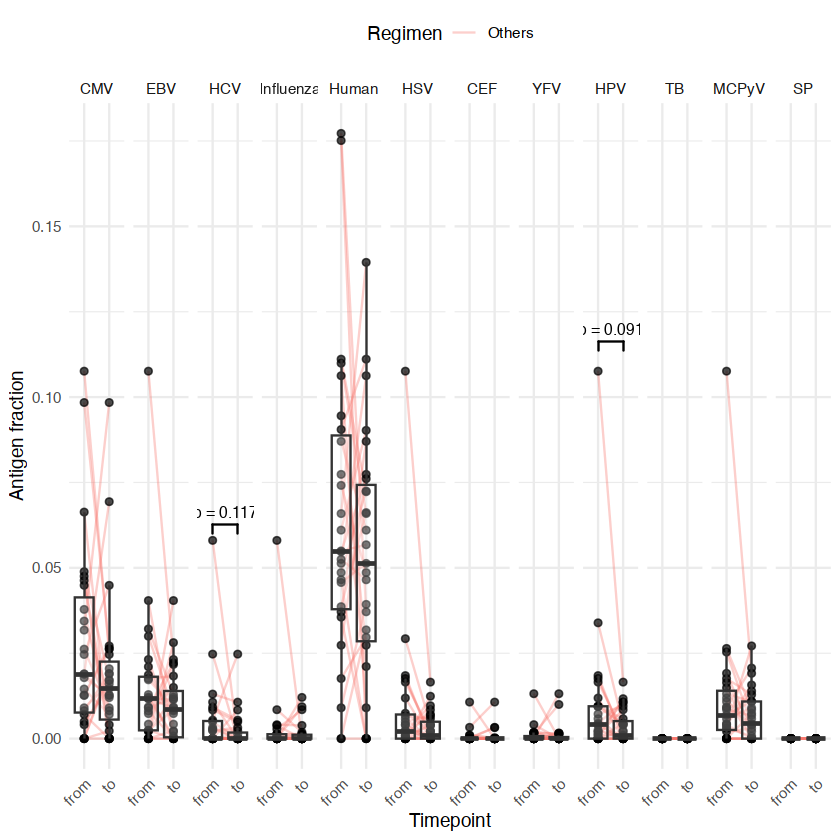

In [199]:
p_regimen

In [227]:
make_regimen_paired_antigen_plot <- function(data, target_regimen,
                                             antigens = c("Human","CMV","EBV","HCV","HPV","HSV","MCPyV","Influenza","YFV","CEF"),
                                             p_alpha = 0.15, adjust_method = "BH") {
  # Dependencies are used with namespace prefixes (no library() needed)

  # Ensure a Regimen column exists
  if (!"Regimen" %in% names(data) && "regimen" %in% names(data)) {
    data <- dplyr::rename(data, Regimen = regimen)
  }

  # Create _frac columns if missing (assumes base antigen counts + cdr3_reads)
  needed_frac <- paste0(antigens, "_frac")
  if (!all(needed_frac %in% names(data)) && "cdr3_reads" %in% names(data)) {
    for (ag in antigens) {
      if (ag %in% names(data) && !(paste0(ag, "_frac") %in% names(data))) {
        data[[paste0(ag, "_frac")]] <- data[[ag]] / data$cdr3_reads
      }
    }
  }

  # Helper: numeric cycle index (e.g., X01 -> 1)
  to_num <- function(x) as.integer(gsub("\\D", "", x))

  # Keep only rows for the target regimen
  df_reg <- data %>%
    dplyr::filter(.data$Regimen == target_regimen) %>%
    dplyr::select(Sample = dplyr::all_of(if ("sample_id" %in% names(.)) "sample_id" else "Sample"),
                  Patient, cycle, Regimen,
                  dplyr::all_of(paste0(antigens, "_frac"))) %>%
    dplyr::mutate(cycle_num = to_num(.data$cycle))

  # If not enough data, return early
  if (nrow(df_reg) == 0) {
    return(list(pairs_long = tibble::tibble(), wilcox_results = tibble::tibble(), plot = ggplot2::ggplot()))
  }

  # Build within-patient, within-regimen consecutive cycle pairs
  from_tbl <- df_reg %>%
    dplyr::transmute(Patient, Regimen,
                     cycle_from = .data$cycle, cycle_num_from = .data$cycle_num,
                     dplyr::across(tidyselect::ends_with("_frac"), identity, .names = "from.{.col}"))

  to_tbl <- df_reg %>%
    dplyr::transmute(Patient, Regimen,
                     cycle_to = .data$cycle, cycle_num_to = .data$cycle_num,
                     dplyr::across(tidyselect::ends_with("_frac"), identity, .names = "to.{.col}"))

  # Join all pairs inside patient+regimen, then keep only consecutive (k -> k+1)
  # Declare relationship = "many-to-many" to silence warnings when multiple samples exist per cycle
  pairs <- try(
    from_tbl %>%
      dplyr::inner_join(to_tbl, by = c("Patient","Regimen"), relationship = "many-to-many") %>%
      dplyr::filter(.data$cycle_num_to == .data$cycle_num_from + 1L),
    silent = TRUE
  )

  if (inherits(pairs, "try-error")) {
    # Fallback for older dplyr without `relationship` arg
    pairs <- from_tbl %>%
      dplyr::inner_join(to_tbl, by = c("Patient","Regimen")) %>%
      dplyr::filter(.data$cycle_num_to == .data$cycle_num_from + 1L)
  }

  if (nrow(pairs) == 0) {
    return(list(pairs_long = tibble::tibble(), wilcox_results = tibble::tibble(), plot = ggplot2::ggplot()))
  }

  # Long format: two timepoints (from/to) per pair, per antigen
  pairs_long_from <- pairs %>%
    dplyr::select(Patient, Regimen, cycle_from, cycle_to, tidyselect::starts_with("from.")) %>%
    tidyr::pivot_longer(tidyselect::starts_with("from."),
                        names_to = "var", values_to = "fraction") %>%
    dplyr::mutate(antigen = sub("^from\\.(.+)_frac$", "\\1", .data$var),
                  timepoint = "from",
                  cycle = .data$cycle_from) %>%
    dplyr::select(Patient, Regimen, interval = .data$cycle_to, cycle, antigen, timepoint, fraction)

  pairs_long_to <- pairs %>%
    dplyr::select(Patient, Regimen, cycle_from, cycle_to, tidyselect::starts_with("to.")) %>%
    tidyr::pivot_longer(tidyselect::starts_with("to."),
                        names_to = "var", values_to = "fraction") %>%
    dplyr::mutate(antigen = sub("^to\\.(.+)_frac$", "\\1", .data$var),
                  timepoint = "to",
                  cycle = .data$cycle_to) %>%
    dplyr::select(Patient, Regimen, interval = .data$cycle_to, cycle, antigen, timepoint, fraction)

  pairs_long <- dplyr::bind_rows(pairs_long_from, pairs_long_to) %>%
    dplyr::filter(.data$antigen %in% antigens) %>%
    dplyr::mutate(
      antigen = factor(.data$antigen, levels = antigens),
      pair_id = paste(.data$Patient, .data$interval, sep = "_"),
      cycle_order = to_num(.data$cycle)
    )

  # Paired Wilcoxon tests per antigen (to vs from), paired by Patient
  wilcox_results <- pairs_long %>%
    dplyr::select(Patient, antigen, interval, timepoint, fraction) %>%
    dplyr::filter(!is.na(.data$fraction)) %>%
    tidyr::pivot_wider(names_from = timepoint, values_from = fraction) %>%
    dplyr::group_by(antigen) %>%
    dplyr::summarise(
      n_pairs = sum(!is.na(.data$from) & !is.na(.data$to)),
      p = if (n_pairs >= 2)
        tryCatch(stats::wilcox.test(.data$to, .data$from, paired = TRUE)$p.value, error = function(e) NA_real_)
      else NA_real_,
      .groups = "drop"
    ) %>%
    #dplyr::group_by(antigen) %>%
    dplyr::mutate(p_adj = p.adjust(.data$p, method = adjust_method)) %>%
    dplyr::ungroup()

  # Base plot (paired points + lines, plus boxplot), x = timepoint, facet by antigen
  p <- ggplot2::ggplot(pairs_long, ggplot2::aes(x = factor(.data$timepoint, levels = c("from", "to")),
                                                y = .data$fraction)) +
    ggplot2::geom_line(ggplot2::aes(color = .data$Regimen, group = .data$pair_id), alpha = 0.35) +
    ggplot2::geom_point(alpha = 0.7) +
    ggplot2::geom_boxplot(ggplot2::aes(group = .data$timepoint), inherit.aes = TRUE,
                          outlier.shape = NA, alpha = 0.25) +
    ggplot2::facet_grid(. ~ antigen, scales = "free_y") +
    ggplot2::theme_minimal() +
    ggplot2::theme(legend.position = "top",
                   axis.text.x = ggplot2::element_text(angle = 45, hjust = 1)) +
    ggplot2::labs(x = "Timepoint", y = "Antigen fraction", color = "Regimen")

  # Annotate adjusted p-values < p_alpha
  annot_sig <- wilcox_results %>%
    dplyr::filter(!is.na(.data$p_adj) & .data$p_adj < p_alpha) %>%
    dplyr::mutate(label = dplyr::if_else(.data$p_adj < 0.01,
                                         sprintf("p = %.2e", .data$p_adj),
                                         sprintf("p = %.3f", .data$p_adj)))

  if (nrow(annot_sig) > 0) {
    # y-position per antigen: a bit above the max
    y_map <- sapply(levels(pairs_long$antigen), function(a) {
      vals <- pairs_long$fraction[pairs_long$antigen == a]
      if (all(is.na(vals))) return(NA_real_)
      max(vals, na.rm = TRUE) * 1.08
    })
    signif_df <- data.frame(
      antigen = annot_sig$antigen,
      y_position = y_map[as.character(annot_sig$antigen)],
      label = annot_sig$label
    )
    # Only annotate where we have a finite y
    signif_df <- signif_df[is.finite(signif_df$y_position), , drop = FALSE]

    if (nrow(signif_df) > 0) {
      p <- p +
        ggsignif::geom_signif(
          data = signif_df,
          ggplot2::aes(xmin = 1, xmax = 2, annotations = .data$label, y_position = .data$y_position),
          manual = TRUE,
          textsize = 3.2,
          tip_length = 0.015
        )
    }
  }

  list(pairs_long = pairs_long, wilcox_results = wilcox_results, plot = p)
}

# Example usage:
# res <- make_regimen_paired_antigen_plot(df1, target_regimen = "Others")
# res$wilcox_results
# res$plot

In [247]:
table(df1$Regimen)


                              Vincristine 
                                       26 
                             Methotrexate 
                                       23 
                         Cyclophosphamide 
                                        5 
                 Vincristine/Methotrexate 
                                       27 
             Vincristine/Cyclophosphamide 
                                       49 
Vincristine/Methotrexate/Cyclophosphamide 
                                        5 
                                   Others 
                                       40 

In [254]:
sampletype <- "PBMC"
# cancergroup <- "Leukemia"

df1 <- samples_tcr_freq[ samples_tcr_freq$sampletype == sampletype,]

In [267]:
res <- make_regimen_paired_antigen_plot(df1, target_regimen = "Vincristine/Methotrexate", 
                        antigens = c("Human","CMV","EBV","HCV","HPV","HSV","MCPyV","Influenza"))
# 

In [269]:
res$pairs_long

<0 x 0 matrix>

<0 x 0 matrix>

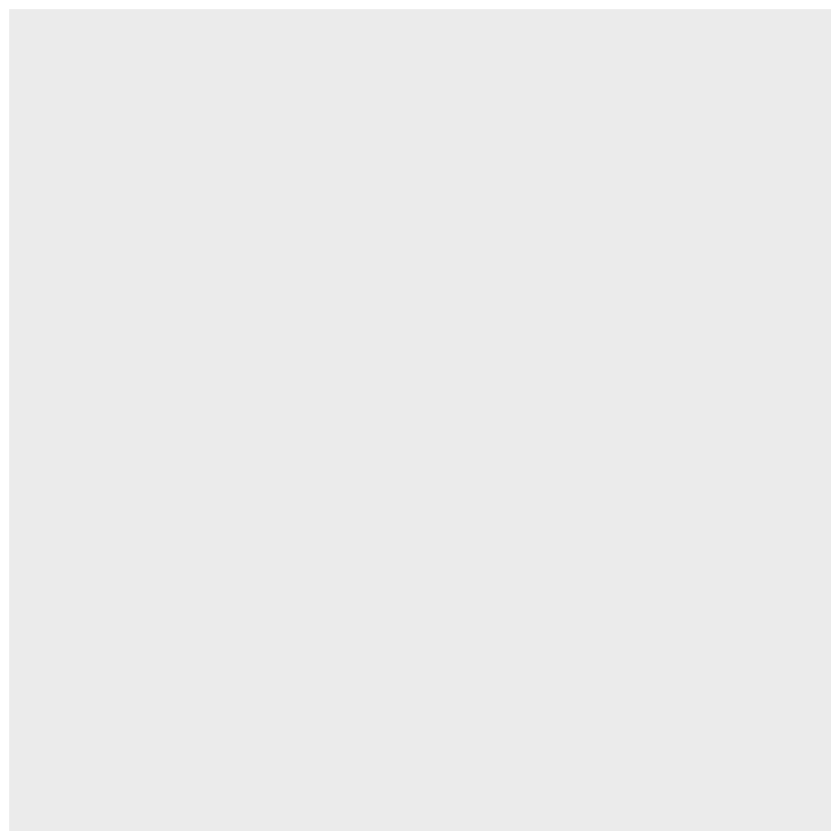

In [268]:
res$plot
res$wilcox_results

### PBMC

Leukemia

In [119]:
head(samples_tcr_freq)

,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,...,n_cdr3ingliph,cdr3reads_ingliph,Patient,cycle,sampletype,cancergroup,Age,group,sample_id,Relapse
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>,<int>
CHP-328-04-PBMC-DNA,1727,2684,0,28,0,13527,1211,0,0,1114,...,125,98929,CHP_328,X04,PBMC,Leukemia,7.0,post,CHP-328-04-PBMC-DNA,0
CHP-328-05-PBMC-DNA,227,214,33,158,0,816,318,0,0,341,...,34,15470,CHP_328,X05,PBMC,Leukemia,7.0,post,CHP-328-05-PBMC-DNA,0
CHP-351-03-PBMC-DNA,895,722,1280,284,538,6260,993,207,0,648,...,248,66508,CHP_351,X03,PBMC,Solid tumors,7.0,post,CHP-351-03-PBMC-DNA,0
CHP-369-01-PBMC-DNA,1741,826,4563,274,15,19150,401,367,0,1075,...,183,160268,CHP_369,X01,PBMC,Leukemia,0.1,pre,CHP-369-01-PBMC-DNA,0
CHP-377-02-PBMC-DNA,508,1040,0,10,0,2021,181,0,0,736,...,96,15269,CHP_377,X02,PBMC,Leukemia,18.0,post,CHP-377-02-PBMC-DNA,1
CHP-411-02-PBMC-DNA,1857,378,592,170,0,5598,87,94,0,458,...,294,55414,CHP_411,X02,PBMC,Leukemia,16.0,post,CHP-411-02-PBMC-DNA,1


In [90]:
sampletype <- "PBMC"
cancergroup <- "Leukemia"

df1 <- samples_tcr_freq[ samples_tcr_freq$sampletype == sampletype,]
df1 <- df1[ df1$cancergroup == cancergroup,]

In [91]:
# get patients with more than one timepoiint and a baseline
mytab <- table(df1$Patient, df1$cycle)
mytab <- mytab[rowSums(mytab != 0) > 1, ]
baseline_patients <- rownames(mytab)[mytab[, 1] > 0]
df1_baseline <- df1[df1$Patient %in% baseline_patients, ]

In [92]:
head(df1_baseline$cdr3_reads)

[1] 349868   5874   5982   1308    810   1122

In [93]:
myantigens <- colnames(df1_baseline)[1:13]
myantigens

[1] "CMV"       "EBV"       "HCV"       "HSV"       "Influenza" "Human"    
 [7] "HPV"       "CEF"       "TB"        "MCPyV"     "SP"        "HTLV1"    
[13] "YFV"

In [94]:
# generate pre samples for each additional post sample
for( i in unique(df1_baseline$Patient)){
    mypt <- df1_baseline[ df1_baseline$Patient == i, ]
    n_post <- nrow(mypt[ mypt$cycle != "X01", ])
    df1_baseline <- rbind(df1_baseline, mypt[ mypt$cycle == "X01", ][rep(1, n_post-1), ])
}

In [95]:
for (i in 1:length(myantigens)) {
    myvar <- paste0(myantigens[i], "_frac")
    df1_baseline[[myvar]] <- NA
    df1_baseline[[myvar]] <- df1_baseline[,i] / df1_baseline$cdr3_reads
}

In [96]:
  # generate an a unique ID between each pairs of pre and post
df1_baseline$ID <- NA
df1_baseline_id <- df1_baseline[0,]

  for( i in unique(df1_baseline$Patient)){  
    mypt <- df1_baseline[ df1_baseline$Patient == i, ]
    n_pre <- nrow(mypt[ mypt$cycle == "X01", ])
    mypt$ID[mypt$group == "pre"] <- paste0(mypt$Patient[mypt$group == "pre"], "_", rep(1:n_pre))
    mypt$ID[mypt$group == "post"] <- paste0(mypt$Patient[mypt$group == "pre"], "_", rep(1:n_pre))
    df1_baseline_id <- rbind(df1_baseline_id, mypt)
  }

In [97]:
# head(df1_baseline_id[ df1_baseline_id$Human_frac > 1,1:18])

In [98]:
myantigens <- c('CMV','EBV','HCV','Influenza','Human',"HSV","CEF", "YFV", "HPV","TB","MCPyV","SP")

In [99]:
wilcox_mat <- matrix(NA, nrow = length(myantigens), ncol = 2, dimnames = list(myantigens, c("antigen", "p")))

In [100]:
message("CMV")
tapply(df1_baseline_id$CMV_frac, df1_baseline_id$group, summary)
message("Human")
tapply(df1_baseline_id$Human_frac, df1_baseline_id$group, summary)
message("MCPyV")
tapply(df1_baseline_id$MCPyV_frac, df1_baseline_id$group, summary)
message("HCV")
tapply(df1_baseline_id$HCV_frac, df1_baseline_id$group, summary)

CMV



$pre
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.004141 0.017846 0.024864 0.022090 0.107595 

$post
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.008272 0.012635 0.015244 0.019745 0.046442 


Human



$pre
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.001799 0.021946 0.045711 0.058449 0.064840 0.177215 

$post
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.005348 0.039929 0.050693 0.052677 0.064444 0.106259 


MCPyV



$pre
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.003306 0.010569 0.021934 0.019842 0.107595 

$post
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.002609 0.007130 0.009674 0.012287 0.046914 


HCV



$pre
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.001794 0.004156 0.008589 0.013042 

$post
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0000000 0.0003341 0.0038127 0.0048782 0.0321101 


In [101]:
for(i in 1:length(myantigens)){
    mycol <- paste0(myantigens[i], "_frac")
    mytest <- wilcox.test( eval(as.name(mycol)) ~ group,data = df1_baseline_id, paired = T)
    wilcox_mat[i, "antigen"] <- myantigens[i]
    wilcox_mat[i, "p"] <- mytest$p.value
}

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[

In [102]:
wilcox_mat <- as.data.frame(wilcox_mat)
wilcox_mat$p <- as.numeric(wilcox_mat$p)
wilcox_mat$adjp <- p.adjust(wilcox_mat$p, method = "fdr")

In [103]:
wilcox_mat[order(wilcox_mat$adjp),]

,antigen,p,adjp
,<chr>,<dbl>,<dbl>
HSV,HSV,0.007967213,0.07967213
HPV,HPV,0.048318036,0.24159018
MCPyV,MCPyV,0.104184122,0.34728041
EBV,EBV,0.146054655,0.36513664
CMV,CMV,0.294424194,0.43446082
HCV,HCV,0.259030061,0.43446082
Influenza,Influenza,0.304122575,0.43446082
CEF,CEF,0.422678074,0.52834759
YFV,YFV,0.672378828,0.74708759


In [104]:
sig_wilcox_mat <- wilcox_mat[ which(wilcox_mat$adjp < 0.1),]
sig_wilcox_mat$p.val <- sapply(sig_wilcox_mat$p, function(x) round_and_format(x) )

In [105]:
sig_wilcox_mat

,antigen,p,adjp,p.val
,<chr>,<dbl>,<dbl>,<chr>
HSV,HSV,0.007967213,0.07967213,0.008


In [106]:
# pivot_longer

df1_baseline_long <- df1_baseline_id %>%
    dplyr::select(
        sample_id, Patient, cycle, cancergroup, Age, Relapse, group, ID,
        CMV_frac, EBV_frac, HCV_frac, Influenza_frac, Human_frac, HPV_frac, HSV_frac, MCPyV_frac, YFV_frac, CEF_frac
    ) %>%
    tidyr::pivot_longer(cols = ends_with("_frac"), names_to = "antigen", values_to = "fraction")


In [107]:
df1_baseline_long <- df1_baseline_long[ !is.na(df1_baseline_long$fraction),]

In [108]:
df1_baseline_long$antigen <- gsub("_frac", "", df1_baseline_long$antigen)

In [109]:
df1_baseline_long$antigen <- factor(df1_baseline_long$antigen, 
levels = c("Human", 'CMV','EBV','HCV','HPV',"HSV",'MCPyV','Influenza', "YFV", "CEF"))

In [110]:
head(df1_baseline_long)

sample_id,Patient,cycle,cancergroup,Age,Relapse,group,ID,antigen,fraction
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<fct>,<chr>,<fct>,<dbl>
CHP-369-01-PBMC-DNA,CHP_369,X01,Leukemia,0.1,0,pre,CHP_369_1,CMV,4.976162e-03
CHP-369-01-PBMC-DNA,CHP_369,X01,Leukemia,0.1,0,pre,CHP_369_1,EBV,2.360890e-03
CHP-369-01-PBMC-DNA,CHP_369,X01,Leukemia,0.1,0,pre,CHP_369_1,HCV,1.304206e-02
CHP-369-01-PBMC-DNA,CHP_369,X01,Leukemia,0.1,0,pre,CHP_369_1,Influenza,4.287331e-05
CHP-369-01-PBMC-DNA,CHP_369,X01,Leukemia,0.1,0,pre,CHP_369_1,Human,5.473493e-02
CHP-369-01-PBMC-DNA,CHP_369,X01,Leukemia,0.1,0,pre,CHP_369_1,HPV,1.146147e-03


In [111]:
head(meta_div[ meta_div$Patient == "CHP_413",])

,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,estimated_Simpson,SE_Simpson,basename,file,sampletype,Group,log10shann,sample_id_sampletype,assay,regimen
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>
186,CHP_413_01,CHP_413,X01,4.0,0.00,19,AML,4.0,1985,43,...,26.989158,0.63221853,CHP_413-01_PBMC-DNA,batch12_30Apr2021/mixcr/clones/CLONES_TRBCHP_413-01_PBMC-DNA.txt,PBMC,CHP,1.4450041,CHP_413_01_PBMC,Flow cytometry & capTCR-seq,Others
187,CHP_413_02,CHP_413,X02,3.2,93.42,19,AML,3.2,2525,312,...,145.906624,0.52069465,CHP_413-02_PBMC-DNA,remaining_batch_3_4May2021/mixcr/clones/CLONES_TRBCHP_413-02_PBMC-DNA.txt,PBMC,CHP,2.2681374,CHP_413_02_PBMC,Flow cytometry & capTCR-seq,Others
437,CHP_413_01,CHP_413,X01,4.0,0.00,19,AML,4.0,1985,43,...,3.939760,0.02719615,CHP_413-01_cfDNA,batch11_cfDNA_11Sep2020/mixcr/clones/CLONES_TRBCHP_413-01_cfDNA.txt,cfDNA,CHP,0.5999398,CHP_413_01_cfDNA,capTCR-seq,Others
438,CHP_413_02,CHP_413,X02,3.2,93.42,19,AML,3.2,2525,312,...,2.402157,0.05598501,CHP_413-02_cfDNA,priority_pool3/mixcr/clones/CLONES_TRBCHP_413-02_cfDNA.txt,cfDNA,CHP,0.4943026,CHP_413_02_cfDNA,capTCR-seq,Others


In [112]:
sig_wilcox_mat

,antigen,p,adjp,p.val
,<chr>,<dbl>,<dbl>,<chr>
HSV,HSV,0.007967213,0.07967213,0.008


In [113]:
levels(df1_baseline_long$antigen)

[1] "Human"     "CMV"       "EBV"       "HCV"       "HPV"       "HSV"      
 [7] "MCPyV"     "Influenza" "YFV"       "CEF"

In [114]:
head(df1_baseline_long)

sample_id,Patient,cycle,cancergroup,Age,Relapse,group,ID,antigen,fraction
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<fct>,<chr>,<fct>,<dbl>
CHP-369-01-PBMC-DNA,CHP_369,X01,Leukemia,0.1,0,pre,CHP_369_1,CMV,4.976162e-03
CHP-369-01-PBMC-DNA,CHP_369,X01,Leukemia,0.1,0,pre,CHP_369_1,EBV,2.360890e-03
CHP-369-01-PBMC-DNA,CHP_369,X01,Leukemia,0.1,0,pre,CHP_369_1,HCV,1.304206e-02
CHP-369-01-PBMC-DNA,CHP_369,X01,Leukemia,0.1,0,pre,CHP_369_1,Influenza,4.287331e-05
CHP-369-01-PBMC-DNA,CHP_369,X01,Leukemia,0.1,0,pre,CHP_369_1,Human,5.473493e-02
CHP-369-01-PBMC-DNA,CHP_369,X01,Leukemia,0.1,0,pre,CHP_369_1,HPV,1.146147e-03


In [115]:
df1_baseline_long$label <- NA
df1_baseline_long$label[ df1_baseline_long$fraction > 0.1] <- "X"

In [116]:
df1_baseline_long[ which(df1_baseline_long$label == "X"),]

sample_id,Patient,cycle,cancergroup,Age,Relapse,group,ID,antigen,fraction,label
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<fct>,<chr>,<fct>,<dbl>,<chr>
CHP_357-03-PBMC-DNA,CHP_357,X03,Leukemia,1,0,post,CHP_357_2,Human,0.1062591,X
CHP_405-01_PBMC_DNA,CHP_405,X01,Leukemia,1,0,pre,CHP_405_1,CMV,0.1075949,X
CHP_405-01_PBMC_DNA,CHP_405,X01,Leukemia,1,0,pre,CHP_405_1,EBV,0.1075949,X
CHP_405-01_PBMC_DNA,CHP_405,X01,Leukemia,1,0,pre,CHP_405_1,Human,0.1772152,X
CHP_405-01_PBMC_DNA,CHP_405,X01,Leukemia,1,0,pre,CHP_405_1,HPV,0.1075949,X
CHP_405-01_PBMC_DNA,CHP_405,X01,Leukemia,1,0,pre,CHP_405_1,HSV,0.1075949,X
CHP_405-01_PBMC_DNA,CHP_405,X01,Leukemia,1,0,pre,CHP_405_1,MCPyV,0.1075949,X
CHP_405-01_PBMC_DNA,CHP_405,X01,Leukemia,1,0,pre,CHP_405_2,CMV,0.1075949,X
CHP_405-01_PBMC_DNA,CHP_405,X01,Leukemia,1,0,pre,CHP_405_2,EBV,0.1075949,X


In [117]:
p_sample_cancer <- ggplot(df1_baseline_long, aes(x = group, y = fraction)) +
    geom_point(aes(color = factor(Relapse)), alpha = 0.3, shape = 16) +
    geom_line(aes(group = ID, color = factor(Relapse)), alpha = 0.3) +
    scale_color_manual(values = c("0" = "blue", "1" = "red")) +
    geom_boxplot(fill = "transparent", outlier.shape = NA) +
    myplot +
    myaxis +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
    facet_wrap(~ factor(antigen, levels(df1_baseline_long$antigen)), nrow = 1, scales = "free_x", strip.position = "top") +
    ggsignif::geom_signif(
        data = sig_wilcox_mat,
        aes(xmin = 1, xmax = 2, annotations = p.val, y_position = 0.14),
        textsize = 3, vjust = -0.2, color = "black",
        manual = TRUE
    ) +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    # geom_text_repel(
    #     label = ifelse(df1_baseline_long$label == "X", as.character(df1_baseline_long$Patient), ""),
    #     size = 4, #min.segment.length = 0,
    #     ylim = c(-Inf, Inf),
    #     nudge_y = .006,
    #     arrow = arrow(length = unit(0.1, "npc"))
    # ) +
    ylab("TCR frequencies\nwith antigen annotation") +
    scale_x_discrete(ggpubr::get_breaks("group"),
        labels = c("Pre", "Post")
    )

Warning message in ggsignif::geom_signif(data = sig_wilcox_mat, aes(xmin = 1, xmax = 2, :
"Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position"


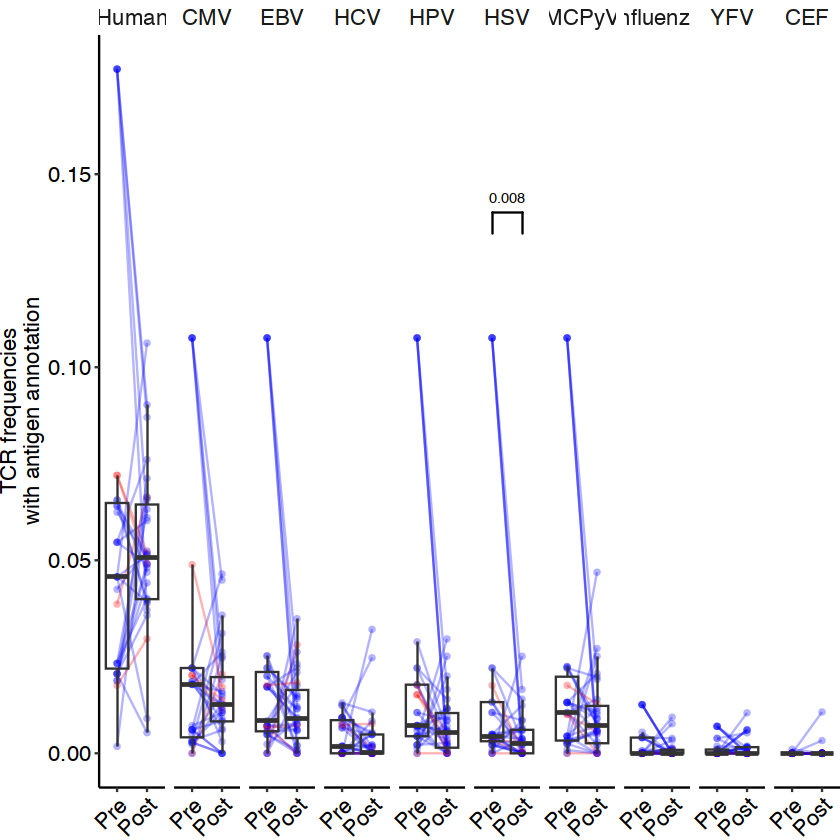

In [118]:
p_sample_cancer

In [43]:
pdf(paste0(plotpath, "antigen_frac_p_leu.pdf"), width = 10, height = 5)
cowplot::plot_grid(p_sample_cancer, labels = "B")
dev.off()


Warning message:
"Removed 432 rows containing missing values or values outside the scale range
(`geom_text_repel()`)."


pdf 
  2

Lymphoma

In [44]:
sampletype <- "PBMC"
cancergroup <- "Lymphoma"

df1 <- samples_tcr_freq[ samples_tcr_freq$sampletype == sampletype,]
df1 <- df1[ df1$cancergroup == cancergroup,]

In [45]:
# get patients with more than one timepoiint and a baseline
mytab <- table(df1$Patient, df1$cycle)
mytab <- mytab[rowSums(mytab != 0) > 1, ]
baseline_patients <- rownames(mytab)[mytab[, 1] > 0]
df1_baseline <- df1[df1$Patient %in% baseline_patients, ]

In [46]:
myantigens <- colnames(df1_baseline)[1:13]

In [47]:
# generate pre samples for each additional post sample
for( i in unique(df1_baseline$Patient)){
    mypt <- df1_baseline[ df1_baseline$Patient == i, ]
    n_post <- nrow(mypt[ mypt$cycle != "X01", ])
    df1_baseline <- rbind(df1_baseline, mypt[ mypt$cycle == "X01", ][rep(1, n_post-1), ])
}

In [48]:
for (i in 1:length(myantigens)) {
    myvar <- paste0(myantigens[i], "_frac")
    df1_baseline[[myvar]] <- NA
    df1_baseline[[myvar]] <- df1_baseline[,i] / df1_baseline$cdr3_reads
}

In [49]:
df1_baseline[ grepl("CHP_366", rownames(df1_baseline)),]

,CMV,EBV,HCV,Influenza,HomoSapiens,MDavis,HPV,CEF,TB,MCPyV,...,Influenza_frac,HomoSapiens_frac,MDavis_frac,HPV_frac,CEF_frac,TB_frac,MCPyV_frac,SP_frac,HTLV1_frac,DENV_frac
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Lymphoma:CHP_366_X01-PBMC,129,41,45,0,95,2569,0,0,0,20,...,0,0.024856096,0.6721612,0,0,0,0.005232862,0,0,0
Lymphoma:CHP_366_X03-PBMC,1393,519,25,0,1307,21558,0,0,0,0,...,0,0.022855644,0.3769870,0,0,0,0.000000000,0,0,0
Lymphoma:CHP_366_X05-PBMC,12904,0,0,0,213,36739,0,0,0,0,...,0,0.002450388,0.4226517,0,0,0,0.000000000,0,0,0
Lymphoma:CHP_366_X01-PBMC1,129,41,45,0,95,2569,0,0,0,20,...,0,0.024856096,0.6721612,0,0,0,0.005232862,0,0,0


In [50]:
  # generate an a unique ID between each pairs of pre and post
df1_baseline$ID <- NA
df1_baseline_id <- df1_baseline[0,]

  for( i in unique(df1_baseline$Patient)){  
    mypt <- df1_baseline[ df1_baseline$Patient == i, ]
    n_pre <- nrow(mypt[ mypt$cycle == "X01", ])
    mypt$ID[mypt$group == "pre"] <- paste0(mypt$Patient[mypt$group == "pre"], "_", rep(1:n_pre))
    mypt$ID[mypt$group == "post"] <- paste0(mypt$Patient[mypt$group == "pre"], "_", rep(1:n_pre))
    df1_baseline_id <- rbind(df1_baseline_id, mypt)
  }

In [51]:
message("CMV")
tapply(df1_baseline_id$CMV_frac, df1_baseline_id$group, summary)
message("Human")
tapply(df1_baseline_id$HomoSapiens_frac, df1_baseline_id$group, summary)


CMV



$pre
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.03375 0.03421 0.03121 0.04832 0.04832 

$post
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.000000 0.020371 0.007945 0.148450 


Human



$pre
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01807 0.01807 0.02477 0.02393 0.02486 0.03095 

$post
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.005173 0.021098 0.015583 0.129787 


In [52]:
head(df1_baseline_id)

,CMV,EBV,HCV,Influenza,HomoSapiens,MDavis,HPV,CEF,TB,MCPyV,...,HomoSapiens_frac,MDavis_frac,HPV_frac,CEF_frac,TB_frac,MCPyV_frac,SP_frac,HTLV1_frac,DENV_frac,ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Lymphoma:CHP_361_X01-PBMC,131,63,0,0,49,1633,0,0,0,0,...,0.018074511,0.6023608,0.00000000,0,0,0,0,0,0,CHP_361_1
Lymphoma:CHP_361_X02-PBMC,5,127,0,0,10,732,28,0,0,0,...,0.005173306,0.3786860,0.01448526,0,0,0,0,0,0,CHP_361_1
Lymphoma:CHP_361_X03-PBMC,0,12,0,0,0,518,0,0,0,0,...,0.000000000,0.2445703,0.00000000,0,0,0,0,0,0,CHP_361_2
Lymphoma:CHP_361_X04-PBMC,0,9,0,0,0,66,0,0,0,0,...,0.000000000,0.2857143,0.00000000,0,0,0,0,0,0,CHP_361_3
Lymphoma:CHP_361_X01-PBMC1,131,63,0,0,49,1633,0,0,0,0,...,0.018074511,0.6023608,0.00000000,0,0,0,0,0,0,CHP_361_2
Lymphoma:CHP_361_X01-PBMC.1,131,63,0,0,49,1633,0,0,0,0,...,0.018074511,0.6023608,0.00000000,0,0,0,0,0,0,CHP_361_3


In [53]:
myantigens <- c('CMV','EBV','HCV','Influenza','HomoSapiens','HPV','MCPyV')

In [54]:
wilcox_mat <- matrix(NA, nrow = length(myantigens), ncol = 2, dimnames = list(myantigens, c("antigen", "p")))

In [55]:
for(i in 1:length(myantigens)){
    mycol <- paste0(myantigens[i], "_frac")
    mytest <- wilcox.test( eval(as.name(mycol)) ~ group,data = df1_baseline_id, paired = T)
    wilcox_mat[i, "antigen"] <- myantigens[i]
    wilcox_mat[i, "p"] <- mytest$p.value
}

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DAT

In [56]:
wilcox_mat <- as.data.frame(wilcox_mat)
wilcox_mat$p <- as.numeric(wilcox_mat$p)
wilcox_mat$adjp <- p.adjust(wilcox_mat$p, method = "fdr")

In [57]:
wilcox_mat[order(wilcox_mat$adjp),]

,antigen,p,adjp
,<chr>,<dbl>,<dbl>
CMV,CMV,0.2328043,0.4656087
HomoSapiens,HomoSapiens,0.1232049,0.4656087
HPV,HPV,0.1814492,0.4656087
MCPyV,MCPyV,0.5270893,0.7906339
EBV,EBV,0.9441141,1.0000000
HCV,HCV,1.0000000,1.0000000
Influenza,Influenza,NaN,NaN


In [58]:
# sig_wilcox_mat <- wilcox_mat[ wilcox_mat$adjp < 0.15,]
# sig_wilcox_mat$p.val <- sapply(sig_wilcox_mat$adjp, function(x) round_and_format(x) )

In [59]:
# sig_wilcox_mat

In [60]:
# pivot_longer
# exclude MDavis, CEF, HTLV, DENV
df1_baseline_long <- df1_baseline_id %>%
    dplyr::select(
        sample_id, Patient, cycle, cancergroup, Age, Relapse, group, ID,
        CMV_frac, EBV_frac, HCV_frac, Influenza_frac, HomoSapiens_frac, HPV_frac, MCPyV_frac,
    ) %>%
    tidyr::pivot_longer(cols = ends_with("_frac"), names_to = "antigen", values_to = "fraction")


In [61]:
df1_baseline_long <- df1_baseline_long[ !is.na(df1_baseline_long$fraction),]

In [62]:
df1_baseline_long$antigen <- gsub("_frac", "", df1_baseline_long$antigen)

In [63]:
df1_baseline_long$antigen <- factor(df1_baseline_long$antigen, levels = c("HomoSapiens", 'CMV','EBV','HCV','HPV','MCPyV','Influenza'))

In [64]:
head(df1_baseline_long)

sample_id,Patient,cycle,cancergroup,Age,Relapse,group,ID,antigen,fraction
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<fct>,<chr>,<fct>,<dbl>
CHP_361_01,CHP_361,X01,Lymphoma,13,0,pre,CHP_361_1,CMV,0.04832165
CHP_361_01,CHP_361,X01,Lymphoma,13,0,pre,CHP_361_1,EBV,0.02323866
CHP_361_01,CHP_361,X01,Lymphoma,13,0,pre,CHP_361_1,HCV,0.00000000
CHP_361_01,CHP_361,X01,Lymphoma,13,0,pre,CHP_361_1,Influenza,0.00000000
CHP_361_01,CHP_361,X01,Lymphoma,13,0,pre,CHP_361_1,HomoSapiens,0.01807451
CHP_361_01,CHP_361,X01,Lymphoma,13,0,pre,CHP_361_1,HPV,0.00000000


In [65]:
df1_baseline_long$label <- NA
df1_baseline_long$label[ df1_baseline_long$fraction > 0.1] <- "X"

In [66]:
p_sample_cancer <- ggplot(df1_baseline_long, aes(x = group, y = fraction)) +
    geom_point(aes(color = factor(Relapse)), alpha = 0.3, shape = 16) +
    geom_line(aes(group = ID, color = factor(Relapse)), alpha = 0.3) +
    scale_color_manual(values = c("0" = "blue", "1" = "red")) +
    geom_boxplot(fill = "transparent", outlier.shape = NA) +
    myplot +
    myaxis +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
    facet_wrap(~ factor(antigen, levels(df1_baseline_long$antigen)), nrow = 1, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    geom_text_repel(
        label = ifelse(df1_baseline_long$label == "X", as.character(df1_baseline_long$Patient), ""),
        size = 4, #min.segment.length = 0,
        nudge_y = .006,
        ylim = c(-Inf, Inf),
        arrow = arrow(length = unit(0.1, "npc"))
    ) +
    ylab("TCR frequencies\nwith antigen annotation") +
    scale_x_discrete(ggpubr::get_breaks("group"),
        labels = c("Pre", "Post")
    )


Warning message:
"Removed 124 rows containing missing values or values outside the scale range
(`geom_text_repel()`)."


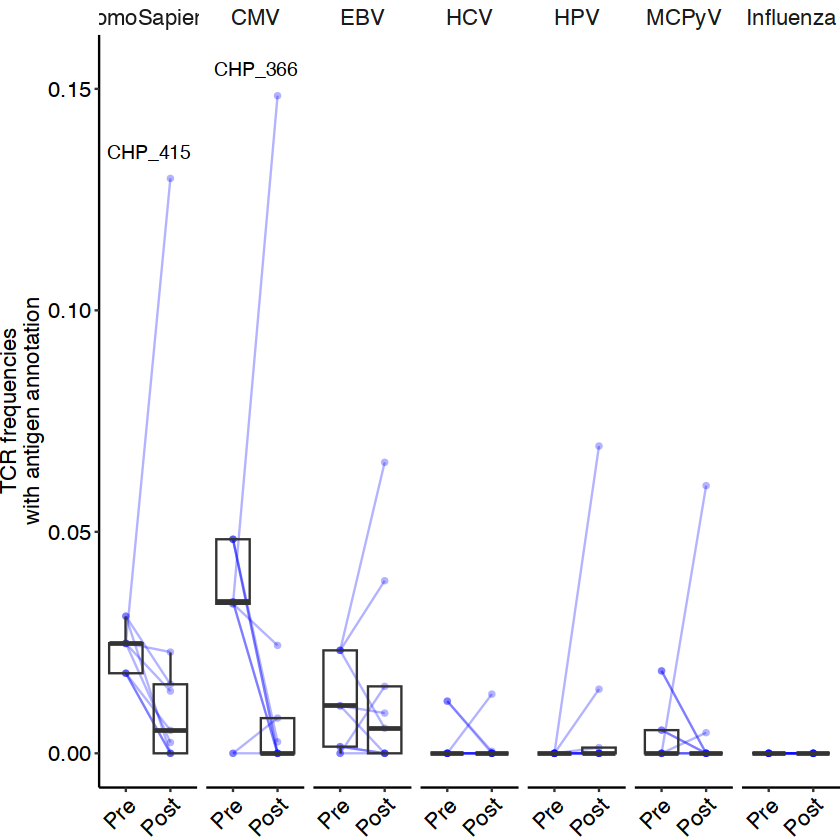

In [67]:
p_sample_cancer

In [68]:
pdf(paste0(plotpath, "antigen_frac_p_lym.pdf"), width = 10, height = 5)
cowplot::plot_grid(p_sample_cancer, labels = "B")
dev.off()

Warning message:
"Removed 124 rows containing missing values or values outside the scale range
(`geom_text_repel()`)."


pdf 
  2

Solid

In [52]:
sampletype <- "PBMC"
cancergroup <- "Solidtumors"

df1 <- samples_tcr_freq[ samples_tcr_freq$sampletype == sampletype,]
df1 <- df1[ df1$cancergroup == cancergroup,]

In [53]:
# get patients with more than one timepoiint and a baseline
mytab <- table(df1$Patient, df1$cycle)
mytab <- mytab[rowSums(mytab != 0) > 1, ]
baseline_patients <- rownames(mytab)[mytab[, 1] > 0]
df1_baseline <- df1[df1$Patient %in% baseline_patients, ]

In [54]:
myantigens <- colnames(df1_baseline)[1:13]

In [55]:
# generate pre samples for each additional post sample
for( i in unique(df1_baseline$Patient)){
    mypt <- df1_baseline[ df1_baseline$Patient == i, ]
    n_post <- nrow(mypt[ mypt$cycle != "X01", ])
    df1_baseline <- rbind(df1_baseline, mypt[ mypt$cycle == "X01", ][rep(1, n_post-1), ])
}

In [56]:
for (i in 1:length(myantigens)) {
    myvar <- paste0(myantigens[i], "_frac")
    df1_baseline[[myvar]] <- NA
    df1_baseline[[myvar]] <- df1_baseline[,i] / df1_baseline$cdr3_reads
}

In [57]:
  # generate an a unique ID between each pairs of pre and post
df1_baseline$ID <- NA
df1_baseline_id <- df1_baseline[0,]

  for( i in unique(df1_baseline$Patient)){  
    mypt <- df1_baseline[ df1_baseline$Patient == i, ]
    n_pre <- nrow(mypt[ mypt$cycle == "X01", ])
    mypt$ID[mypt$group == "pre"] <- paste0(mypt$Patient[mypt$group == "pre"], "_", rep(1:n_pre))
    mypt$ID[mypt$group == "post"] <- paste0(mypt$Patient[mypt$group == "pre"], "_", rep(1:n_pre))
    df1_baseline_id <- rbind(df1_baseline_id, mypt)
  }

In [58]:
head(df1_baseline_id)

,CMV,EBV,HCV,Influenza,HomoSapiens,MDavis,HPV,CEF,TB,MCPyV,...,HomoSapiens_frac,MDavis_frac,HPV_frac,CEF_frac,TB_frac,MCPyV_frac,SP_frac,HTLV1_frac,DENV_frac,ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Solidtumors:CHP_348_X01-PBMC,12,3,3,0,68,501,1,0,0,0,...,0.07142857,0.5262605,0.001050420,0,0,0.000000000,0,0,0,CHP_348_1
Solidtumors:CHP_348_X02-PBMC,0,0,0,0,0,121,0,0,0,0,...,0.00000000,0.4060403,0.000000000,0,0,0.000000000,0,0,0,CHP_348_1
Solidtumors:CHP_350_X01-PBMC,27,0,10,5,52,818,2,0,0,7,...,0.03157256,0.4966606,0.001214329,0,0,0.004250152,0,0,0,CHP_350_1
Solidtumors:CHP_350_X02-PBMC,16,29,47,0,101,1672,0,0,0,22,...,0.03375668,0.5588235,0.000000000,0,0,0.007352941,0,0,0,CHP_350_1
Solidtumors:CHP_350_X03-PBMC,20,12,6,0,35,1120,0,0,0,28,...,0.01640112,0.5248360,0.000000000,0,0,0.013120900,0,0,0,CHP_350_2
Solidtumors:CHP_350_X04-PBMC,6,9,4,0,18,769,0,0,0,0,...,0.01820020,0.7775531,0.000000000,0,0,0.000000000,0,0,0,CHP_350_3


In [59]:
message("CMV")
tapply(df1_baseline_id$CMV_frac, df1_baseline_id$group, summary)
message("Human")
tapply(df1_baseline_id$HomoSapiens_frac, df1_baseline_id$group, summary)


CMV



$pre
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0009416 0.0115546 0.0102599 0.0163934 0.0231716 

$post
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.004948 0.005442 0.007203 0.024155 


Human



$pre
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.008662 0.026000 0.026843 0.045422 0.071429 

$post
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.007169 0.018584 0.028949 0.032415 0.236842 


In [76]:
myantigens <- c('CMV','EBV','HCV','Influenza','HomoSapiens','HPV','MCPyV')

In [77]:
wilcox_mat <- matrix(NA, nrow = length(myantigens), ncol = 2, dimnames = list(myantigens, c("antigen", "p")))

In [78]:
for(i in 1:length(myantigens)){
    mycol <- paste0(myantigens[i], "_frac")
    mytest <- wilcox.test( eval(as.name(mycol)) ~ group,data = df1_baseline_id, paired = T)
    wilcox_mat[i, "antigen"] <- myantigens[i]
    wilcox_mat[i, "p"] <- mytest$p.value
}

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1

In [79]:
wilcox_mat <- as.data.frame(wilcox_mat)
wilcox_mat$p <- as.numeric(wilcox_mat$p)
wilcox_mat$adjp <- p.adjust(wilcox_mat$p, method = "fdr")

In [80]:
wilcox_mat[order(wilcox_mat$adjp),]

,antigen,p,adjp
,<chr>,<dbl>,<dbl>
CMV,CMV,0.05736952,0.1338622
Influenza,Influenza,0.04199965,0.1338622
MCPyV,MCPyV,0.03624171,0.1338622
HCV,HCV,0.32017407,0.4287334
HomoSapiens,HomoSapiens,0.35308667,0.4287334
HPV,HPV,0.36748581,0.4287334
EBV,EBV,0.92238568,0.9223857


In [81]:
sig_wilcox_mat <- wilcox_mat[ which(wilcox_mat$adjp < 0.1),]
sig_wilcox_mat$p.val <- sapply(sig_wilcox_mat$p, function(x) round_and_format(x) )

In [82]:
# sig_wilcox_mat

In [83]:
# pivot_longer
# exclude MDavis, CEF, HTLV, DENV
df1_baseline_long <- df1_baseline_id %>%
    dplyr::select(
        sample_id, Patient, cycle, cancergroup, Age, Relapse, group, ID,
        CMV_frac, EBV_frac, HCV_frac, Influenza_frac, HomoSapiens_frac, HPV_frac, MCPyV_frac) %>%
    tidyr::pivot_longer(cols = ends_with("_frac"), names_to = "antigen", values_to = "fraction")


In [84]:
df1_baseline_long <- df1_baseline_long[ !is.na(df1_baseline_long$fraction),]

In [85]:
df1_baseline_long$antigen <- gsub("_frac", "", df1_baseline_long$antigen)

In [86]:
df1_baseline_long$antigen <- factor(df1_baseline_long$antigen, levels = c("HomoSapiens", 'CMV','EBV','HCV','HPV','MCPyV','Influenza'))

In [87]:
head(df1_baseline_long)

sample_id,Patient,cycle,cancergroup,Age,Relapse,group,ID,antigen,fraction
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<fct>,<chr>,<fct>,<dbl>
CHP_348_01,CHP_348,X01,Solidtumors,18,0,pre,CHP_348_1,CMV,0.012605042
CHP_348_01,CHP_348,X01,Solidtumors,18,0,pre,CHP_348_1,EBV,0.003151261
CHP_348_01,CHP_348,X01,Solidtumors,18,0,pre,CHP_348_1,HCV,0.003151261
CHP_348_01,CHP_348,X01,Solidtumors,18,0,pre,CHP_348_1,Influenza,0.000000000
CHP_348_01,CHP_348,X01,Solidtumors,18,0,pre,CHP_348_1,HomoSapiens,0.071428571
CHP_348_01,CHP_348,X01,Solidtumors,18,0,pre,CHP_348_1,HPV,0.001050420


In [88]:
df1_baseline_long$label <- NA
df1_baseline_long$label[df1_baseline_long$fraction > 0.04 &
    df1_baseline_long$antigen == "EBV"] <- "X"
df1_baseline_long$label[df1_baseline_long$fraction > 0.15] <- "X"


In [89]:
df1_baseline_long[ df1_baseline_long$Patient == "CHP_414",]

sample_id,Patient,cycle,cancergroup,Age,Relapse,group,ID,antigen,fraction,label
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<fct>,<chr>,<fct>,<dbl>,<chr>
CHP_414_01,CHP_414,X01,Solidtumors,1,0,pre,CHP_414_1,CMV,0.0000000000,NA
CHP_414_01,CHP_414,X01,Solidtumors,1,0,pre,CHP_414_1,EBV,0.0000000000,NA
CHP_414_01,CHP_414,X01,Solidtumors,1,0,pre,CHP_414_1,HCV,0.0000000000,NA
CHP_414_01,CHP_414,X01,Solidtumors,1,0,pre,CHP_414_1,Influenza,0.0000000000,NA
CHP_414_01,CHP_414,X01,Solidtumors,1,0,pre,CHP_414_1,HomoSapiens,0.0000000000,NA
CHP_414_01,CHP_414,X01,Solidtumors,1,0,pre,CHP_414_1,HPV,0.2018166997,X
CHP_414_01,CHP_414,X01,Solidtumors,1,0,pre,CHP_414_1,MCPyV,0.0000000000,NA
CHP_414_02,CHP_414,X02,Solidtumors,1,0,post,CHP_414_1,CMV,0.0068557183,NA
CHP_414_02,CHP_414,X02,Solidtumors,1,0,post,CHP_414_1,EBV,0.0058169731,NA


In [90]:
df1_baseline_long[ which(df1_baseline_long$label == "X"),]

sample_id,Patient,cycle,cancergroup,Age,Relapse,group,ID,antigen,fraction,label
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<fct>,<chr>,<fct>,<dbl>,<chr>
CHP_363_03,CHP_363,X03,Solidtumors,20,0,post,CHP_363_2,HomoSapiens,0.23684211,X
CHP_364_04,CHP_364,X04,Solidtumors,16,1,post,CHP_364_2,EBV,0.04251208,X
CHP_414_01,CHP_414,X01,Solidtumors,1,0,pre,CHP_414_1,HPV,0.20181670,X
CHP_414_01,CHP_414,X01,Solidtumors,1,0,pre,CHP_414_2,HPV,0.20181670,X
CHP_418_02,CHP_418,X02,Solidtumors,2,1,post,CHP_418_1,EBV,0.05178535,X


In [91]:
p_sample_cancer <- ggplot(df1_baseline_long, aes(x = group, y = fraction)) +
    geom_point(aes(color = factor(Relapse)), alpha = 0.3, shape = 16) +
    geom_line(aes(group = ID, color = factor(Relapse)), alpha = 0.3) +
    scale_color_manual(values = c("0" = "blue", "1" = "red")) +
    geom_boxplot(fill = "transparent", outlier.shape = NA) +
    myplot +
    myaxis +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
    facet_wrap(~factor(antigen, levels(df1_baseline_long$antigen)), nrow = 1, scales = "free_x", strip.position = "top") +
    # ggsignif::geom_signif(
    #     data = sig_wilcox_mat,
    #     aes(xmin = 1, xmax = 2, annotations = p.val, y_position = 0.07),
    #     textsize = 3, vjust = -0.2, color = "black",
    #     manual = TRUE
    # ) +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
        geom_text_repel(
        label = ifelse(df1_baseline_long$label == "X", as.character(df1_baseline_long$Patient), ""),
        size = 4, #min.segment.length = 0,
        nudge_y = .006,
        ylim = c(-Inf, Inf)
        #arrow = arrow(length = unit(0.1, "npc"))
    ) +
    ylab("TCR frequencies\nwith antigen annotation") +
    scale_x_discrete(ggpubr::get_breaks("group"),
        labels = c("Pre", "Post")
    )


Warning message:
"Removed 331 rows containing missing values or values outside the scale range
(`geom_text_repel()`)."


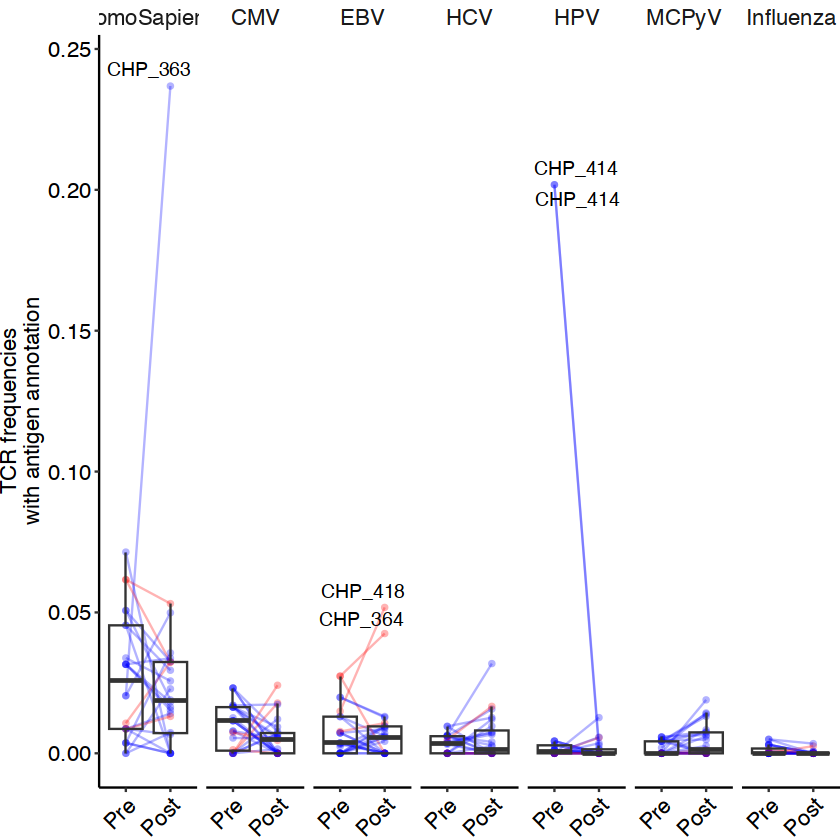

In [92]:
p_sample_cancer

In [93]:
pdf(paste0(plotpath, "antigen_frac_p_solid.pdf"), width = 10, height = 5)
cowplot::plot_grid(p_sample_cancer, labels = "C")
dev.off()

Warning message:
"Removed 331 rows containing missing values or values outside the scale range
(`geom_text_repel()`)."


pdf 
  2

# Lookup

In [90]:
head(meta_div[ meta_div$Patient == "CHP_413",])

,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,observed_Simpson,estimated_Simpson,SE_Simpson,basename,file,sampletype,Group,log10shann,assay,samplename
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
771,CHP_413_01,CHP_413,X01,4.0,0.00,19,AML,4.0,1985,43,...,26.320,26.989,0.543,CHP_413-01_PBMC-DNA,batch12_30Apr2021/mixcr/clones/CLONES_TRBCHP_413-01_PBMC-DNA.txt,PBMC,CHP,1.4449967,Flow cytometry & capTCR-seq,Leukemia:CHP_413_X01-PBMC
772,CHP_413_02,CHP_413,X02,3.2,93.42,19,AML,3.2,2525,312,...,145.798,145.907,0.492,CHP_413-02_PBMC-DNA,remaining_batch_3_4May2021/mixcr/clones/CLONES_TRBCHP_413-02_PBMC-DNA.txt,PBMC,CHP,2.2681378,Flow cytometry & capTCR-seq,Leukemia:CHP_413_X02-PBMC
268,CHP_413_01,CHP_413,X01,4.0,0.00,19,AML,4.0,1985,43,...,3.934,3.940,0.026,CHP_413-01_cfDNA,batch11_cfDNA_11Sep2020/mixcr/clones/CLONES_TRBCHP_413-01_cfDNA.txt,cfDNA,CHP,0.5999922,capTCR-seq,Leukemia:CHP_413_X01-cfDNA
269,CHP_413_02,CHP_413,X02,3.2,93.42,19,AML,3.2,2525,312,...,2.401,2.402,0.051,CHP_413-02_cfDNA,priority_pool3/mixcr/clones/CLONES_TRBCHP_413-02_cfDNA.txt,cfDNA,CHP,0.4942938,capTCR-seq,Leukemia:CHP_413_X02-cfDNA


In [43]:
gliph_out <- readr::read_rds(file = paste0(datapath, "GLIPH/int_gliph_v5_cleaned.rds"))

In [98]:
head(gliph_out[grepl("MAA", gliph_out$Sample),])

index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,TcRb,V,J,TcRa,Sample,Freq,subject
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<chr>
4,IWV,0.0e+00,3,97,1.2e-10,1,0.008,0.008,0.190,1.0e-05,motif-IWV,CASWIWVDRRSTDTQYF,TRBV19,TRBJ1-2,NA,HomoSapiens:MAA_NA,1,HomoSapiens
17,S%GLAGGE,1.3e-33,4,29,3.8e-11,1,0.001,0.940,0.001,4.0e-05,global-S%GLAGGE,CASSYGLAGGEQFF,TRBV2,TRBJ2-1,NA,HomoSapiens:MAA_NA,1,HomoSapiens
56,SPG%NE,6.4e-25,5,23,8.5e-11,1,0.001,1.000,0.001,8.5e-05,global-SPG%NE,CASSPGGNEQFF,TRBV5-5,TRBJ2-1,NA,HomoSapiens:MAA_NA,1,HomoSapiens
75,SPGQ%NTE,2.5e-22,5,18,8.5e-11,1,0.001,1.000,0.001,8.6e-05,global-SPGQ%NTE,CASSPGQRNTEAFF,TRBV6-1,TRBJ1-4,NA,HomoSapiens:MAA_NA,1,HomoSapiens
75,SPGQ%NTE,2.5e-22,5,18,8.5e-11,1,0.001,1.000,0.001,8.6e-05,global-SPGQ%NTE,CASSPGQLNTEAFF,TRBV20-1,TRBJ1-6,NA,HomoSapiens:MAA_NA,1,HomoSapiens
277,SPGG%E,1.5e-15,4,18,8.6e-11,1,0.001,1.000,0.001,8.6e-05,global-SPGG%E,CASSPGGNEQFF,TRBV5-5,TRBJ2-1,NA,HomoSapiens:MAA_NA,1,HomoSapiens


In [48]:
mysample <- gliph_out[ grepl("CHP_353", gliph_out$Sample),]

In [49]:
head(mysample)

index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,TcRb,V,J,TcRa,Sample,Freq,subject
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<chr>
1,SLG%E,0.0e+00,5,50,5.0e-12,1,0.001,0.35,0.001,1.4e-05,global-SLG%E,CASSLGTEAFF,TRBV5-1,TRBJ1-1,NA,Leukemia:CHP_353_X05-PBMC,11,Leukemia
9,S%SGANV,7.5e-41,3,34,3.4e-11,1,0.001,1.00,0.001,3.4e-05,global-S%SGANV,CASSTSGANVLTF,TRBV11-2,TRBJ2-6,NA,Leukemia:CHP_353_X05-PBMC,64,Leukemia
23,SP%GTE,3.8e-32,4,28,4.0e-11,1,0.001,0.99,0.001,4.0e-05,global-SP%GTE,CASSPQGTEAFF,TRBV18,TRBJ1-1,NA,Leukemia:CHP_353_X03-PBMC,14,Leukemia
33,SP%MNTE,1.6e-28,3,22,7.5e-11,1,0.001,1.00,0.001,7.5e-05,global-SP%MNTE,CATSPPMNTEAFF,TRBV28,TRBJ1-1,NA,Leukemia:CHP_353_X05-PBMC,9,Leukemia
47,SPG%TGE,1.2e-25,3,21,6.1e-11,1,0.001,0.64,0.001,9.6e-05,global-SPG%TGE,CAISPGTTGEQYF,TRBV10-3,TRBJ2-7,NA,Leukemia:CHP_353_X04-cfDNA,7,Leukemia
74,S%GSYE,1.5e-22,6,25,2.3e-09,1,0.055,0.80,0.001,5.2e-05,global-S%GSYE,CASSKGSYEQYF,TRBV10-1,TRBJ2-7,NA,Leukemia:CHP_353_X01-PBMC,9,Leukemia


In [50]:
tmp <- gliph_out[gliph_out$pattern %in% mysample$pattern, ] # subset to include patterns in my sample
antigen_gliphs <- tmp[grepl("Homo", tmp$subject),] # get antigen gliphs
mysample[mysample$pattern %in% antigen_gliphs$pattern,]


index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,TcRb,V,J,TcRa,Sample,Freq,subject
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<chr>
74,S%GSYE,1.5e-22,6,25,2.3e-09,1,0.055,0.800,0.001,5.2e-05,global-S%GSYE,CASSKGSYEQYF,TRBV10-1,TRBJ2-7,NA,Leukemia:CHP_353_X01-PBMC,9,Leukemia
471,S%TGGTE,1.5e-12,5,14,4.7e-09,1,0.065,0.990,0.001,7.4e-05,global-S%TGGTE,CASSATGGTEAFF,TRBV6-2,TRBJ1-1,NA,Leukemia:CHP_353_X03-PBMC,2,Leukemia
471,S%TGGTE,1.5e-12,5,14,4.7e-09,1,0.065,0.990,0.001,7.4e-05,global-S%TGGTE,CASSITGGTEAFF,TRBV19,TRBJ1-1,NA,Leukemia:CHP_353_X05-PBMC,14,Leukemia
591,SLGG%E,1.4e-11,5,15,1.1e-10,1,0.003,0.400,0.001,9.5e-05,global-SLGG%E,CASSLGGYEQYF,TRBV5-6,TRBJ2-7,NA,Leukemia:CHP_353_X03-PBMC,5,Leukemia
1143,SLG%GQP,7.5e-09,6,8,8.6e-09,1,0.066,0.160,0.001,8.3e-04,global-SLG%GQP,CASSLGVGQPQHF,TRBV12-3,TRBJ1-5,NA,Leukemia:CHP_353_X04-cfDNA,1221,Leukemia
1143,SLG%GQP,7.5e-09,6,8,8.6e-09,1,0.066,0.160,0.001,8.3e-04,global-SLG%GQP,CASSLGVGQPQHF,TRBV12-3,TRBJ1-5,NA,Leukemia:CHP_353_X05-PBMC,2,Leukemia
1220,S%QGTE,1.3e-08,3,10,2.9e-08,1,0.100,0.920,0.001,3.1e-04,global-S%QGTE,CASSPQGTEAFF,TRBV18,TRBJ1-1,NA,Leukemia:CHP_353_X03-PBMC,14,Leukemia
1220,S%QGTE,1.3e-08,3,10,2.9e-08,1,0.100,0.920,0.001,3.1e-04,global-S%QGTE,CASSQQGTEAFF,TRBV3-1,TRBJ1-1,NA,Leukemia:CHP_353_X05-PBMC,25,Leukemia
1509,SPQG%GTE,8.2e-08,3,6,4.5e-07,1,0.380,0.980,0.001,1.2e-03,global-SPQG%GTE,CASSPQGGGTEAFF,TRBV9,TRBJ1-1,NA,Leukemia:CHP_353_X05-PBMC,23,Leukemia


In [51]:
antigen_gliphs$Sample[ antigen_gliphs$pattern %in% mysample$pattern]

[1] "HomoSapiens:NUP214_SVYWSPKGK"                   
 [2] "HomoSapiens:MAA_NA"                             
 [3] "HomoSapiens:MAA_NA"                             
 [4] "HomoSapiens:MAA_NA"                             
 [5] "HomoSapiens:TERT_ILAKFLHWL"                     
 [6] "HomoSapiens:MAA_NA"                             
 [7] "HomoSapiens:TMEM161A_TMEM161A"                  
 [8] "HomoSapiens:MLANA_ELAGIGILTV_AAGIGILTV"         
 [9] "HomoSapiens:MAA_NA"                             
[10] "HomoSapiens:RPS9p.P68S_NeoAg-AARELLTLDEKDSRRLFE"
[11] "HomoSapiens:MLANA27-35_TAA-AAGIGILTV"           
[12] "HomoSapiens:PMEL154-162_TAA-KTWGQYWQV"          
[13] "HomoSapiens:CMKLR1_FLEDLSPLEA"                  
[14] "HomoSapiens:MAA_NA"

In [97]:
antigen_gliphs

index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,TcRb,V,J,TcRa,Sample,Freq,subject
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<chr>
2,S%GGNTE,0.0e+00,6,41,3.0e-11,1,0.001,0.970,0.001,0.00003,global-S%GGNTE,CASSWGGNTEAFF,NA,NA,NA,HomoSapiens:ZNF219_CLASLHPR,1,HomoSapiens
1143,SLG%GQP,7.5e-09,6,8,8.6e-09,1,0.066,0.160,0.001,0.00083,global-SLG%GQP,CASSLGQGQPQHF,TRBV6-1,TRBJ1-2,NA,HomoSapiens:MAA_NA,1,HomoSapiens
20216,SF%GGGNQP,1.4e-02,2,2,2.2e-09,1,0.001,0.074,0.001,0.02900,global-SF%GGGNQP,CASSFAGGGNQPQHF,NA,NA,NA,HomoSapiens:POLE_TSISTAMR,1,HomoSapiens
24196,SQGP%YE,3.5e-02,2,2,5.3e-09,1,0.001,0.180,0.001,0.02900,global-SQGP%YE,CASSQGPFYEQYF,TRBV3-1,TRBJ2-7,NA,HomoSapiens:MLANA27-35_TAA-AAGIGILTV,1,HomoSapiens


In [ ]:
mysample[ mysample$pattern == "V%TE",]

In [ ]:
gliph_out[ gliph_out$pattern %in% chp413$pattern,]

### cfDNA

Leukemia

In [208]:
sampletype <- "cfDNA"
cancergroup <- "Leukemia"

df1 <- samples_tcr_freq[ samples_tcr_freq$sampletype == sampletype,]
df1 <- df1[ df1$cancergroup == cancergroup,]

In [209]:
# get patients with more than one timepoiint and a baseline
mytab <- table(df1$Patient, df1$cycle)
mytab <- mytab[rowSums(mytab != 0) > 1, ]
baseline_patients <- rownames(mytab)[mytab[, 1] > 0]
df1_baseline <- df1[df1$Patient %in% baseline_patients, ]

In [210]:
myantigens <- colnames(df1_baseline)[1:13]

In [211]:
# generate pre samples for each additional post sample
for( i in unique(df1_baseline$Patient)){
    mypt <- df1_baseline[ df1_baseline$Patient == i, ]
    n_post <- nrow(mypt[ mypt$cycle != "X01", ])
    df1_baseline <- rbind(df1_baseline, mypt[ mypt$cycle == "X01", ][rep(1, n_post-1), ])
}

In [212]:
for (i in 1:length(myantigens)) {
    myvar <- paste0(myantigens[i], "_frac")
    df1_baseline[[myvar]] <- NA
    df1_baseline[[myvar]] <- df1_baseline[,i] / df1_baseline$cdr3_reads
}

In [213]:
# generate an a unique ID between each pairs of pre and post
df1_baseline$ID <- NA
df1_baseline_id <- df1_baseline[0, ]

for (i in unique(df1_baseline$Patient)) {
  mypt <- df1_baseline[df1_baseline$Patient == i, ]
  n_pre <- nrow(mypt[mypt$cycle == "X01", ])
  mypt$ID[mypt$group == "pre"] <- paste0(mypt$Patient[mypt$group == "pre"], "_", rep(1:n_pre))
  mypt$ID[mypt$group == "post"] <- paste0(mypt$Patient[mypt$group == "pre"], "_", rep(1:n_pre))
  df1_baseline_id <- rbind(df1_baseline_id, mypt)
}


In [214]:
head(df1_baseline_id)

,CMV,EBV,HCV,Influenza,HomoSapiens,MDavis,HPV,CEF,TB,MCPyV,...,HomoSapiens_frac,MDavis_frac,HPV_frac,CEF_frac,TB_frac,MCPyV_frac,SP_frac,HTLV1_frac,DENV_frac,ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Leukemia:CHP_345_X01-cfDNA,385,1511,0,490,258,16874,0,0,0,224,...,0.01325865,0.8671566,0,0,0,0.01151138,0,0,0,CHP_345_1
Leukemia:CHP_345_X02-cfDNA,0,0,0,0,0,535,0,0,0,0,...,0.00000000,0.2123859,0,0,0,0.00000000,0,0,0,CHP_345_1
Leukemia:CHP_345_X04-cfDNA,0,0,0,0,0,13893,0,0,0,0,...,0.00000000,0.3926906,0,0,0,0.00000000,0,0,0,CHP_345_2
Leukemia:CHP_345_X01-cfDNA1,385,1511,0,490,258,16874,0,0,0,224,...,0.01325865,0.8671566,0,0,0,0.01151138,0,0,0,CHP_345_2
Leukemia:CHP_353_X01-cfDNA,0,0,0,0,0,11,0,0,0,0,...,0.00000000,0.1100000,0,0,0,0.00000000,0,0,0,CHP_353_1
Leukemia:CHP_353_X02-cfDNA,208,0,0,0,0,3782,0,0,0,0,...,0.00000000,0.3676128,0,0,0,0.00000000,0,0,0,CHP_353_1


In [215]:
myantigens <- c('CMV','EBV','HCV','Influenza','HomoSapiens','HPV','MCPyV')

In [216]:
wilcox_mat <- matrix(NA, nrow = length(myantigens), ncol = 2, dimnames = list(myantigens, c("antigen", "p")))

In [217]:
for(i in 1:length(myantigens)){
    mycol <- paste0(myantigens[i], "_frac")
    mytest <- wilcox.test( eval(as.name(mycol)) ~ group,data = df1_baseline_id, paired = T)
    wilcox_mat[i, "antigen"] <- myantigens[i]
    wilcox_mat[i, "p"] <- mytest$p.value
}

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[

In [218]:
wilcox_mat <- as.data.frame(wilcox_mat)
wilcox_mat$p <- as.numeric(wilcox_mat$p)
wilcox_mat$adjp <- p.adjust(wilcox_mat$p, method = "fdr")

In [219]:
wilcox_mat[order(wilcox_mat$adjp),]

,antigen,p,adjp
,<chr>,<dbl>,<dbl>
Influenza,Influenza,0.3457786,0.6051125
HomoSapiens,HomoSapiens,0.1154794,0.6051125
HPV,HPV,0.1967056,0.6051125
MCPyV,MCPyV,0.3457786,0.6051125
CMV,CMV,0.7259636,0.8334840
EBV,EBV,0.8334840,0.8334840
HCV,HCV,0.6085999,0.8334840


In [220]:
# sig_wilcox_mat <- wilcox_mat[ wilcox_mat$adjp < 0.15,]
# sig_wilcox_mat$p.val <- sapply(sig_wilcox_mat$adjp, function(x) round_and_format(x) )

In [221]:
# sig_wilcox_mat

In [222]:
# pivot_longer
# exclude MDavis, CEF, HTLV, DENV
df1_baseline_long <- df1_baseline_id %>%
    dplyr::select(
        sample_id, Patient, cycle, cancergroup, Age, Relapse, group, ID,
        CMV_frac, EBV_frac, HCV_frac, Influenza_frac, HomoSapiens_frac, HPV_frac, MCPyV_frac
    ) %>%
    tidyr::pivot_longer(cols = ends_with("_frac"), names_to = "antigen", values_to = "fraction")


In [223]:
df1_baseline_long <- df1_baseline_long[ !is.na(df1_baseline_long$fraction),]

In [224]:
df1_baseline_long$antigen <- gsub("_frac", "", df1_baseline_long$antigen)

In [225]:
df1_baseline_long$antigen <- factor(df1_baseline_long$antigen, levels = c("HomoSapiens", 'CMV','EBV','HCV','HPV','MCPyV','Influenza'))

In [226]:
head(df1_baseline_long)

sample_id,Patient,cycle,cancergroup,Age,Relapse,group,ID,antigen,fraction
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<fct>,<chr>,<fct>,<dbl>
CHP_345_01,CHP_345,X01,Leukemia,1,0,pre,CHP_345_1,CMV,0.01978519
CHP_345_01,CHP_345,X01,Leukemia,1,0,pre,CHP_345_1,EBV,0.07765044
CHP_345_01,CHP_345,X01,Leukemia,1,0,pre,CHP_345_1,HCV,0.00000000
CHP_345_01,CHP_345,X01,Leukemia,1,0,pre,CHP_345_1,Influenza,0.02518115
CHP_345_01,CHP_345,X01,Leukemia,1,0,pre,CHP_345_1,HomoSapiens,0.01325865
CHP_345_01,CHP_345,X01,Leukemia,1,0,pre,CHP_345_1,HPV,0.00000000


In [227]:
p_sample_cancer <- ggplot(df1_baseline_long, aes(x = group, y = fraction)) +
    geom_point(aes(color = factor(Relapse)), alpha = 0.3, shape = 16) +
    geom_line(aes(group = ID, color = factor(Relapse)), alpha = 0.3) +
    scale_color_manual(values = c("0" = "blue", "1" = "red")) +
    geom_boxplot(fill = "transparent", outlier.shape = NA) +
    myplot +
    myaxis +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
    facet_wrap(~factor(antigen, levels(df1_baseline_long$antigen)), nrow = 1, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("TCR frequencies\nwith antigen annotation") +
    scale_x_discrete(ggpubr::get_breaks("group"),
        labels = c("Pre", "Post")
    )


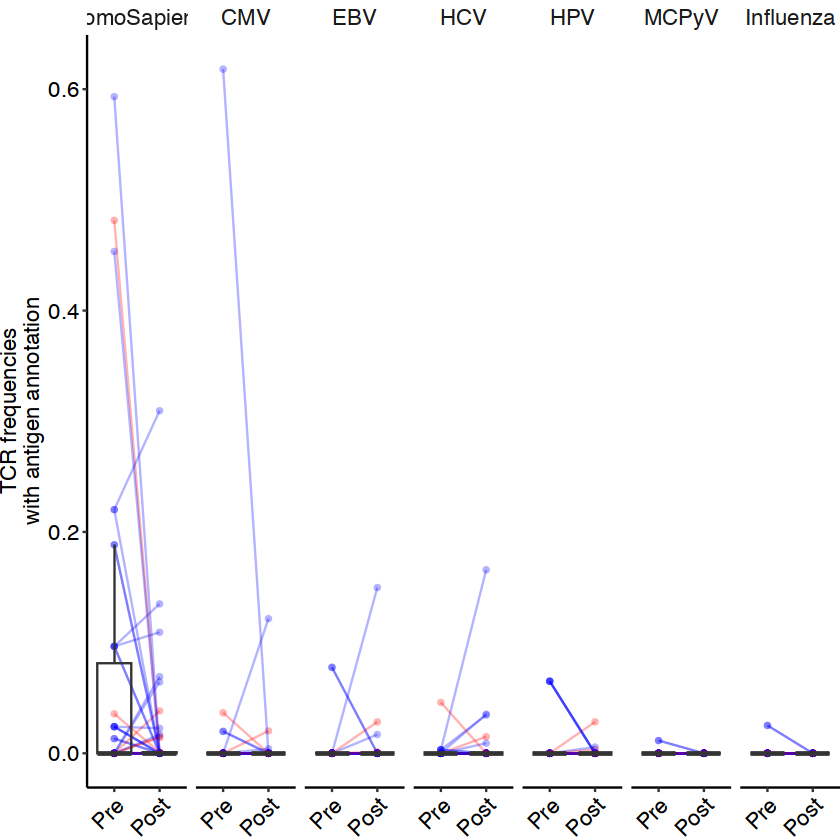

In [228]:
p_sample_cancer

In [229]:
pdf(paste0(plotpath, "antigen_frac_p_leu_cfDNA.pdf"), width = 10, height = 5)
p_sample_cancer
dev.off()

pdf 
  2

Lymphoma

In [230]:
sampletype <- "cfDNA"
cancergroup <- "Lymphoma"

df1 <- samples_tcr_freq[ samples_tcr_freq$sampletype == sampletype,]
df1 <- df1[ df1$cancergroup == cancergroup,]

In [231]:
# get patients with more than one timepoiint and a baseline
mytab <- table(df1$Patient, df1$cycle)
mytab <- mytab[rowSums(mytab != 0) > 1, ]
baseline_patients <- rownames(mytab)[mytab[, 1] > 0]
df1_baseline <- df1[df1$Patient %in% baseline_patients, ]

In [232]:
myantigens <- colnames(df1_baseline)[1:13]

In [233]:
# generate pre samples for each additional post sample
for( i in unique(df1_baseline$Patient)){
    mypt <- df1_baseline[ df1_baseline$Patient == i, ]
    n_post <- nrow(mypt[ mypt$cycle != "X01", ])
    df1_baseline <- rbind(df1_baseline, mypt[ mypt$cycle == "X01", ][rep(1, n_post-1), ])
}

In [234]:
for (i in 1:length(myantigens)) {
    myvar <- paste0(myantigens[i], "_frac")
    df1_baseline[[myvar]] <- NA
    df1_baseline[[myvar]] <- df1_baseline[,i] / df1_baseline$cdr3_reads
}

In [235]:
  # generate an a unique ID between each pairs of pre and post
df1_baseline$ID <- NA
df1_baseline_id <- df1_baseline[0,]

  for( i in unique(df1_baseline$Patient)){  
    mypt <- df1_baseline[ df1_baseline$Patient == i, ]
    n_pre <- nrow(mypt[ mypt$cycle == "X01", ])
    mypt$ID[mypt$group == "pre"] <- paste0(mypt$Patient[mypt$group == "pre"], "_", rep(1:n_pre))
    mypt$ID[mypt$group == "post"] <- paste0(mypt$Patient[mypt$group == "pre"], "_", rep(1:n_pre))
    df1_baseline_id <- rbind(df1_baseline_id, mypt)
  }

In [236]:
head(df1_baseline_id)

,CMV,EBV,HCV,Influenza,HomoSapiens,MDavis,HPV,CEF,TB,MCPyV,...,HomoSapiens_frac,MDavis_frac,HPV_frac,CEF_frac,TB_frac,MCPyV_frac,SP_frac,HTLV1_frac,DENV_frac,ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Lymphoma:CHP_344_X01-cfDNA,0,0,0,0,0,335,0,0,0,0,...,0.0000000000,1.80107527,0,0,0,0,0,0,0,CHP_344_1
Lymphoma:CHP_344_X02-cfDNA,0,0,0,0,1,22,0,0,0,0,...,0.0009398496,0.02067669,0,0,0,0,0,0,0,CHP_344_1
Lymphoma:CHP_344_X03-cfDNA,0,0,0,0,0,7610,0,0,0,0,...,0.0000000000,0.91061386,0,0,0,0,0,0,0,CHP_344_2
Lymphoma:CHP_344_X04-cfDNA,0,0,0,0,0,6,0,0,0,0,...,0.0000000000,0.66666667,0,0,0,0,0,0,0,CHP_344_3
Lymphoma:CHP_344_X05-cfDNA,0,0,0,0,0,0,0,0,0,0,...,0.0000000000,0.00000000,0,0,0,0,0,0,0,CHP_344_4
Lymphoma:CHP_344_X01-cfDNA1,0,0,0,0,0,335,0,0,0,0,...,0.0000000000,1.80107527,0,0,0,0,0,0,0,CHP_344_2


In [237]:
myantigens <- c('CMV','EBV','HCV','Influenza','HomoSapiens','HPV','MCPyV')

In [238]:
wilcox_mat <- matrix(NA, nrow = length(myantigens), ncol = 2, dimnames = list(myantigens, c("antigen", "p")))

In [239]:
for(i in 1:length(myantigens)){
    mycol <- paste0(myantigens[i], "_frac")
    mytest <- wilcox.test( eval(as.name(mycol)) ~ group,data = df1_baseline_id, paired = T)
    wilcox_mat[i, "antigen"] <- myantigens[i]
    wilcox_mat[i, "p"] <- mytest$p.value
}

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = D

In [240]:
wilcox_mat <- as.data.frame(wilcox_mat)
wilcox_mat$p <- as.numeric(wilcox_mat$p)
wilcox_mat$adjp <- p.adjust(wilcox_mat$p, method = "fdr")

In [241]:
wilcox_mat[order(wilcox_mat$adjp),]

,antigen,p,adjp
,<chr>,<dbl>,<dbl>
CMV,CMV,0.02177671,0.08710683
Influenza,Influenza,1.00000000,1.00000000
HomoSapiens,HomoSapiens,0.83348400,1.00000000
HPV,HPV,1.00000000,1.00000000
EBV,EBV,NaN,NaN
HCV,HCV,NaN,NaN
MCPyV,MCPyV,NaN,NaN


In [242]:
sig_wilcox_mat <- wilcox_mat[ which(wilcox_mat$adjp < 0.1),]
sig_wilcox_mat$p.val <- sapply(sig_wilcox_mat$p, function(x) round_and_format(x) )

In [243]:
sig_wilcox_mat

,antigen,p,adjp,p.val
,<chr>,<dbl>,<dbl>,<chr>
CMV,CMV,0.02177671,0.08710683,0.02


In [244]:
# pivot_longer
# exclude MDavis, CEF, HTLV, DENV
df1_baseline_long <- df1_baseline_id %>%
    dplyr::select(
        sample_id, Patient, cycle, cancergroup, Age, Relapse, group, ID,
        CMV_frac, EBV_frac, HCV_frac, Influenza_frac, HomoSapiens_frac, HPV_frac, MCPyV_frac
    ) %>%
    tidyr::pivot_longer(cols = ends_with("_frac"), names_to = "antigen", values_to = "fraction")


In [245]:
df1_baseline_long <- df1_baseline_long[ !is.na(df1_baseline_long$fraction),]

In [246]:
df1_baseline_long$antigen <- gsub("_frac", "", df1_baseline_long$antigen)

In [247]:
df1_baseline_long$antigen <- factor(df1_baseline_long$antigen, levels = c("HomoSapiens", 'CMV','EBV','HCV','HPV','MCPyV','Influenza'))

In [248]:
head(df1_baseline_long)

sample_id,Patient,cycle,cancergroup,Age,Relapse,group,ID,antigen,fraction
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<fct>,<chr>,<fct>,<dbl>
CHP_344_01,CHP_344,X01,Lymphoma,6,0,pre,CHP_344_1,CMV,0
CHP_344_01,CHP_344,X01,Lymphoma,6,0,pre,CHP_344_1,EBV,0
CHP_344_01,CHP_344,X01,Lymphoma,6,0,pre,CHP_344_1,HCV,0
CHP_344_01,CHP_344,X01,Lymphoma,6,0,pre,CHP_344_1,Influenza,0
CHP_344_01,CHP_344,X01,Lymphoma,6,0,pre,CHP_344_1,HomoSapiens,0
CHP_344_01,CHP_344,X01,Lymphoma,6,0,pre,CHP_344_1,HPV,0


In [249]:
p_sample_cancer <- ggplot(df1_baseline_long, aes(x = group, y = fraction)) +
    geom_point(aes(color = factor(Relapse)), alpha = 0.3, shape = 16) +
    geom_line(aes(group = ID, color = factor(Relapse)), alpha = 0.3) +
    scale_color_manual(values = c("0" = "blue", "1" = "red")) +
    geom_boxplot(fill = "transparent", outlier.shape = NA) +
    myplot +
    myaxis +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
    facet_wrap(~factor(antigen, levels(df1_baseline_long$antigen)), nrow = 1, scales = "free_x", strip.position = "top") +
    ggsignif::geom_signif(
        data = sig_wilcox_mat,
        aes(xmin = 1, xmax = 2, annotations = p.val, y_position = 0.07),
        textsize = 3, vjust = -0.2, color = "black",
        manual = TRUE
    ) +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("TCR frequencies\nwith antigen annotation") +
    scale_x_discrete(ggpubr::get_breaks("group"),
        labels = c("Pre", "Post")
    )


Warning message in ggsignif::geom_signif(data = sig_wilcox_mat, aes(xmin = 1, xmax = 2, :
"Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position"


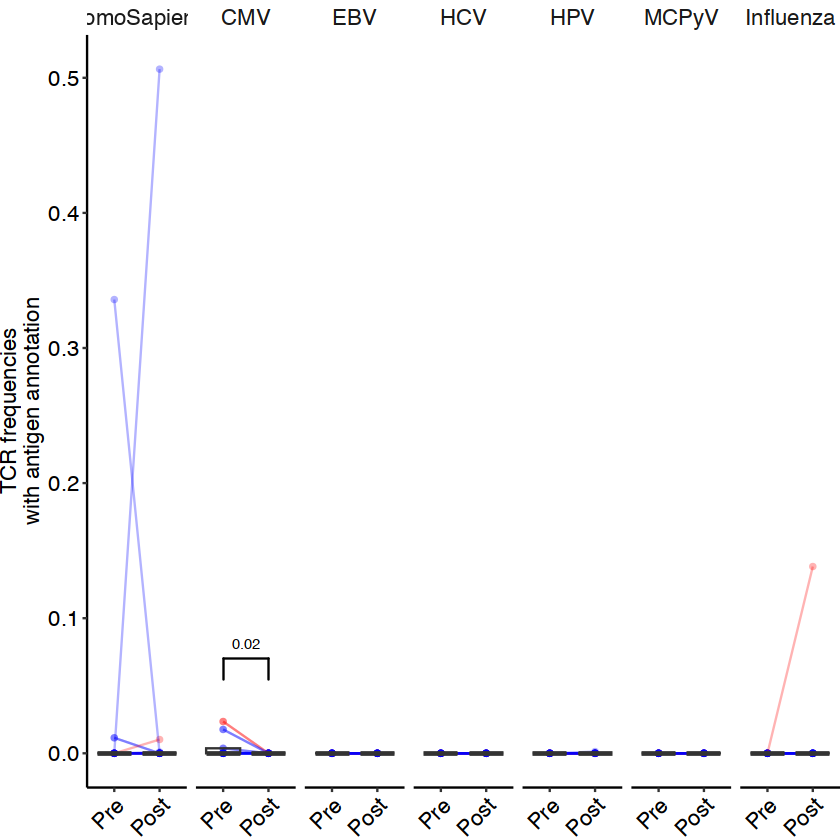

In [250]:
p_sample_cancer

In [251]:
pdf(paste0(plotpath, "antigen_frac_p_lym_cfDNA.pdf"), width = 10, height = 5)
p_sample_cancer
dev.off()

pdf 
  2

Solid

In [252]:
sampletype <- "cfDNA"
cancergroup <- "Solidtumors"

df1 <- samples_tcr_freq[ samples_tcr_freq$sampletype == sampletype,]
df1 <- df1[ df1$cancergroup == cancergroup,]

In [253]:
# get patients with more than one timepoiint and a baseline
mytab <- table(df1$Patient, df1$cycle)
mytab <- mytab[rowSums(mytab != 0) > 1, ]
baseline_patients <- rownames(mytab)[mytab[, 1] > 0]
df1_baseline <- df1[df1$Patient %in% baseline_patients, ]

In [254]:
myantigens <- colnames(df1_baseline)[1:13]

In [255]:
# generate pre samples for each additional post sample
for( i in unique(df1_baseline$Patient)){
    mypt <- df1_baseline[ df1_baseline$Patient == i, ]
    n_post <- nrow(mypt[ mypt$cycle != "X01", ])
    df1_baseline <- rbind(df1_baseline, mypt[ mypt$cycle == "X01", ][rep(1, n_post-1), ])
}

In [256]:
for (i in 1:length(myantigens)) {
    myvar <- paste0(myantigens[i], "_frac")
    df1_baseline[[myvar]] <- NA
    df1_baseline[[myvar]] <- df1_baseline[,i] / df1_baseline$cdr3_reads
}

In [257]:
# generate an a unique ID between each pairs of pre and post
df1_baseline$ID <- NA
df1_baseline_id <- df1_baseline[0, ]

for (i in unique(df1_baseline$Patient)) {
  mypt <- df1_baseline[df1_baseline$Patient == i, ]
  n_pre <- nrow(mypt[mypt$cycle == "X01", ])
  mypt$ID[mypt$group == "pre"] <- paste0(mypt$Patient[mypt$group == "pre"], "_", rep(1:n_pre))
  mypt$ID[mypt$group == "post"] <- paste0(mypt$Patient[mypt$group == "pre"], "_", rep(1:n_pre))
  df1_baseline_id <- rbind(df1_baseline_id, mypt)
}


In [258]:
head(df1_baseline_id)

,CMV,EBV,HCV,Influenza,HomoSapiens,MDavis,HPV,CEF,TB,MCPyV,...,HomoSapiens_frac,MDavis_frac,HPV_frac,CEF_frac,TB_frac,MCPyV_frac,SP_frac,HTLV1_frac,DENV_frac,ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Solidtumors:CHP_343_X01-cfDNA,0,0,0,0,0,0,0,0,0,0,...,0,0.0000000,0,0,0,0,0,0,0,CHP_343_1
Solidtumors:CHP_343_X02-cfDNA,0,0,0,0,0,0,0,0,0,0,...,0,0.0000000,0,0,0,0,0,0,0,CHP_343_1
Solidtumors:CHP_343_X05-cfDNA,0,0,0,0,0,4,0,0,0,0,...,0,0.6666667,0,0,0,0,0,0,0,CHP_343_2
Solidtumors:CHP_343_X01-cfDNA1,0,0,0,0,0,0,0,0,0,0,...,0,0.0000000,0,0,0,0,0,0,0,CHP_343_2
Solidtumors:CHP_348_X01-cfDNA,0,0,0,0,0,0,0,0,0,0,...,0,0.0000000,0,0,0,0,0,0,0,CHP_348_1
Solidtumors:CHP_348_X02-cfDNA,0,0,0,0,0,2667,0,0,0,0,...,0,0.5584171,0,0,0,0,0,0,0,CHP_348_1


In [259]:
myantigens <- c('CMV','EBV','HCV','Influenza','HomoSapiens','HPV','MCPyV')

In [260]:
wilcox_mat <- matrix(NA, nrow = length(myantigens), ncol = 2, dimnames = list(myantigens, c("antigen", "p")))

In [261]:
for(i in 1:length(myantigens)){
    mycol <- paste0(myantigens[i], "_frac")
    mytest <- wilcox.test( eval(as.name(mycol)) ~ group,data = df1_baseline_id, paired = T)
    wilcox_mat[i, "antigen"] <- myantigens[i]
    wilcox_mat[i, "p"] <- mytest$p.value
}

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = D

In [262]:
wilcox_mat <- as.data.frame(wilcox_mat)
wilcox_mat$p <- as.numeric(wilcox_mat$p)
wilcox_mat$adjp <- p.adjust(wilcox_mat$p, method = "fdr")

In [263]:
wilcox_mat[order(wilcox_mat$adjp),]

,antigen,p,adjp
,<chr>,<dbl>,<dbl>
Influenza,Influenza,0.1489147,0.4233815
HomoSapiens,HomoSapiens,0.1414821,0.4233815
MCPyV,MCPyV,0.1814492,0.4233815
CMV,CMV,1.0000000,1.0000000
EBV,EBV,0.7835305,1.0000000
HCV,HCV,1.0000000,1.0000000
HPV,HPV,1.0000000,1.0000000


In [264]:
# pivot_longer
# exclude MDavis, CEF, HTLV, DENV
df1_baseline_long <- df1_baseline_id %>%
    dplyr::select(
        sample_id, Patient, cycle, cancergroup, Age, Relapse, group, ID,
        CMV_frac, EBV_frac, HCV_frac, Influenza_frac, HomoSapiens_frac, HPV_frac, MCPyV_frac
    ) %>%
    tidyr::pivot_longer(cols = ends_with("_frac"), names_to = "antigen", values_to = "fraction")


In [265]:
df1_baseline_long <- df1_baseline_long[ !is.na(df1_baseline_long$fraction),]

In [266]:
df1_baseline_long$antigen <- gsub("_frac", "", df1_baseline_long$antigen)

In [267]:
df1_baseline_long$antigen <- factor(df1_baseline_long$antigen, levels = c("HomoSapiens", 'CMV','EBV','HCV','HPV','MCPyV','Influenza'))

In [268]:
head(df1_baseline_long)

sample_id,Patient,cycle,cancergroup,Age,Relapse,group,ID,antigen,fraction
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<fct>,<chr>,<fct>,<dbl>
CHP_343_01,CHP_343,X01,Solidtumors,8,0,pre,CHP_343_1,CMV,0
CHP_343_01,CHP_343,X01,Solidtumors,8,0,pre,CHP_343_1,EBV,0
CHP_343_01,CHP_343,X01,Solidtumors,8,0,pre,CHP_343_1,HCV,0
CHP_343_01,CHP_343,X01,Solidtumors,8,0,pre,CHP_343_1,Influenza,0
CHP_343_01,CHP_343,X01,Solidtumors,8,0,pre,CHP_343_1,HomoSapiens,0
CHP_343_01,CHP_343,X01,Solidtumors,8,0,pre,CHP_343_1,HPV,0


In [269]:
p_sample_cancer <- ggplot(df1_baseline_long, aes(x = group, y = fraction)) +
    geom_point(aes(color = factor(Relapse)), alpha = 0.3, shape = 16) +
    geom_line(aes(group = ID, color = factor(Relapse)), alpha = 0.3) +
    scale_color_manual(values = c("0" = "blue", "1" = "red")) +
    geom_boxplot(fill = "transparent", outlier.shape = NA) +
    myplot +
    myaxis +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
    facet_wrap(~factor(antigen, levels(df1_baseline_long$antigen)), nrow = 1, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("TCR frequencies\nwith antigen annotation") +
    scale_x_discrete(ggpubr::get_breaks("group"),
        labels = c("Pre", "Post")
    )


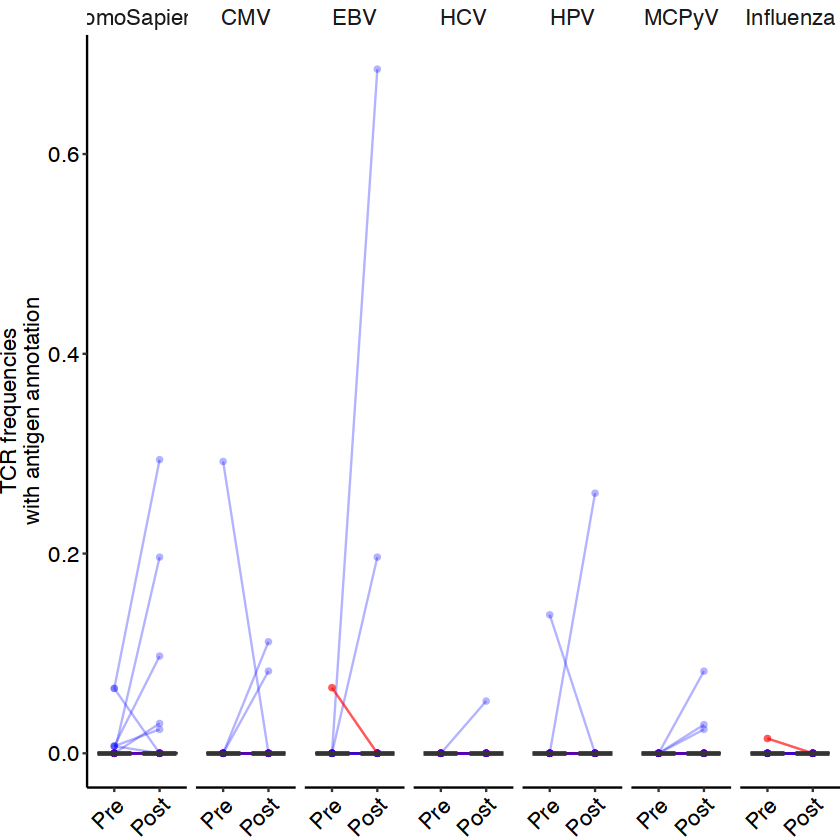

In [270]:
p_sample_cancer

In [271]:
pdf(paste0(plotpath, "antigen_frac_p_solid_cfDNA.pdf"), width = 10, height = 5)
p_sample_cancer
dev.off()

pdf 
  2

# 5- PCA gliph and save

In [ ]:
head(tmp)

In [ ]:
chp_gliph <- tmp[ grepl("CHP", tmp$Sample), ]

In [ ]:
chp_gliph <- chp_gliph[!grepl("Normal", chp_gliph$Sample), ]

In [ ]:
chp_gliph_sum <- chp_gliph %>% 
  group_by(Sample, pattern) %>% 
  summarise(SumFreq = sum(Freq), .groups = 'drop') %>%
  ungroup()

In [ ]:
head(chp_gliph_sum)

In [ ]:
chp_gliph_wide <- tidyr::pivot_wider(chp_gliph_sum[, c("Sample", "pattern", "SumFreq")], names_from = "pattern", values_from = "SumFreq")

In [ ]:
head(chp_gliph_wide)

In [ ]:
chp_gliph_wide <- as.data.frame(chp_gliph_wide)
rownames(chp_gliph_wide) <- chp_gliph_wide$Sample
chp_gliph_wide$Sample <- NULL

In [ ]:
chp_gliph_wide <- as.matrix(chp_gliph_wide)

In [ ]:
head(chp_gliph_wide)

In [ ]:
chp_gliph_wide[is.na(chp_gliph_wide)] <- 0

In [ ]:
head(chp_gliph_wide)

In [ ]:
# pbmc <- chp_gliph_wide[grepl("PBMC", rownames(chp_gliph_wide)),]
chp_gliph_wide <- chp_gliph_wide[, colSums(chp_gliph_wide > 0) > 0]

In [ ]:
mypca <- prcomp(chp_gliph_wide, center = TRUE, scale. = TRUE)

In [ ]:
# plot PCA with factoextra
viz_pca <- fviz_pca_ind(mypca,
    col.ind = as.vector(gsub(":.*", "", rownames(chp_gliph_wide))),
    # gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
    # remove labels
    label = "none",
    repel = TRUE, addEllipses = FALSE
)

In [ ]:
# scree plot
fviz_eig(mypca)

In [ ]:
viz_pca #+ coord_cartesian(xlim=c(-2, 10), ylim=c(-2, 10) )

In [ ]:
mypca$x[ mypca$x[,1] > 400 ,, drop = FALSE]

In [ ]:
chp_gliph_wide["Leukemia:CHP_359_X03-PBMC", , drop = FALSE]

In [ ]:
readr::write_rds(mypca, file = paste0(datapath, "GLIPH/gliph_PCA.rds"))